# Social Network Analysis - Amber Heard Case - Change.Org

## Table of Contents
<ul>
<li><a href="#intro"><b>Introduction</b></a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This case study aims to help **Amber Heard** <br>
> 
> By analyzing new accounts posting/ texting against a victim of a Social Bot Disinformation/Influence 

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import pickle
import re
import warnings
import datetime
warnings.filterwarnings('ignore')
sb.set_style("darkgrid")
%matplotlib inline

import plotly.io as pio
pio.renderers
# pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 950
svg_renderer.height = 550


import helpers

# To Apply helpers updates without resarting the kernel
import importlib
importlib.reload(helpers)

# # To keep track of any module updates
# %load_ext autoreload
# %autoreload2

%config InlineBackend.figure_format = 'retina'

In [2]:
cd ../../Change.org_Data

/Users/mnagy99/jupyter/AH/Change.org/Change.org_Data


<br>

<a id='eda'></a>
## Exploratory Data Analysis
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#eda"><b>Exploratory Data Analysis</b></a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

> <ul>
 <li><a href="#threat_comments">Threat Comments</a></li>
 <li><a href="#hate_speech">Hate-Speech Comments</a></li>
 <li><a href="#same">Same Text Same Date</a></li>
 <li><a href="#primarly">Primarly Text Investigations</a></li>
 </ul>

In [3]:
df_comments = pd.read_csv("./cleaned_data/petitions_comments_clened.csv")

df_comments["created_at"] = pd.to_datetime(df_comments["created_at"])
df_comments["date"] = pd.to_datetime(df_comments["date"])
df_comments['id'] = df_comments['id'].astype(str)
df_comments['commentable_id'] = df_comments['commentable_id'].astype(str)
df_comments['user_id'] = df_comments['user_id'].astype(str)

df_comments = df_comments.sort_values('created_at')
print(df_comments.shape)
df_comments.head(1)

(27238, 18)


id                                            comment  \
9380  457546085  given that:\n\n1) suicide is a leading cause o...   

     commentable_id  likes     role                created_at   user_id  \
9380        7177154      1  comment 2016-05-29 09:07:04+00:00  22109716   

                      username user_city user_country_code user_locale  \
9380  Marianna Anagnostopoulou    Athens                GR       en-US   

                      petition_slug status_manual  year       date month  \
9380  everybody-boycott-amber-heard       against  2016 2016-05-29   May   

      dayofmonth  hour  
9380          29     9

In [4]:
df_comments.created_at.dt.date.min(), df_comments.created_at.dt.date.max()

(datetime.date(2016, 5, 29), datetime.date(2021, 11, 12))

In [5]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27238 entries, 9380 to 4337
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id                 27238 non-null  object             
 1   comment            27238 non-null  object             
 2   commentable_id     27238 non-null  object             
 3   likes              27238 non-null  int64              
 4   role               27238 non-null  object             
 5   created_at         27238 non-null  datetime64[ns, UTC]
 6   user_id            27238 non-null  object             
 7   username           27238 non-null  object             
 8   user_city          23918 non-null  object             
 9   user_country_code  27230 non-null  object             
 10  user_locale        27238 non-null  object             
 11  petition_slug      27238 non-null  object             
 12  status_manual      27238 non-null  object   

In [6]:
helpers.isnull(df_comments)

The number of NaNs in id: 0
The number of NaNs in comment: 0
The number of NaNs in commentable_id: 0
The number of NaNs in likes: 0
The number of NaNs in role: 0
The number of NaNs in created_at: 0
The number of NaNs in user_id: 0
The number of NaNs in username: 0
The number of NaNs in user_city: 3320
The number of NaNs in user_country_code: 8
The number of NaNs in user_locale: 0
The number of NaNs in petition_slug: 0
The number of NaNs in status_manual: 0
The number of NaNs in year: 0
The number of NaNs in date: 0
The number of NaNs in month: 0
The number of NaNs in dayofmonth: 0
The number of NaNs in hour: 0


In [7]:
# df_comments.dropna(subset=['comment'], inplace=True)

In [8]:
for col in ['role', 'username', 'user_country_code', 'user_locale', 'status_manual', 'year', 'date']:
    print('The value counts of ' + col)
    print(df_comments[col].value_counts().head())
    print('\n')

The value counts of role
comment              26993
comment_dashboard      231
comment_psf             14
Name: role, dtype: int64


The value counts of username
Stephanie Brown    137
Joann Hess          78
Brandi Granger      68
Jenny Gurin         41
Ainsley Welch       39
Name: username, dtype: int64


The value counts of user_country_code
US    13345
GB     2105
MX     1638
CA     1607
AU     1044
Name: user_country_code, dtype: int64


The value counts of user_locale
en-US     15135
en-GB      3529
es-419     2994
en-CA      1538
en-AU      1138
Name: user_locale, dtype: int64


The value counts of status_manual
against    26806
for          414
related       18
Name: status_manual, dtype: int64


The value counts of year
2020    20869
2021     5757
2019      219
2018      197
2016      173
Name: year, dtype: int64


The value counts of date
2020-11-07    1698
2020-11-08    1667
2020-11-17    1567
2020-11-18    1111
2020-11-09    1109
Name: date, dtype: int64




<br>

<br>

In [9]:
# Create an empty set of threat commenting users
threat_users = set()

In [10]:
pos_text = {'love amber', 'stand with amber', 'standwithamber', 'support amber', 'supportamber', 'justiceforamber', 
            'johnnydeppisawifebeater', 'boycottwomenbeaters', 'wearewithamber', 'justice for amber', 
            'istandwithamber','wearewithyouamber', 'amber heard is innocent', 'amber is innocent','support her'}
df_pos = df_comments[df_comments.comment.str.contains('|'.join(pos_text))]

In [11]:
remove_users = set(df_pos.username)

In [12]:
# exclude all the users with positive comments
df_comments = df_comments[~df_comments.username.isin(remove_users)]

In [13]:
all_threat = {'and to die',
 'be killed',
 'blacklisted and burned',
 'burn down',
 'burn in hell',
 'burn the witch',
 'burns in hell',
 'burnt pig',
 'catch covid and die',
 'commits crimes',
 'death to',
 'demon from hell',
 'deserves a prison cell',
 'deserves fucking prison',
 'deserves hell',
 'deserves prison',
 'deserves punish',
 'die amber',
 'go to hell',
 'her crime',
 'her own crime',
 'imprison amber',
 'imprisoned for',
 'in a jail',
 'in fucking prison',
 'in hell',
 'in jail',
 'in prison',
 'into jail',
 'is a criminal',
 'is criminal',
 'jail for',
 'jail time',
 'kill amber',
 'kill herself',
 'kill yourself',
 'killher',
 'needs to be punished',
 'of hell',
 'place is jail',
 'prison now',
 'prison time',
 'prisonforamber',
 'prisontimetoamber',
 'punish',
 'punish amber',
 'punish her',
 'rot in b movie hell',
 'she burns',
 'she deserves it',
 'she dies',
 'should be imprisoned',
 'should be jailed',
 'should be punished',
 'to hell',
 'to jail',
 'to prison',
 'tohell',
 'unforgivable crimes',
 'will murder', 
 'amber can die'}

<br>

<br>

<a id='threat_comments'></a>
> ## Exploring Threat Comments
> <ul>
    <li><a href="#threat_comments"><b>Threat Comments</b></a></li>
 <li><a href="#hate_speech">Hate-Speech Comments</a></li>
 <li><a href="#same">Same Text Same Date</a></li>
 <li><a href="#same_youtube">Same YouTube UserNames</a></li>
 <li><a href="#primarly">Primarly Text Investigations</a></li>
 </ul>

In [14]:
threat_dict = helpers.count_keywords(all_threat|{'jail','prison','deserve',' hell','burn'}, df_comments, 'comment')
threat_counts = pd.DataFrame(threat_dict, index=['count'])
threat_counts = threat_counts.T.reset_index().rename(columns={'index':'keyword'})
threat_counts.sort_values('count', ascending=False, inplace=True)

In [15]:
threat_counts.head(60).reset_index(drop=True)

keyword  count
0                   deserve   3035
1                    punish    499
2                      jail    294
3                   in jail    157
4                      hell    109
5                    prison    107
6                   to jail     57
7                 in prison     51
8        should be punished     43
9                  jail for     39
10                jail time     29
11                     burn     29
12                  in hell     23
13                her crime     22
14     needs to be punished     21
15                  to hell     19
16          she deserves it     18
17            is a criminal     16
18               go to hell     14
19              is criminal     12
20                to prison     11
21          deserves prison      9
22         should be jailed      8
23              prison time      8
24           imprisoned for      7
25             burn in hell      6
26     should be imprisoned      5
27                in a jail      5
28               punish her      4
29          deserves punish      4
30                  of hell      4
31                she burns      3
32           burn the witch      3
33             punish amber      3
34                 she dies      3
35                into jail      2
36            burns in hell      2
37                 death to      2
38               prison now      2
39                die amber      2
40            place is jail      1
41                be killed      1
42        prisontimetoamber      1
43   deserves a prison cell      1
44           imprison amber      1
45               kill amber      1
46        in fucking prison      1
47             kill herself      1
48      unforgivable crimes      1
49            her own crime      1
50                   tohell      1
51  deserves fucking prison      1
52                burnt pig      1
53               and to die      1
54            deserves hell      1
55      catch covid and die      1
56           prisonforamber      1
57          demon from hell      1
58            amber can die      1
59      rot in b movie hell      1

<a id='all_threat'></a>
>>## All Threat 
> <ul>
 <li><a href="#all_threat"><b>All Threat</b></a></li>
 <li><a href="#kill_death">Kill & Death</a></li>
 <li><a href="#hell_burn">Hell & Burn</a></li>
 <li><a href="#crime_jail">Crime & Jail</a></li>
 <li><a href="#threat_users">Threat Users Contributions</a></li>
 </ul>

In [16]:
len(all_threat)

61

In [17]:
df_threat = df_comments[df_comments.comment.str.contains('|'.join(all_threat))]
print(f'{df_threat.shape[0]} contributions, on {df_threat.petition_slug.nunique()} Slugs, made by {df_threat.username.nunique()} Users')
df_threat.head(2)

958 contributions, on 74 Slugs, made by 874 Users


id                                            comment  \
9368  476368544  amber heard is a cruel and vicious woman who h...   
1181  532266899  i never trusted that scumbag bridezilla she sh...   

     commentable_id  likes     role                created_at    user_id  \
9368        7177154      9  comment 2016-07-03 19:43:34+00:00  565817003   
1181        8655098      2  comment 2016-11-05 19:34:11+00:00   28268805   

              username  user_city user_country_code user_locale  \
9368        Bunny Depp  San Diego                US       en-US   
1181  Gail Costenbader     Edison                US       en-US   

                                          petition_slug status_manual  year  \
9368                      everybody-boycott-amber-heard       against  2016   
1181  kate-quinn-support-jk-rowling-s-fantastic-beas...       against  2016   

           date month  dayofmonth  hour  
9368 2016-07-03   Jul           3    19  
1181 2016-11-05   Nov           5    19

<br>

### A Heat Map for the Threat Comments 

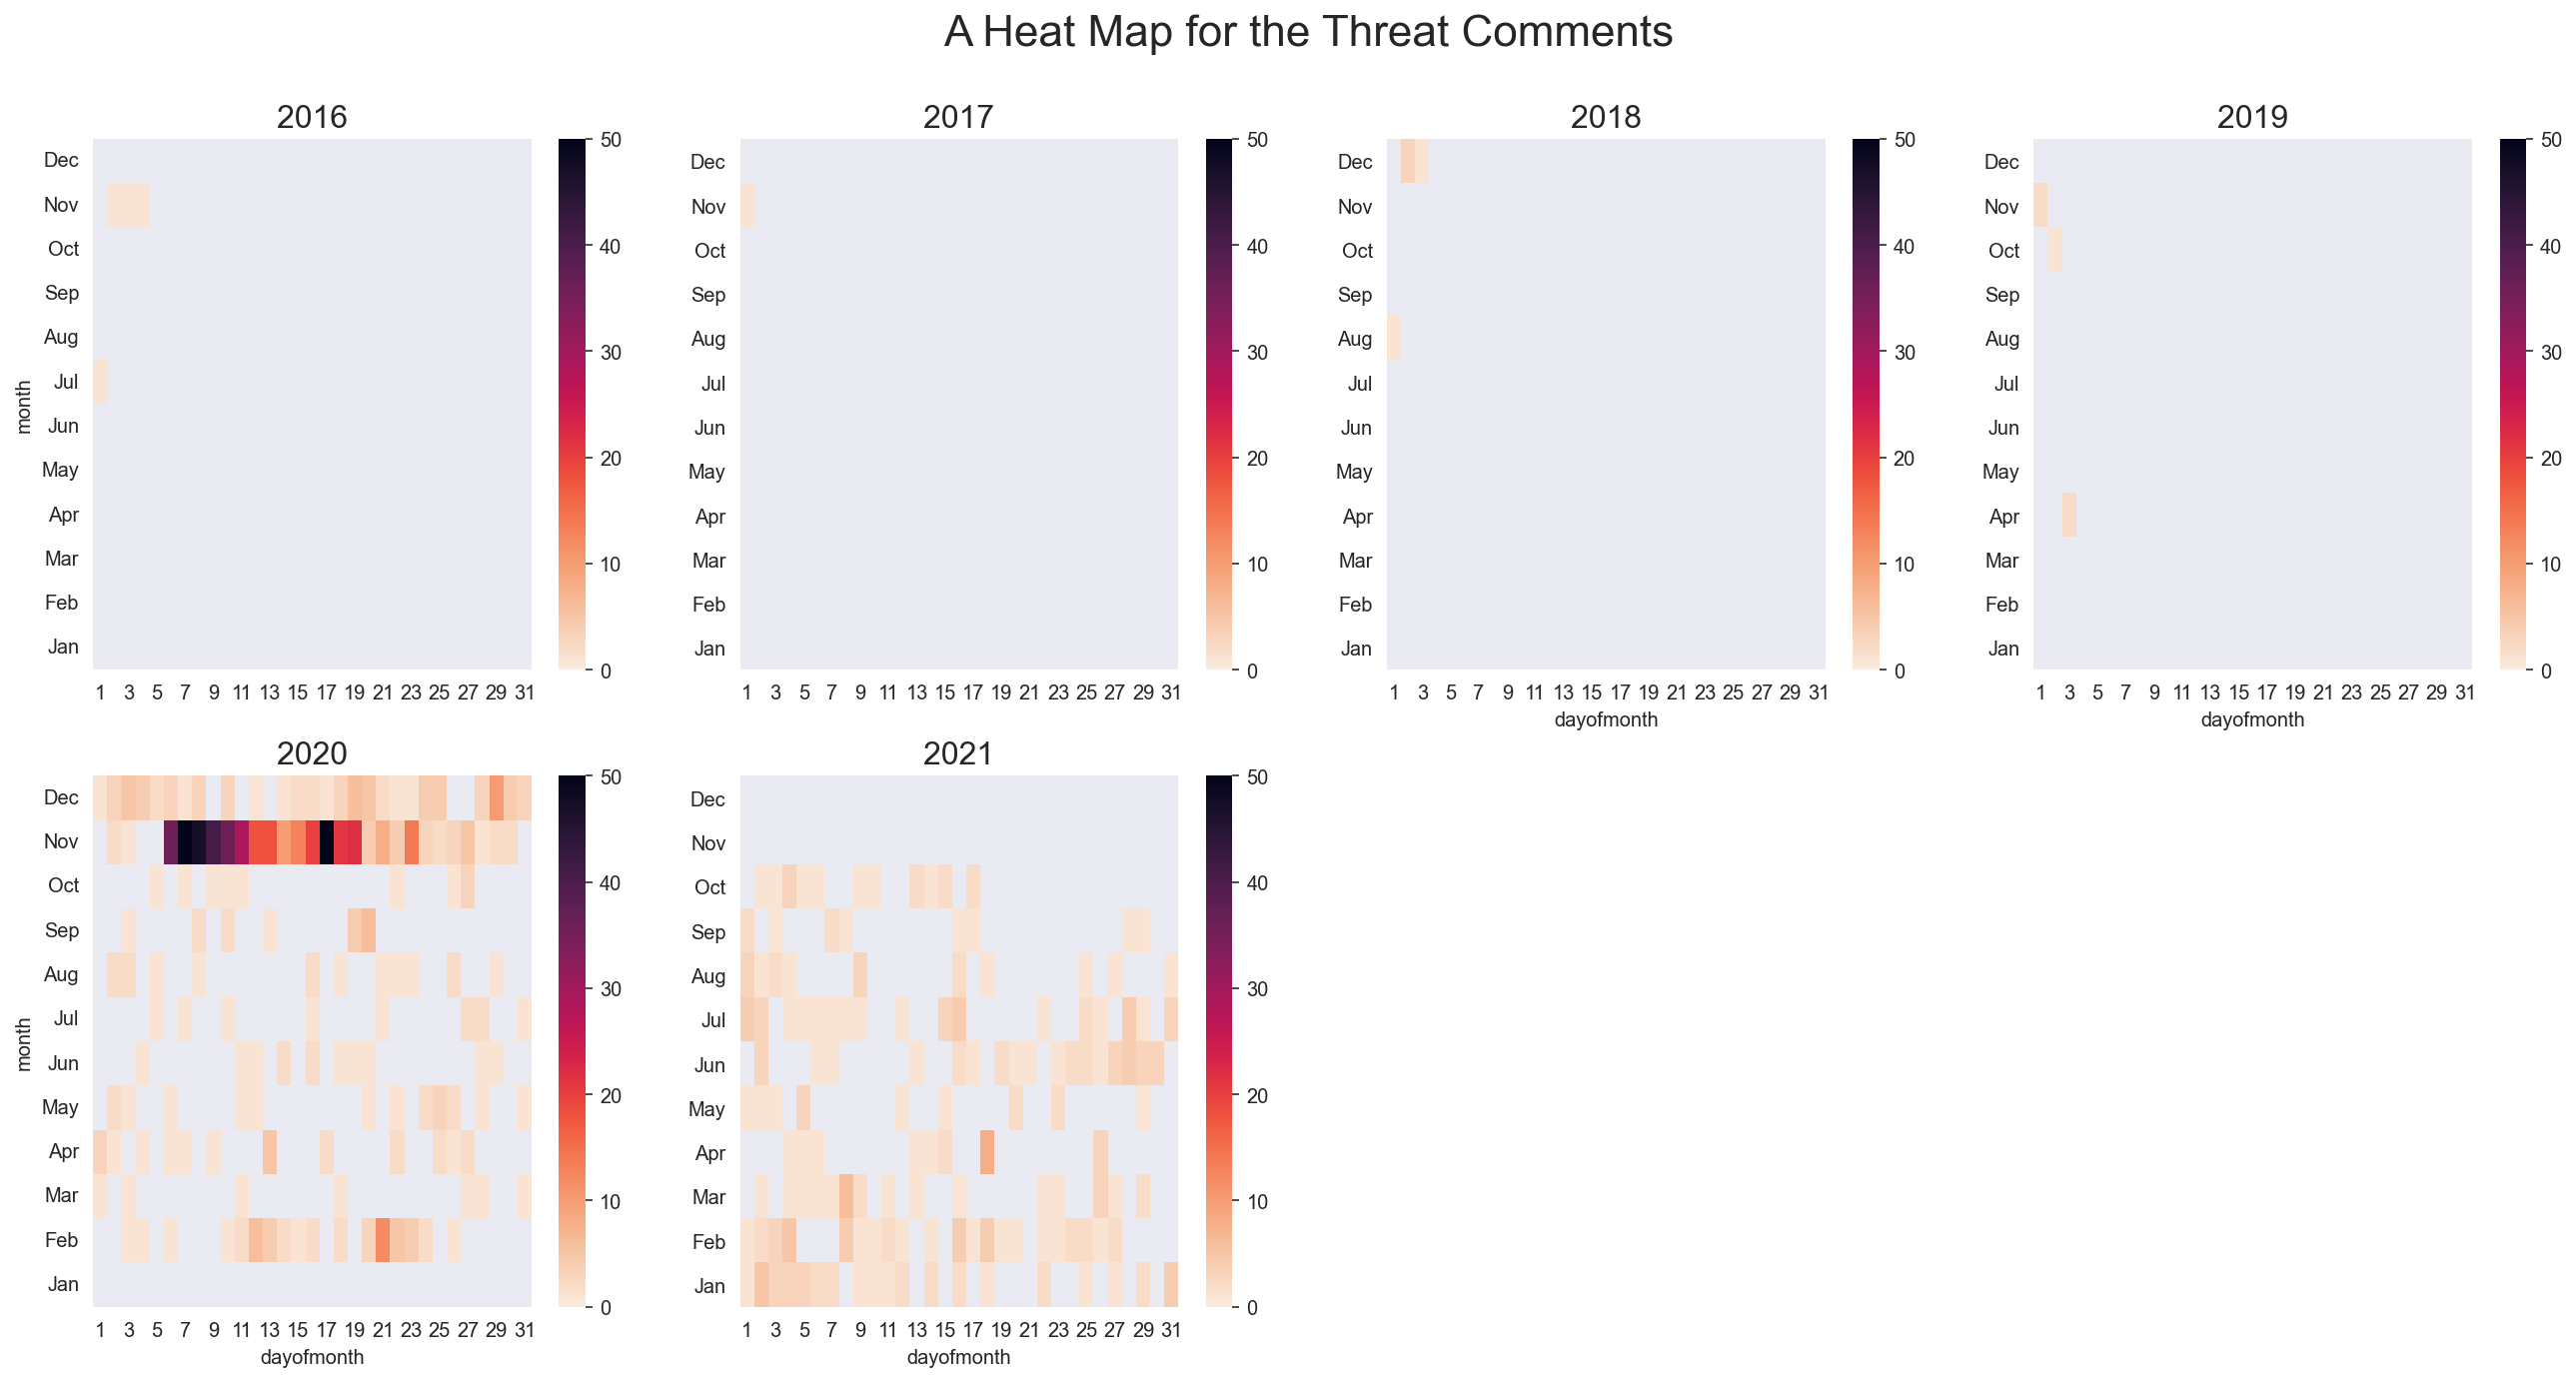

In [18]:
threat_daily = df_threat.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

title = 'A Heat Map for the Threat Comments'
helpers.facet_heat(threat_daily, title, n_col=4, vmax=50)

### Threat Comments Peak Dates

In [19]:
threat_dates = df_threat.groupby(['date']).agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'}).sort_values('ncomments', ascending=False)

threat_dates.head(15)

date  ncomments  likes
115 2020-11-17         52     61
105 2020-11-07         50     19
106 2020-11-08         47     13
107 2020-11-09         41     11
108 2020-11-10         36     15
104 2020-11-06         36     41
109 2020-11-11         29     18
117 2020-11-19         22     23
116 2020-11-18         21     49
114 2020-11-16         20     12
111 2020-11-13         18      7
110 2020-11-12         18      7
121 2020-11-23         14      7
113 2020-11-15         13      4
23  2020-02-21         12     11

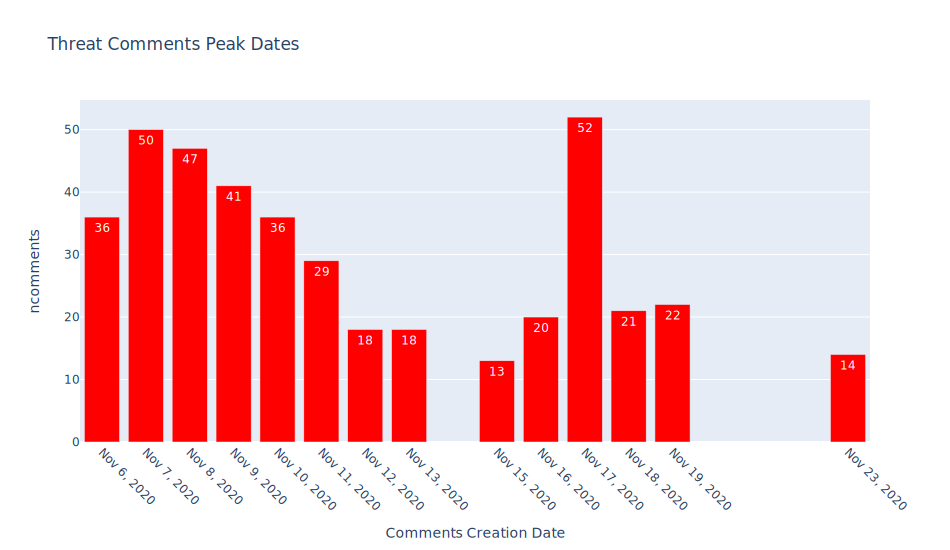

In [20]:
helpers.bar_peaks(threat_dates[['date', 'ncomments']].head(14), 
                  'Threat Comments Peak Dates')

# Most Repeated Threat Comments

In [21]:
df_threat.comment.value_counts().head(60)

she deserves it                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         8
i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done 

In [22]:
df_threat.comment.value_counts()[60:].head(60)

punish the guilty and stop punishing the innocent\nstop letting abusers get away with it                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   1
start punishing the guilty and not the innocent                                                                                                                                                                                                                                            

In [23]:
df_threat.comment.value_counts()[120:].head(60)

amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she was even arrested for domestic violence by an officer who witnessed the assault. heard should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others. johnny depp who did not have this history in his former relationships is the victim of abuse and at some point victims do fight back as a result of the abuse. he should not be punished for being a victim.                                                                                   1
amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she was even arrested for domestic violence by an officer who witness the assault. heard should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others. johnny depp who did not have this history in his former

### Text == "she deserves it" --> 8

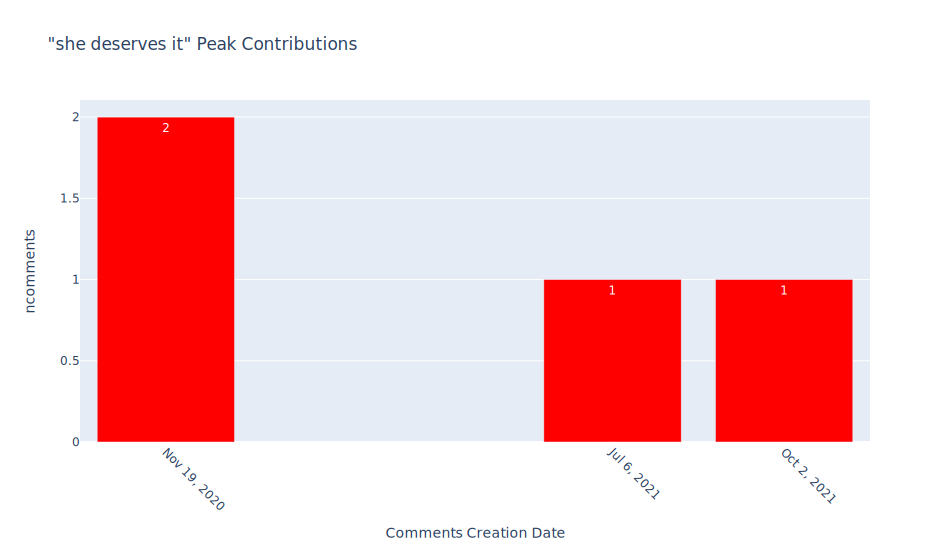

In [24]:
helpers.text_peaks(df_threat, 'she deserves it', n=3, threshold=0)


Note: The same comment repeated 8 times by different users



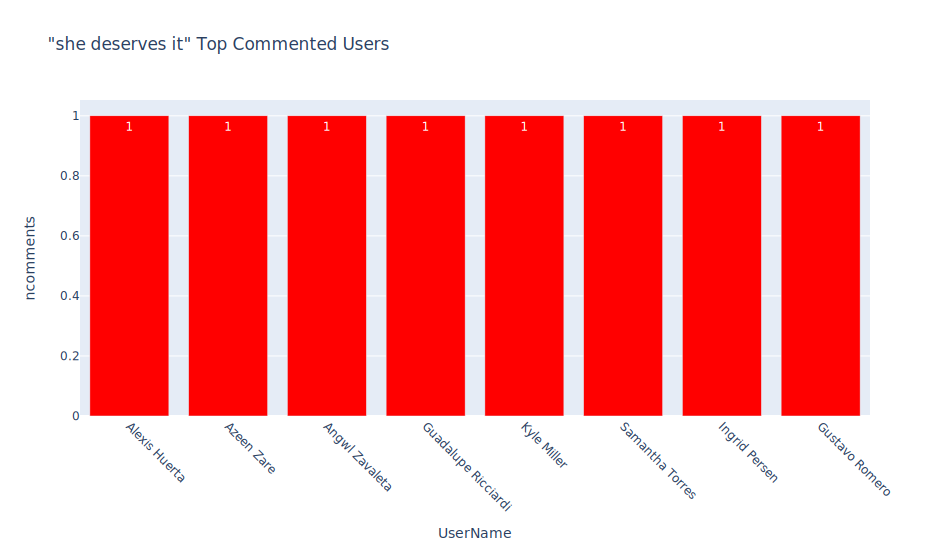

In [25]:
importlib.reload(helpers)
print('\nNote: The same comment repeated 8 times by different users\n')
helpers.users_peaks(df_threat, 'she deserves it', n=10, threshold=0)

### All text containing "she deserves it"

In [26]:
df_all_deserve = df_threat[df_threat.comment.str.contains('she deserves it')]
print(f'{df_all_deserve.shape[0]} contributions, on {df_all_deserve.petition_slug.nunique()} Slugs, made by {df_all_deserve.username.nunique()} Users')
df_all_deserve


18 contributions, on 9 Slugs, made by 18 Users


id                                            comment  \
4276   768118102              i am signing because she deserves it.   
20247  777787312  we love johnny depp and this woman is clearly ...   
18427  808806066                                   she deserves it.   
18337  808814486                                    she deserves it   
17601  808921332                                    she deserves it   
25097  808960219  he should be able to do things he loves. its a...   
7392   809372938                                    she deserves it   
6829   809390832  she deserves it, we all know she deserves it, ...   
6004   809431848                                    she deserves it   
5923   809434952                                    she deserves it   
5087   809539741                                    she deserves it   
10240  810883291  yeahhhhhhh amber is fucking dumbass and she de...   
16166  811361925               i'm signing because she deserves it!   
14670  813906600  she deserves it !!!! depp was immediatley fire...   
2410   820506768  first of all emilia is a better actress. secon...   
16085  821292850                                    she deserves it   
139    822219113                           because she deserves it.   
4458   824548393                                    she deserves it   

      commentable_id  likes     role                created_at     user_id  \
4276        14834664      6  comment 2019-11-11 16:58:37+00:00   945945494   
20247       20196023      1  comment 2020-03-18 18:43:54+00:00  1054887336   
18427       20196023      0  comment 2020-11-07 00:05:25+00:00    29372949   
18337       20196023      1  comment 2020-11-07 03:12:35+00:00  1037768775   
17601       20196023      0  comment 2020-11-08 22:17:28+00:00   935875493   
25097       20186707      0  comment 2020-11-09 15:29:27+00:00  1090382714   
7392        14451136      0  comment 2020-11-17 18:58:48+00:00  1050552787   
6829        14451136      2  comment 2020-11-18 06:34:42+00:00  1000037242   
6004        14451136      0  comment 2020-11-19 03:26:56+00:00  1115558214   
5923        14451136      1  comment 2020-11-19 06:12:25+00:00  1015272678   
5087        14451136      0  comment 2020-11-21 17:29:54+00:00  1043092126   
10240       13641580      1  comment 2020-12-18 14:32:10+00:00  1169905836   
16166       26062476      1  comment 2021-01-01 08:09:38+00:00  1164346223   
14670       25704328      0  comment 2021-02-19 11:49:02+00:00  1165615326   
2410        20204830      0  comment 2021-06-16 20:43:25+00:00  1185200754   
16085       26062476      0  comment 2021-07-06 23:50:24+00:00  1176088338   
139         20569720      0  comment 2021-08-02 18:44:03+00:00  1218795036   
4458        14451136      0  comment 2021-10-02 13:50:11+00:00  1177161190   

                    username               user_city user_country_code  \
4276              Devora Lee                Winnipeg                CA   
20247            Tanvi Malik                  Jaipur                IN   
18427        Joseph thompson                clarkson                US   
18337          Alexis Huerta              Glen Ellyn                US   
17601             Azeen Zare         North Vancouver                CA   
25097          Damien Talley           Oklahoma City                US   
7392          Angwl Zavaleta         North Hollywood                US   
6829          Nicholas Aaron                Richmond                US   
6004     Guadalupe Ricciardi             Ramos Mejia                AR   
5923             Kyle Miller                  Neenah                US   
5087         Samantha Torres             Westminster                US   
10240          Anna Macnutty                   Akola                US   
16166         Princess Solis  Bansalan Davao del Sur                PH   
14670  Cziarene Ghel Nocidal                Sorsogon                PH   
2410             Christina L                  Hollis                US 

### A Heat Map for the "She Deserves It" Comments 

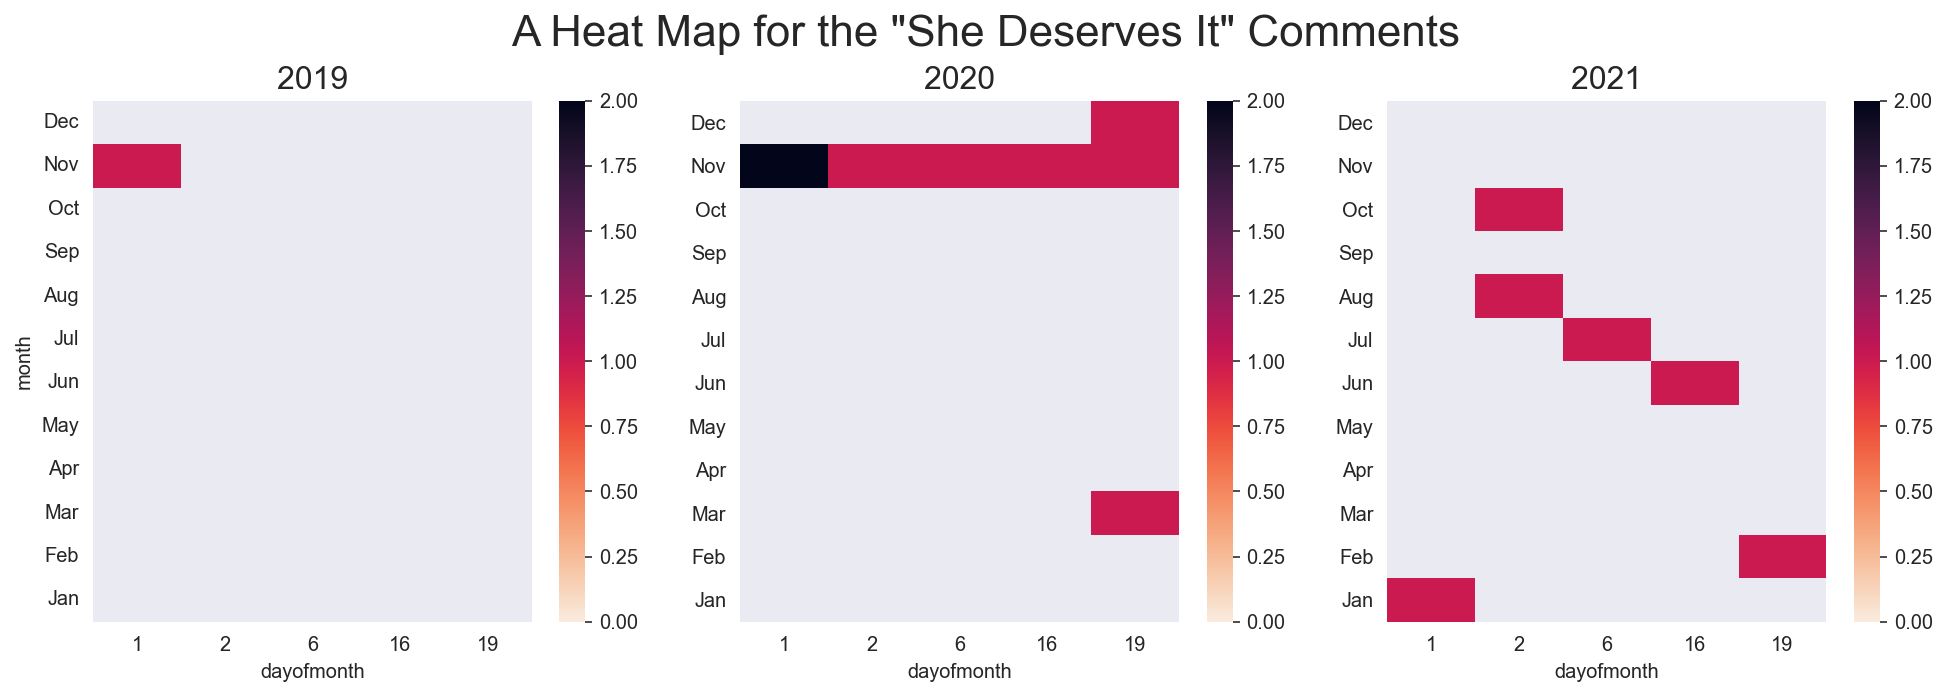

In [27]:
deserve_daily = df_all_deserve.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

title = 'A Heat Map for the "She Deserves It" Comments'
helpers.facet_heat(deserve_daily, title, n_col=3, vmax=2)

In [28]:
df_all_deserve.petition_slug.value_counts()

dc-entertainment-remove-amber-heard-from-aquaman-2                                                                       6
l-oréal-remove-amber-heard-as-l-oreal-spokesperson                                                                       4
united-states-supreme-court-put-amber-heard-behind-bars                                                                  2
support-amber-heard-in-aquaman-2-her-life-and-public-safety-to-save-lives-warner-bros-mera-loreal-united-nations-aclu    1
justice-for-johnny-depp                                                                                                  1
johnnydeppisinnocent                                                                                                     1
people-with-common-sense-amber-heard-must-be-fired-too                                                                   1
dc-comics-replace-amber-heard-with-emilia-clarke-as-mera-in-aquaman-2                                                    1
hollywood-boycot

In [29]:
df_all_deserve.user_country_code.value_counts()

US    11
CA     2
PH     2
IN     1
AR     1
NO     1
Name: user_country_code, dtype: int64

In [30]:
df_all_deserve.user_locale.value_counts()

en-US     12
en-CA      2
en-IN      2
es-419     1
es-AR      1
Name: user_locale, dtype: int64

In [31]:
df_all_deserve.user_city.value_counts()

Winnipeg                  1
Neenah                    1
Oslo                      1
Hollis                    1
Sorsogon                  1
Bansalan Davao del Sur    1
Akola                     1
Westminster               1
Ramos Mejia               1
Jaipur                    1
Richmond                  1
North Hollywood           1
Oklahoma City             1
North Vancouver           1
Glen Ellyn                1
clarkson                  1
Jacksonville              1
Name: user_city, dtype: int64

In [32]:
df_all_deserve.role.value_counts()

comment    18
Name: role, dtype: int64

In [33]:
df_all_deserve.status_manual.value_counts()

against    17
for         1
Name: status_manual, dtype: int64

In [34]:
df_all_deserve.comment.value_counts().head(60)

she deserves it                                                                                                                                                                                                                                                                                                                                                                               8
i am signing because she deserves it.                                                                                                                                                                                                                                                                                                                                                         1
we love johnny depp and this woman is clearly  a psychopath  she is the one who abused johnny and sought his money \nshe deserves it.  evil women                                                                                       

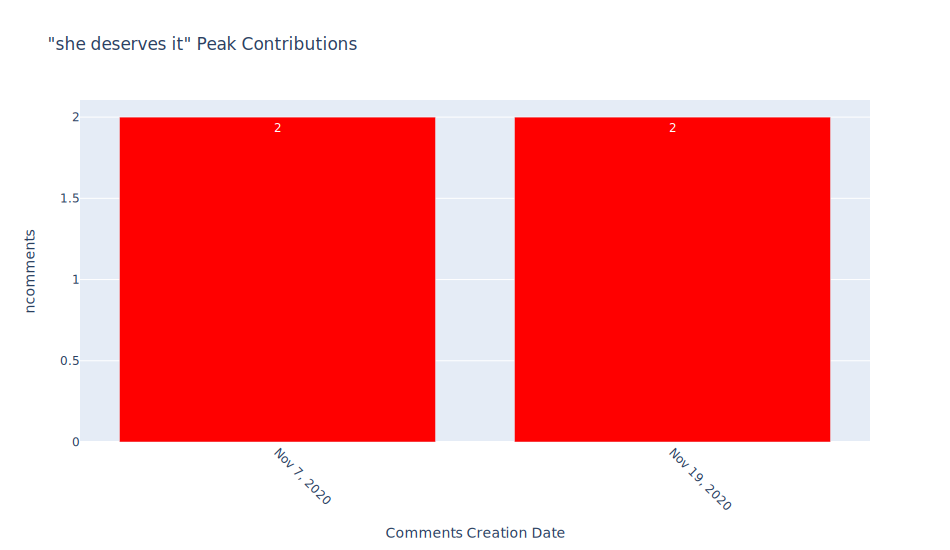

In [35]:
helpers.text_peaks(df_comments, 'she deserves it', n=2, threshold=0, mode='contain')

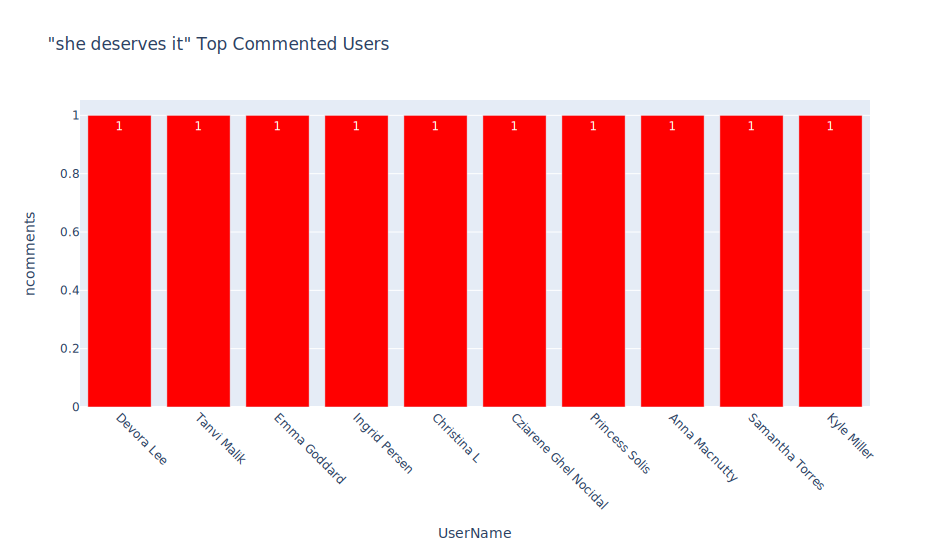

In [36]:
helpers.users_peaks(df_comments, 'she deserves it', n=10, threshold=0, mode='contain')

<b>

### All text containing "neither russian nor a bot"

In [37]:
df_all_bot = df_comments[df_comments.comment.str.contains('neither russian nor a bot')]
print(f'{df_all_bot.shape[0]} contributions, on {df_all_bot.petition_slug.nunique()} Slugs, made by {df_all_bot.username.nunique()} Users')
df_all_bot.head()


7 contributions, on 7 Slugs, made by 1 Users


id                                            comment  \
275    817040067  i am neither russian nor a bot. amber heard ha...   
2539   817040164  i am neither russian nor a bot. amber heard ha...   
15344  817040209  i am neither russian nor a bot. amber heard ha...   
15560  817040254  i am neither russian nor a bot. amber heard ha...   
16208  817040303  i am neither russian nor a bot. amber heard ha...   

      commentable_id  likes     role                created_at   user_id  \
275         20569720      1  comment 2021-04-18 04:55:07+00:00  45110623   
2539        25717146      1  comment 2021-04-18 04:58:37+00:00  45110623   
15344       25752458      1  comment 2021-04-18 05:00:43+00:00  45110623   
15560       20187467      0  comment 2021-04-18 05:02:51+00:00  45110623   
16208       25859415      2  comment 2021-04-18 05:04:34+00:00  45110623   

        username user_city user_country_code user_locale  \
275    MELISSA F    Denver                US       en-US   
2539   MELISSA F    Denver                US       en-US   
15344  MELISSA F    Denver                US       en-US   
15560  MELISSA F    Denver                US       en-US   
16208  MELISSA F    Denver                US       en-US   

                                           petition_slug status_manual  year  \
275              hollywood-boycott-aquaman-2-amber-heard       against  2021   
2539     warner-brothers-give-johnny-deep-his-roles-back       against  2021   
15344  dc-replace-amber-heard-with-danny-devito-in-aq...       against  2021   
15560  warner-brothers-amber-heard-does-not-deserve-t...       against  2021   
16208  warner-brothers-dc-entertainment-emilia-clarke...       against  2021   

            date month  dayofmonth  hour  
275   2021-04-18   Apr          18     4  
2539  2021-04-18   Apr          18     4  
15344 2021-04-18   Apr          18     5  
15560 2021-04-18   Apr          18     5  
16208 2021-04-18   Apr          18     5

In [38]:
df_all_bot.comment.value_counts().head(60)

i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift & severe punishment in order to be made an example of. #justiceforjohnnydepp    6
i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift and severe punishment in order to make an example. #justiceforjohnnydepp        1
Name: comment, dtype: int64

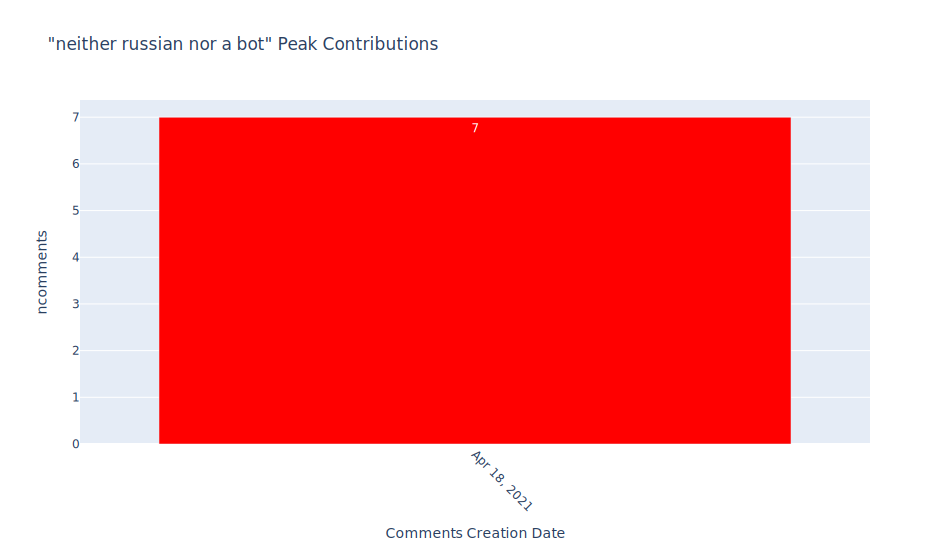

In [39]:
helpers.text_peaks(df_comments, 'neither russian nor a bot', n=2, threshold=0, mode='contain')

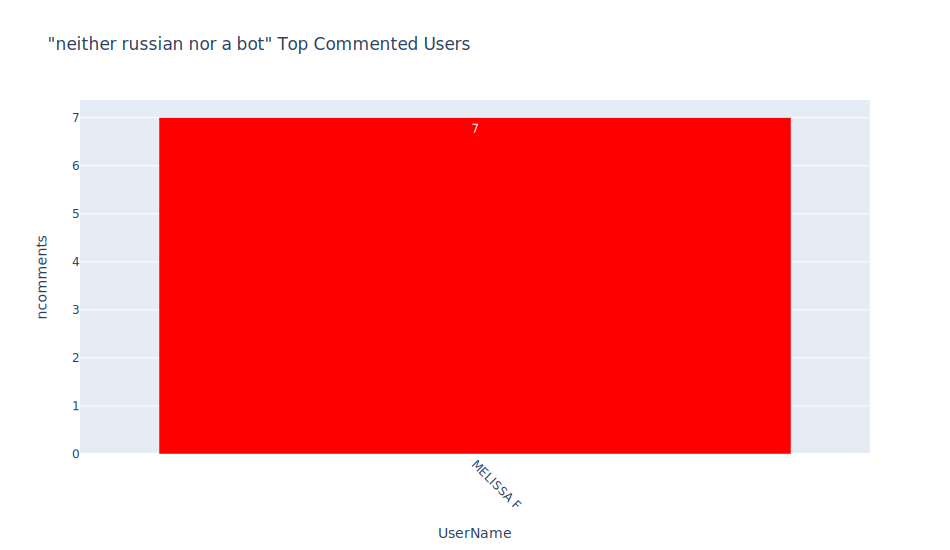

In [40]:
helpers.users_peaks(df_comments, 'neither russian nor a bot', n=10, threshold=0, mode='contain')

# Top Users Commented with Threat keywords

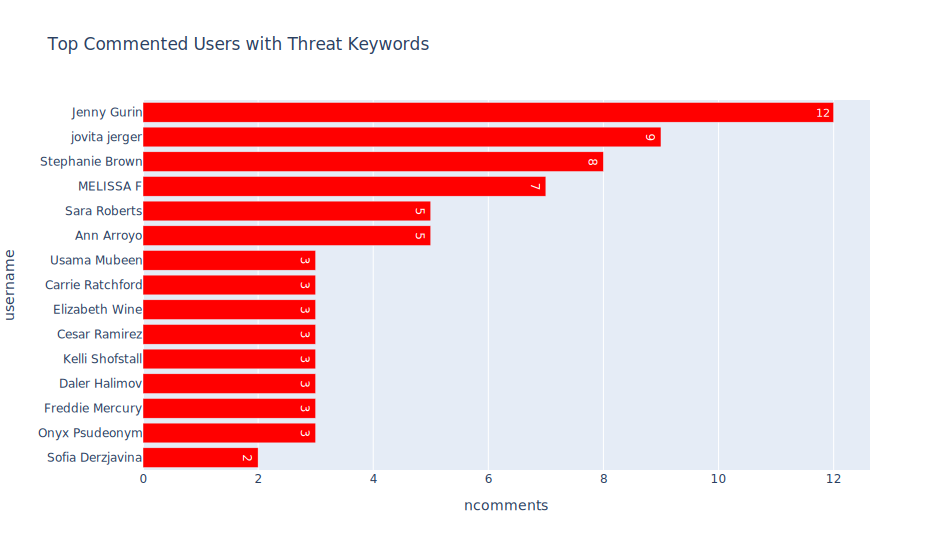

In [41]:
df_threat_users = df_threat.username.value_counts().to_frame().reset_index().rename(columns={'index':'username',
                                                                                  'username':'ncomments'})
helpers.barh(df_threat_users.head(15), 'Top Commented Users with Threat Keywords', threshold=0, c=0)

In [42]:
df_threat.username.value_counts().head(15)

Jenny Gurin         12
jovita jerger        9
Stephanie Brown      8
MELISSA F            7
Sara Roberts         5
Ann Arroyo           5
Usama Mubeen         3
Carrie Ratchford     3
Elizabeth Wine       3
Cesar Ramirez        3
Kelli Shofstall      3
Daler Halimov        3
Freddie Mercury      3
Onyx Psudeonym       3
Sofia Derzjavina     2
Name: username, dtype: int64

In [43]:
df_comments.query(" username == 'Jenny Gurin' ").comment.value_counts().head(60)

johnny is innocent and deserves nothing but the best!!                                                                                                                                                                                                                                                                                                                                                                                   4
she has taken advantage of and abused my favorite actor for years                                                                                                                                                                                                                                                                                                                                                                        1
these nasty lies and accusations about johnny (my favorite actor since childhood) have got to stop, and the person responsible for starting all of

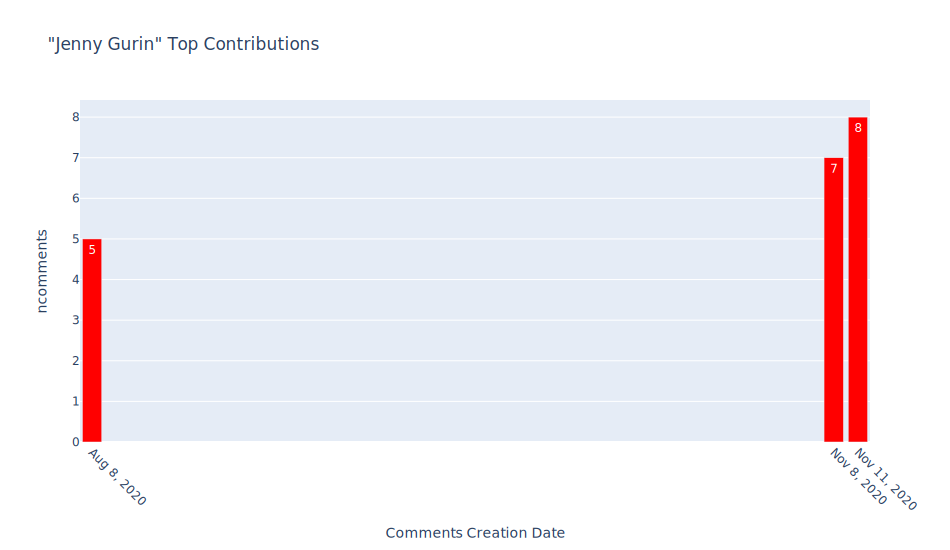

In [44]:
helpers.contr_peaks(df_comments, "Jenny Gurin", n=3, threshold=0)

In [45]:
df_comments.query(" username == 'jovita jerger' ").comment.value_counts().head(60)

# justice for the innocent \n# justice for johnny depp                                                                                                    1
# justice for johnny depp\n# justice for the innocent                                                                                                     1
justice for the innocent \njustice for johnny depp                                                                                                        1
punish the guilty! not the innocent!! \njustice for victims not the abusers!!                                                                             1
punish the guilty not the innocent!!!\njustice for the victims not the abusers \nstop letting abusers get away with abuse and have the victims suffer!    1
punish the  guilty not the innocent\nstop punishing the victims and letting the abusers get away with it stop domestic abuse                              1
stop punishing the victims and punish the abusers\nstop domestic

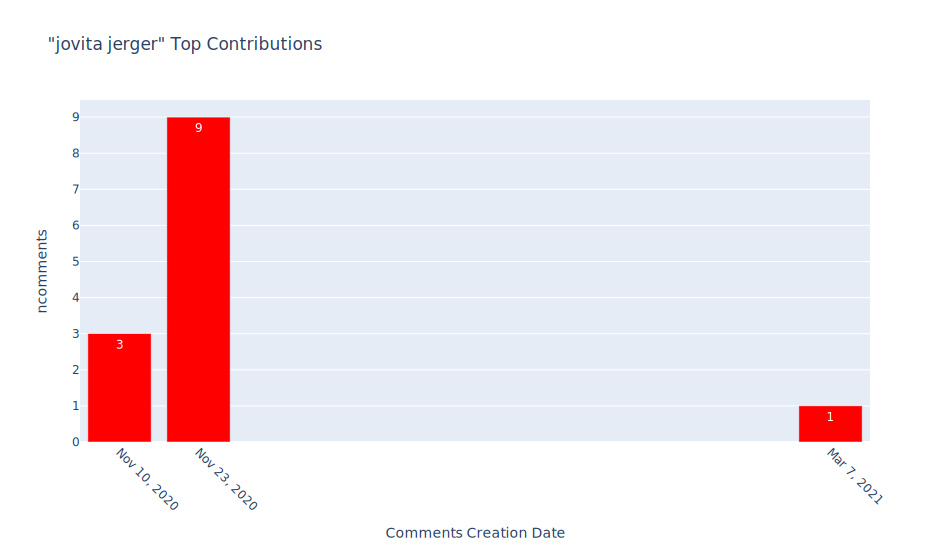

In [46]:
helpers.contr_peaks(df_comments, "jovita jerger", n=4, threshold=0)

In [47]:
df_comments.query(" username == 'Stephanie Brown' ").comment.value_counts().head(60)

#justiceforjohnnydepp!                                                                                                                                                                                                                                                                                                                                                                                4
#johnnydeppismygrindelwald!                                                                                                                                                                                                                                                                                                                                                                           3
johnny depp is innocent!                                                                                                                                                                                                

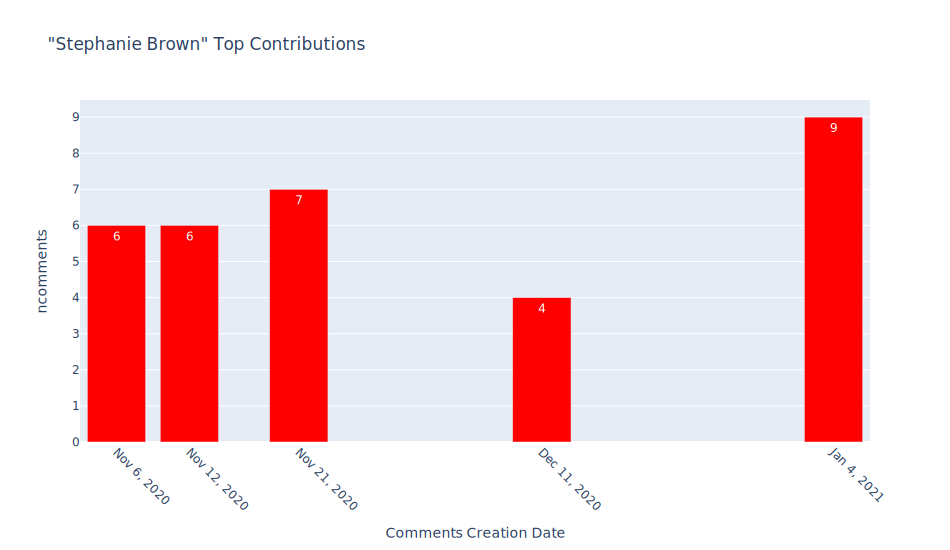

In [48]:
helpers.contr_peaks(df_comments, "Stephanie Brown", n=5, threshold=0)

In [49]:
df_comments.query(" username == 'MELISSA F' ").comment.value_counts().head(10)

i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift & severe punishment in order to be made an example of. #justiceforjohnnydepp    6
i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift and severe punishment in order to make an example. #justiceforjohnnydepp        1
Name: comment, dtype: int64

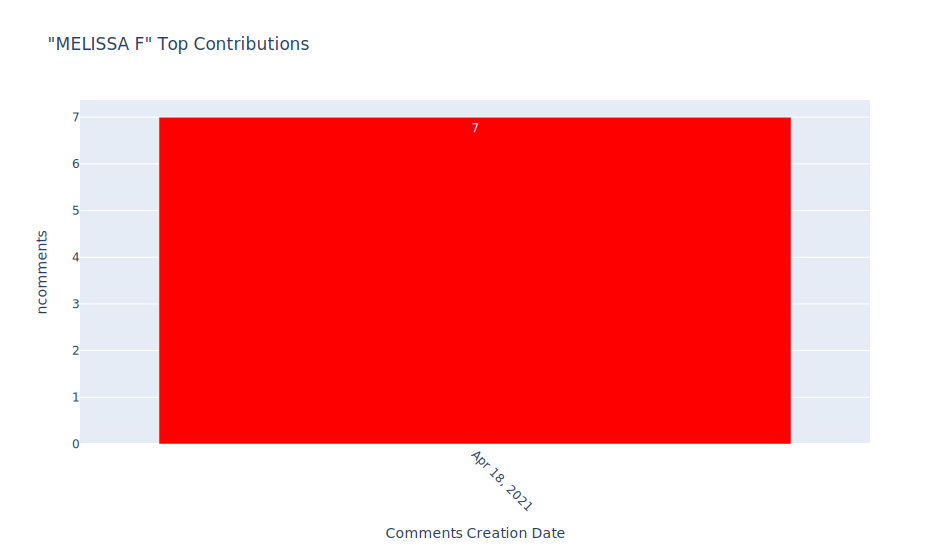

In [50]:
helpers.contr_peaks(df_comments, "MELISSA F", n=3, threshold=0)

In [51]:
df_comments.query(" username == 'Sara Roberts' ").comment.value_counts().head(60)

thank you to whoever brought this tape forward! johnny has had his life ruined for the past five years because a woman made claims and fake evidence and people stupidly bought it. well, time’s up, amb!tch! #justiceforjohnny #cancelamberheard #fireamberheard #therealabuser #wearewithyoujohnny                                                                  1
she is a disgrace and a #metoo liar! she used the fact that she’s a woman and ran with it. sadly, our culture believes lying women. #istandwithjohnnydepp                                                                                                                                                                                                             1
she’s a better actress!!!                                                                                                                                                                                                                                                               

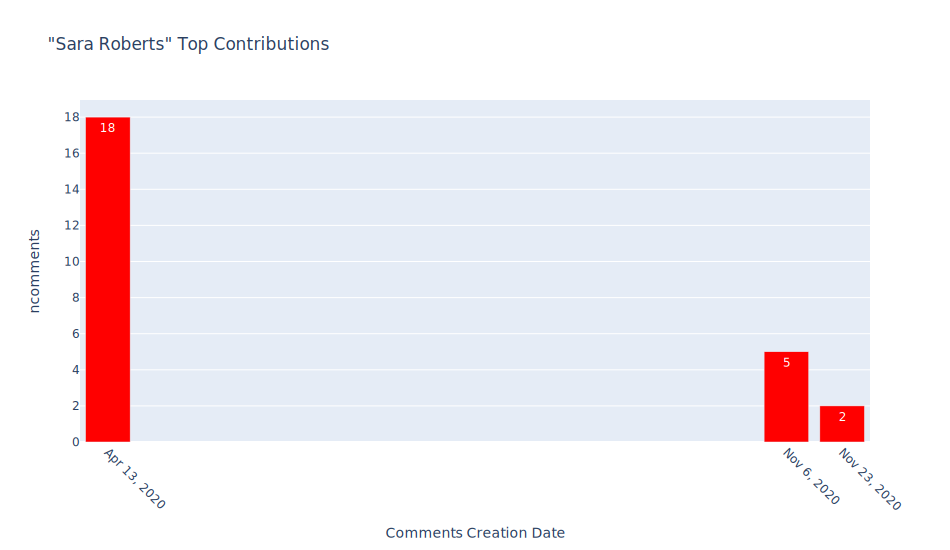

In [52]:
helpers.contr_peaks(df_comments, "Sara Roberts", n=3, threshold=0)

In [53]:
df_comments.query(" username == 'Ann Arroyo' ").comment.value_counts().head(60)

amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she was even arrested for domestic violence by an officer who witness the assault. heard should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others. johnny depp who did not have this history in his former relationships is the victim of abuse and at some point victims do fight back as a result of the abuse. he should not be punished for being a victim.                                                                                     3
amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others.                                                                                                                                             

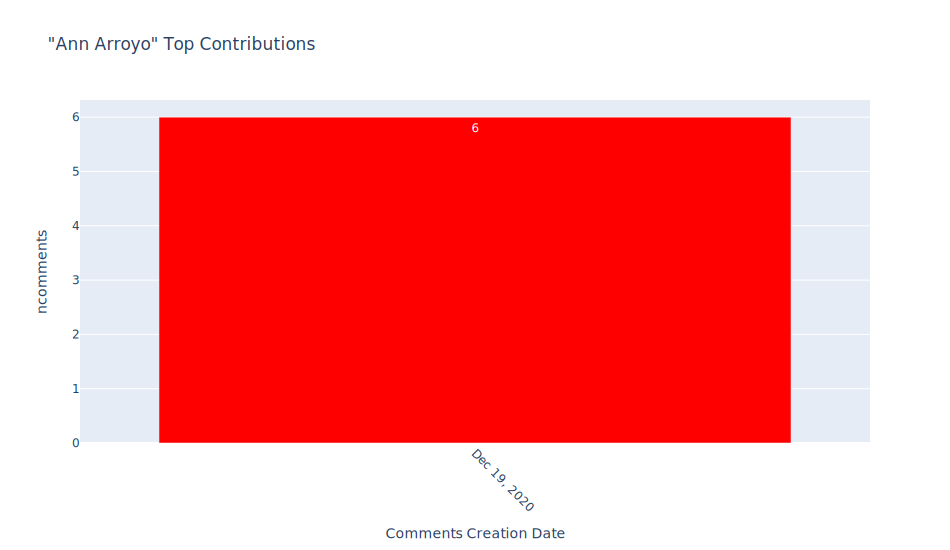

In [54]:
helpers.contr_peaks(df_comments, "Ann Arroyo", n=3, threshold=0)

In [55]:
df_comments.query(" username == 'Usama Mubeen' ").comment.value_counts().head()

heard is a fucking lair... put her in jail, and give mr. sparrow his role back.    3
we want our capt back...                                                           1
Name: comment, dtype: int64

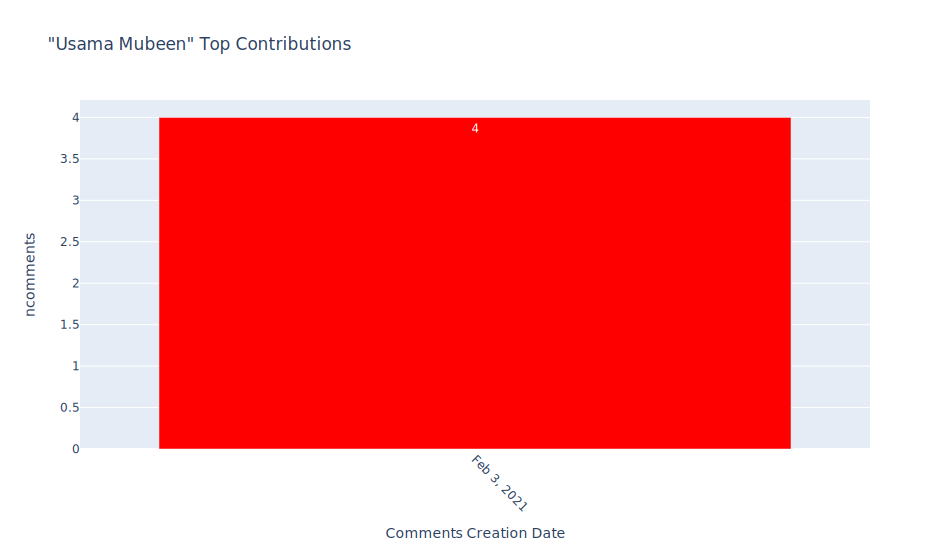

In [56]:
helpers.contr_peaks(df_comments, "Usama Mubeen", n=3, threshold=0)

In [57]:
df_comments.query(" username == 'Carrie Ratchford' ").comment.value_counts().head(60)

#justiceforjohnny                                                                                                                                                                                13
#justiceforall                                                                                                                                                                                    2
you rock johnny, it would never be poc without you !                                                                                                                                              1
to be fair, if his career is ruined hres should should be to what makes her so special ?                                                                                                          1
it was proven beyond the shadow of a doubt that she lied in a court of law and physical and mentally abused johnny. that is a criminal offence she deserves to do her time like anyone else !     1
she must be held acc

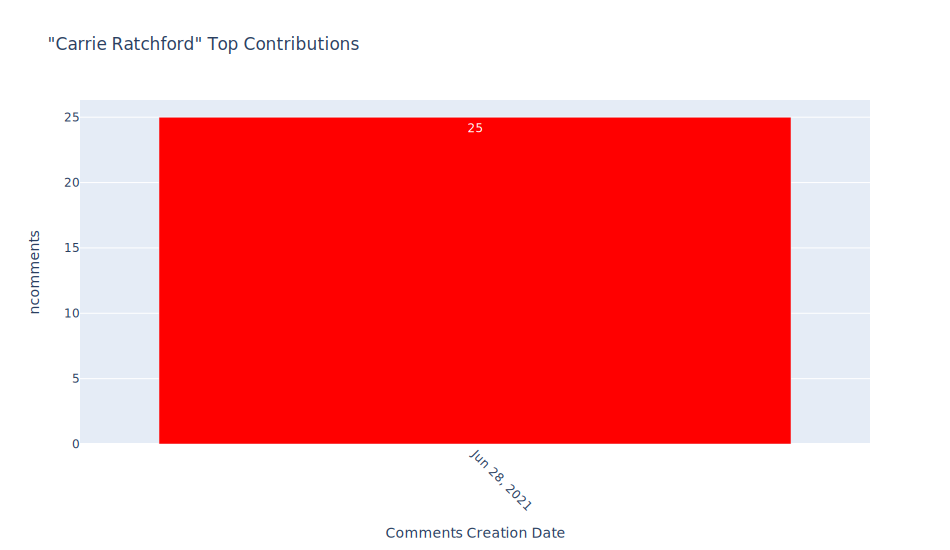

In [58]:
helpers.contr_peaks(df_comments, "Carrie Ratchford", n=3, threshold=0)

In [59]:
df_comments.query(" username == 'Elizabeth Wine' ").comment.value_counts().head()

stop punishing the victim of the abuse!    3
Name: comment, dtype: int64

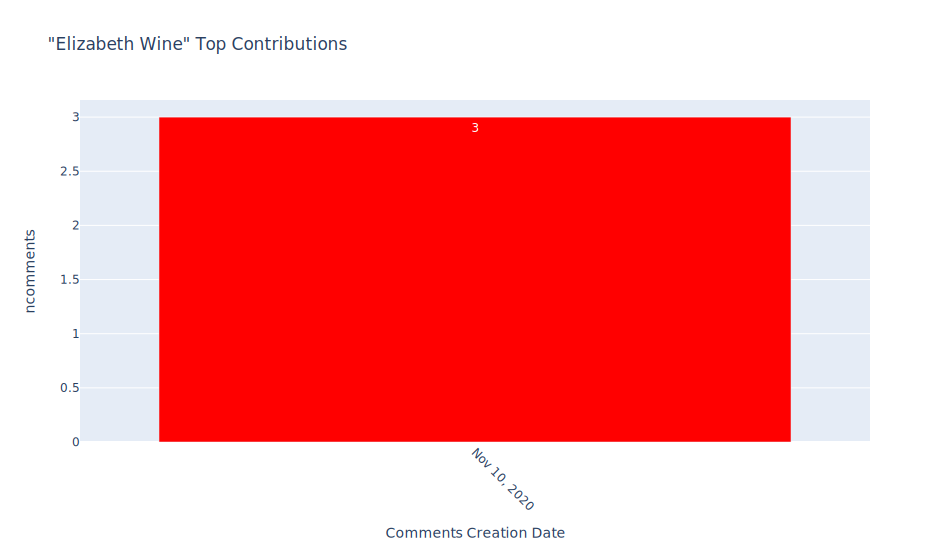

In [60]:
helpers.contr_peaks(df_comments, "Elizabeth Wine", n=3, threshold=0)

In [61]:
df_comments.query(" username == 'Cesar Ramirez' ").comment.value_counts().head(60)

johnny depp is innocent, amber heard is a lier, amber heard is an abuser, johnny depp needs to comeback gellert grindelwald for fantastic beast 3.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

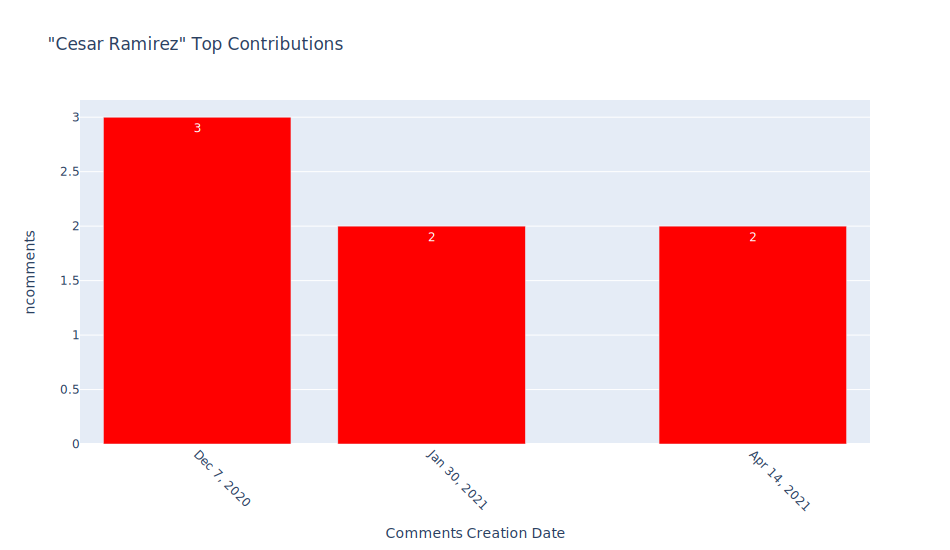

In [62]:
helpers.contr_peaks(df_comments, "Cesar Ramirez", n=3, threshold=0)

In [63]:
df_comments.query(" username == 'Kelli Shofstall' ").comment.value_counts().head(60)

she abused a man 23 years older than her and lied about it. she should be in jail not in a movie. johnny depp is a much beloved actor who gives us so much joy. she is taking truth away from actual victims of domestic violence and continuing a false narrative. she should be ashamed of herself      2
she abused a man 23 years older than her and lied about it. she should be in jail not in a movie. johnny depp is a much beloved actor who gives us so much joy. she is taking truth away from actual victims of domestic violence and continuing a false narrative. she should be ashamed of herself..    1
Name: comment, dtype: int64

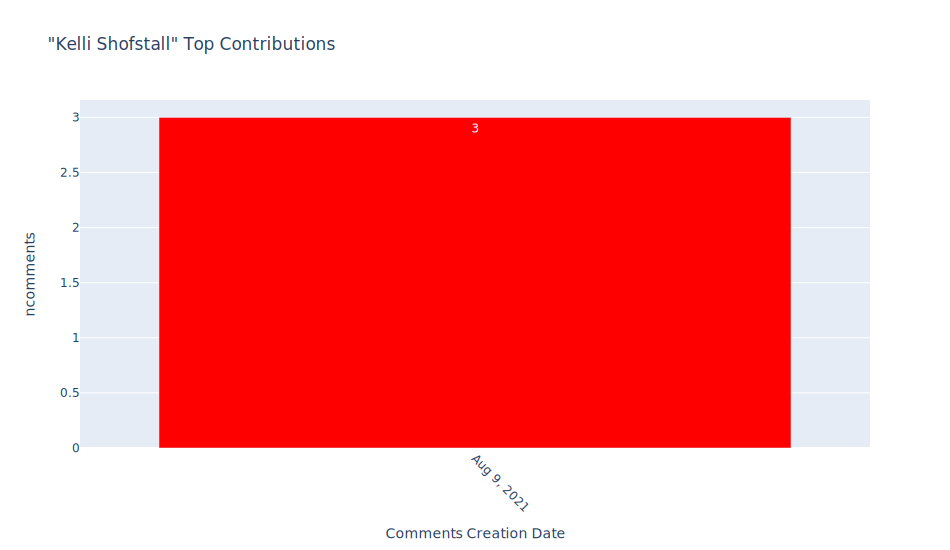

In [64]:
helpers.contr_peaks(df_comments, "Kelli Shofstall", n=3, threshold=0)

In [65]:
df_comments.query(" username == 'Daler Halimov' ").comment.value_counts().head(60)

amber is a liar, hypocrite, an abuser and an narcissist! she’s a monster who wants attention because she’s nothing without it! i hope johnny will get justice and she what she deserves!                                                                                                                                                                                                                                                                          1
she was arrested for dv against her girlfriend in 2009 and spent a night in jail. also she admitted on court papers that she abused johnny. and she dropped the case! she's a hypocrite and a liar. she uses metoo movement and people actually believe her! that's messed up!                                                                                                                                                                                    1
amber heard was arrested and spend a night in jail for domestic violence against her girlfriend.

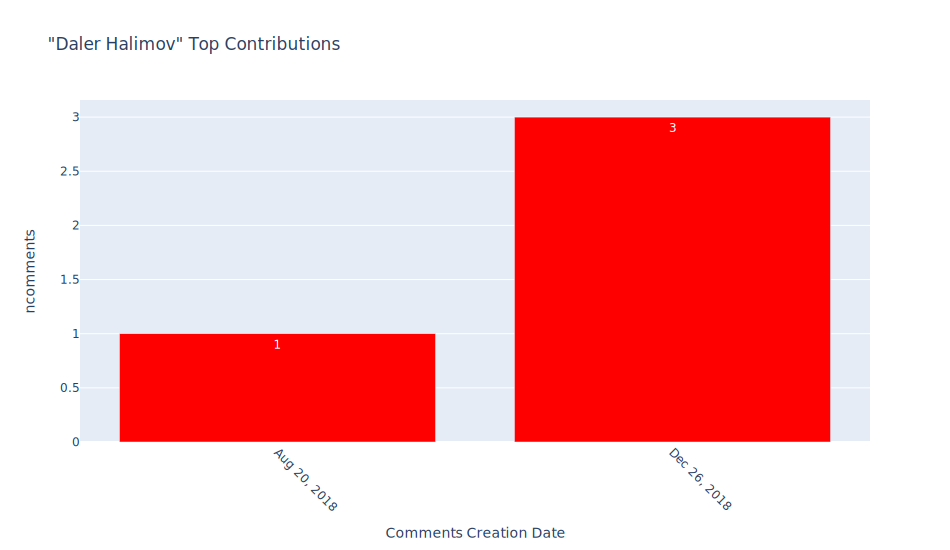

In [66]:
helpers.contr_peaks(df_comments, "Daler Halimov", n=3, threshold=0)

In [67]:
df_comments.query(" username == 'Freddie Mercury' ").comment.value_counts().head()

amber heard is a liar, and johnny depp doesn’t deserve to be punished for her stupidity    3
amber heard is a pathological lying bitch                                                  1
Name: comment, dtype: int64

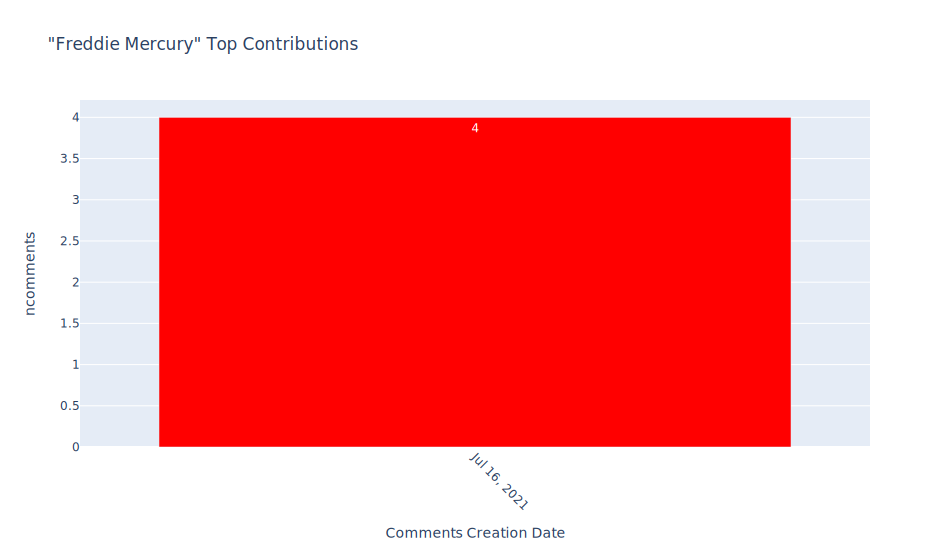

In [68]:
helpers.contr_peaks(df_comments, "Freddie Mercury", n=3, threshold=0)

In [69]:
df_comments.query(" username == 'Onyx Psudeonym' ").comment.value_counts().head(60)

amber heard is a monster, johnny depp was tortured and then punished                                                                     1
abuse happens to both genders, johhny should not be punished for being abused                                                            1
amber can go to hell. punishing johnny because she got bored torturing and leeching from him, don't let her move on to another victim    1
Name: comment, dtype: int64

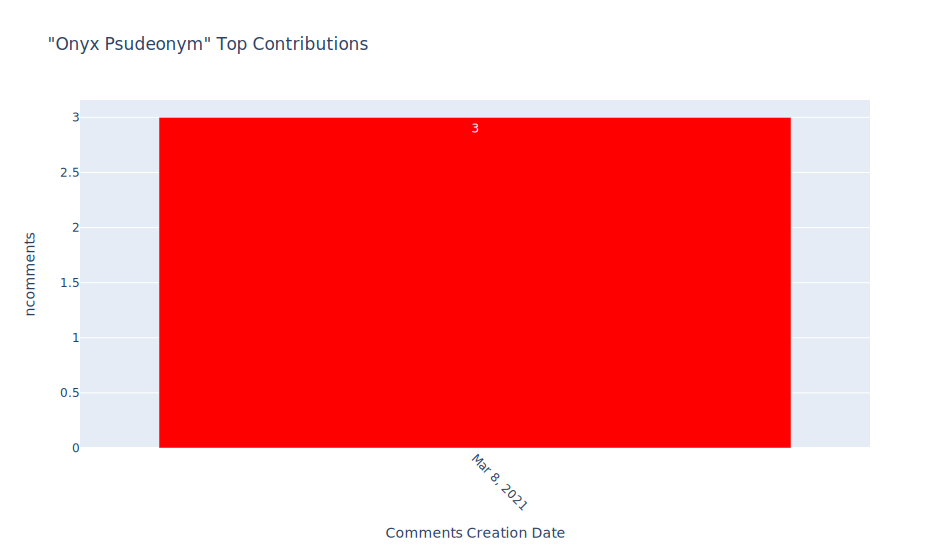

In [70]:
helpers.contr_peaks(df_comments, "Onyx Psudeonym", n=3, threshold=0)

In [71]:
df_comments.query(" username == 'Sofia Derzjavina' ").comment.value_counts().head()

i’m signing because johnny is being punished for literally being the victim of a domestic abuser. the system is fucked. they literally reward the abusers and punish the victims. johnny does not deserve this.    1
he is punished for being the victim, and that is fucked.                                                                                                                                                           1
he is the victim                                                                                                                                                                                                   1
she is the abuser.                                                                                                                                                                                                 1
Name: comment, dtype: int64

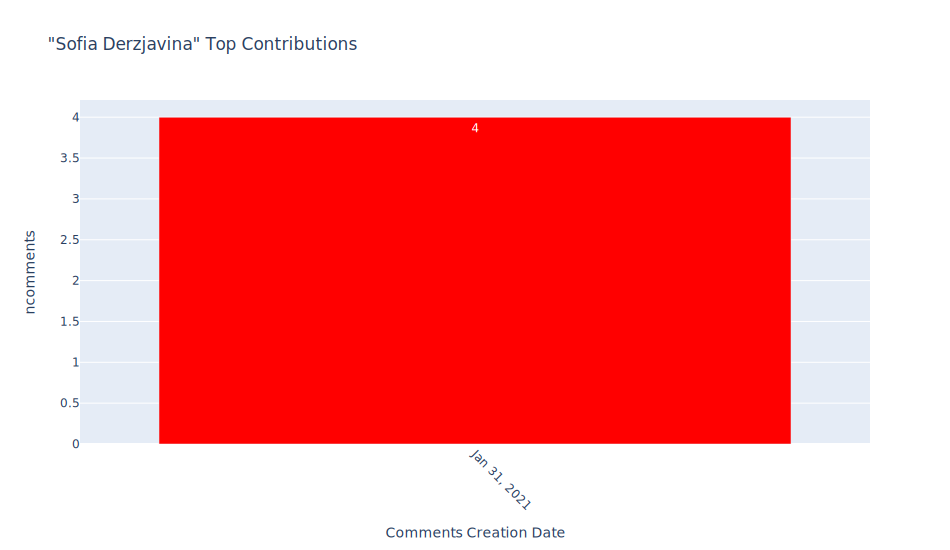

In [72]:
helpers.contr_peaks(df_comments, "Sofia Derzjavina", n=3, threshold=0)

<br>

<a id='kill_death'></a>
>>## Death, Die, Kill & Murder
> <ul>
 <li><a href="#all_threat">All Threat</a></li>
 <li><a href="#kill_death"><b>Kill & Death</b></a></li>
 <li><a href="#hell_burn">Hell & Burn</a></li>
 <li><a href="#crime_jail">Crime & Jail</a></li>
 <li><a href="#threat_users">Threat Users Contributions</a></li>
 </ul>

In [73]:
death_kill = {'death to', 'die amber', 'catch covid and die', 'she dies', 'and to die', 'die amber', 
              'will murder', 'amber can die', 'kill yourself', 'kill herself', 'kill amber',
              'be killed', 'killher'}

In [74]:
df_death = df_comments[df_comments.comment.str.contains('|'.join(death_kill))]
print(f'{df_death.shape[0]} contributions, on {df_death.petition_slug.nunique()} Slugs, made by {df_death.username.nunique()} Users')
df_death

16 contributions, on 7 Slugs, made by 16 Users


id                                            comment  \
19630  796163357                        eat shit and die amber :)))   
17477  808945989                       amber heard should be killed   
17388  808967425  no one should be paying this abusive cunt anyt...   
24844  809011719  johnny depp deserves an apology and his job ba...   
17186  809013940  i hate amber heard , does can that woman ruin ...   
16701  809205960                                            killher   
1373   809352488                  amber heard can kill kill herself   
8052   809355573  i love dc comics and want to watch this movie,...   
6646   809402466  if this doesnt work i'm hiring an assasin to k...   
5317   809467045  obviously, i believe that what she did was wro...   
23347  810064883  amber heard is an asshole go kill yourself amb...   
22715  812091612  amber heard is a bitch and needs to catch covi...   
27219  812714191  in this house we hate abusers! death to her ca...   
2684   812917720  because amber heard is a bitch who deserves to...   
22131  815913941  amber is a lying bitch and i swear if she fuck...   
9478   820913914  amber heard is not telling the truth! she cut ...   

      commentable_id  likes               role                created_at  \
19630       20196023      1            comment 2020-06-20 18:47:17+00:00   
17477       20196023      0            comment 2020-11-09 09:31:02+00:00   
17388       20196023      0            comment 2020-11-09 17:40:08+00:00   
24844       20186707      0            comment 2020-11-10 07:57:13+00:00   
17186       20196023      1            comment 2020-11-10 09:15:39+00:00   
16701       20196023      1            comment 2020-11-13 02:19:37+00:00   
1373        25840259      1            comment 2020-11-17 03:30:35+00:00   
8052        14451136      0            comment 2020-11-17 06:33:34+00:00   
6646        14451136      1            comment 2020-11-18 14:11:09+00:00   
5317        14451136      2  comment_dashboard 2020-11-19 23:40:47+00:00   
23347       20186707      2            comment 2020-12-03 20:45:07+00:00   
22715       20186707      3            comment 2021-01-14 16:17:23+00:00   
27219       25706549      0            comment 2021-01-27 17:54:12+00:00   
2684        25717146      0            comment 2021-01-31 19:20:45+00:00   
22131       20186707      0            comment 2021-03-29 07:05:33+00:00   
9478        25710217      0            comment 2021-06-27 16:01:55+00:00   

          user_id                   username       user_city  \
19630  1120075643  jdiehdio blacklivesmatter  Black Mountain   
17477   881143615                 Joe Jostar    Johannesburg   
17388   446094746         Victoria Schlobohm        Palatine   
24844  1096863424                    Rat God        Brisbane   
17186  1163403501             Meeku 11032008           Delhi   
16701  1150848317             Natasha Karpov       Riverside   
1373   1152437806              Dndncjc Jdjdm        Roseburg   
8052    310539037             Joseph Montiel      Sacramento   
6646    947698933                Joseph Titi   Richmond Hill   
5317   1165033663               Liam Bottoms         Wasilla   
23347   954805870                  Super man         Markham   
22715  1026478556             Matthew Pirtle     Stockbridge   
27219   313201115                    Selin s        İstanbul   
2684   1162255604            Alexander Huang        New York   
22131  1161824120               Lucy Corbett        Brisbane   
9478     30554900               Dana Welcker  Fleming Island   

      user_country_code user_locale  \
19630                US       en-US   
17477                ZA       en-GB   
17388                US       en-US   
24844                AU       en-AU   
17186                IN       en-IN   
16701                US       en-US   
1373                 US       en-US   
8052                 US       en-US   
6646                 CA       en-CA   
5317                 US       en-U

In [75]:
df_death.petition_slug.value_counts()

l-oréal-remove-amber-heard-as-l-oreal-spokesperson                 5
justice-for-johnny-depp                                            4
dc-entertainment-remove-amber-heard-from-aquaman-2                 3
warner-brothers-emilia-clarke-to-replace-amber-heard-on-aquaman    1
warner-bros-pictures-justice-for-depp                              1
warner-brothers-give-johnny-deep-his-roles-back                    1
warner-brothers-save-johnny-depp                                   1
Name: petition_slug, dtype: int64

In [76]:
df_death.user_country_code.value_counts()

US    9
AU    2
CA    2
ZA    1
IN    1
TR    1
Name: user_country_code, dtype: int64

In [77]:
df_death.user_locale.value_counts()

en-US    10
en-AU     2
en-CA     2
en-GB     1
en-IN     1
Name: user_locale, dtype: int64

In [78]:
df_death.user_city.value_counts()

Brisbane          2
Black Mountain    1
Johannesburg      1
Palatine          1
Delhi             1
Riverside         1
Roseburg          1
Sacramento        1
Richmond Hill     1
Wasilla           1
Markham           1
Stockbridge       1
İstanbul          1
New York          1
Fleming Island    1
Name: user_city, dtype: int64

In [79]:
df_death.role.value_counts()

comment              15
comment_dashboard     1
Name: role, dtype: int64

In [80]:
df_death.status_manual.value_counts()

against    16
Name: status_manual, dtype: int64

### A Heat Map for the Death Comments 

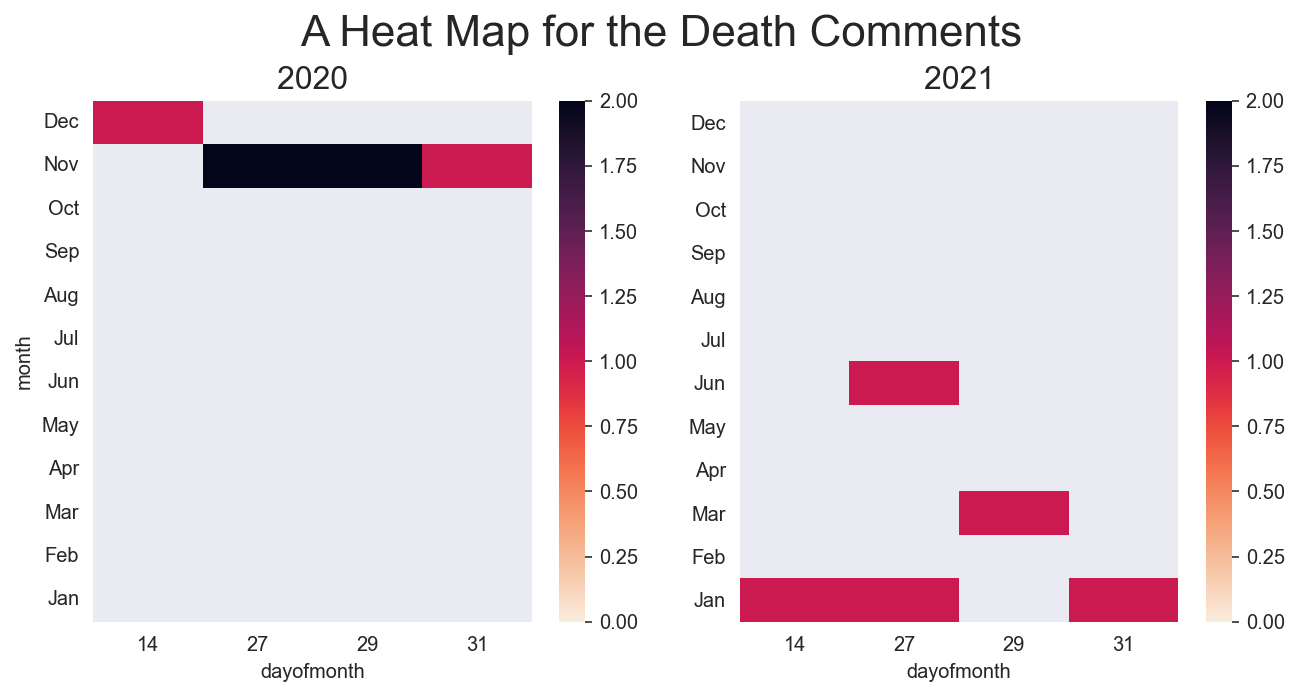

In [81]:
death_daily = df_death.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

title = 'A Heat Map for the Death Comments'
helpers.facet_heat(death_daily, title, n_col=2, vmax=2)

### Death Comments Peak Dates

In [82]:
death_dates = df_death.groupby(['date']).agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'}).sort_values('ncomments', ascending=False)

death_dates.head(15)

date  ncomments  likes
1  2020-11-09          2      0
2  2020-11-10          2      1
4  2020-11-17          2      1
0  2020-06-20          1      1
3  2020-11-13          1      1
5  2020-11-18          1      1
6  2020-11-19          1      2
7  2020-12-03          1      2
8  2021-01-14          1      3
9  2021-01-27          1      0
10 2021-01-31          1      0
11 2021-03-29          1      0
12 2021-06-27          1      0

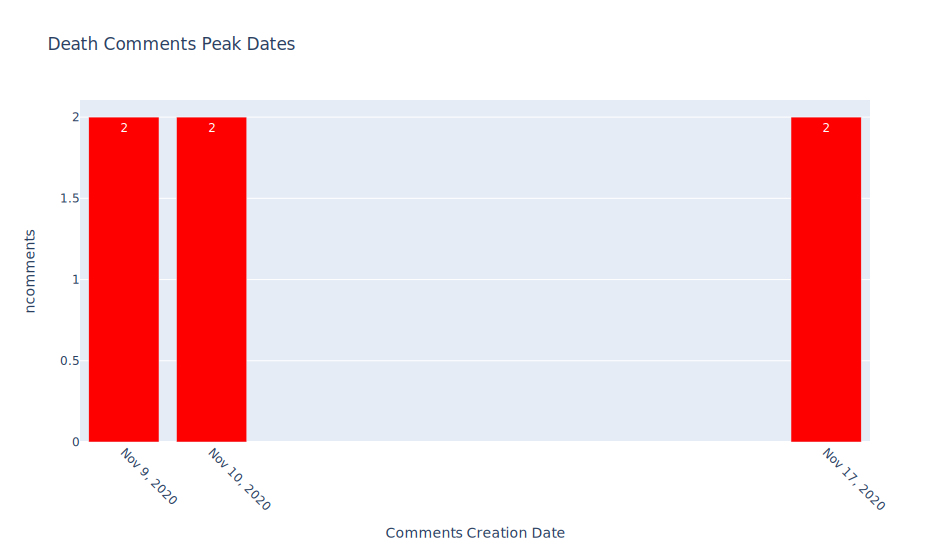

In [83]:
helpers.bar_peaks(death_dates[['date', 'ncomments']].head(3), 
                  'Death Comments Peak Dates')

# Death Comments

In [84]:
df_death.comment.value_counts()

eat shit and die amber :)))                                                                                                                                                     1
amber heard should be killed                                                                                                                                                    1
no one should be paying this abusive cunt anything. hope you die amber heard ✌                                                                                                 1
johnny depp deserves an apology and his job back from warner bros. amber can die for all we care.                                                                               1
i hate amber heard , does can that woman ruin every mans lives, i hope she dies quickly and goes to hell , to hell with you , amber heard !!!!!!!!!                             1
killher                                                                                                       

# Top Users Commented with Death keywords

In [85]:
df_death.username.value_counts()

jdiehdio blacklivesmatter    1
Joe Jostar                   1
Victoria Schlobohm           1
Rat God                      1
Meeku 11032008               1
Natasha Karpov               1
Dndncjc Jdjdm                1
Joseph Montiel               1
Joseph Titi                  1
Liam Bottoms                 1
Super man                    1
Matthew Pirtle               1
Selin s                      1
Alexander Huang              1
Lucy Corbett                 1
Dana Welcker                 1
Name: username, dtype: int64

In [86]:
threat_users = threat_users | set(df_death.username)

# die amber

In [87]:
user = "jdiehdio blacklivesmatter"
df_comments.query(" username == @user ").comment.value_counts().head()

eat shit and die amber :)))    1
Name: comment, dtype: int64

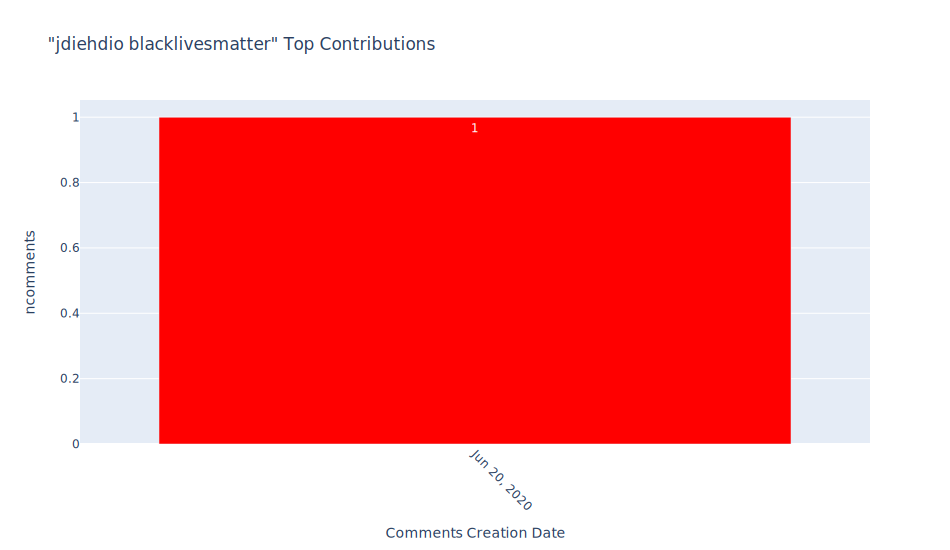

In [88]:
helpers.contr_peaks(df_comments, "jdiehdio blacklivesmatter", n=3, threshold=0)

# amber heard should be killed

In [89]:
user = "Joe Jostar"
df_comments.query(" username == @user ").comment.value_counts().head()

amber heard should be killed    1
Name: comment, dtype: int64

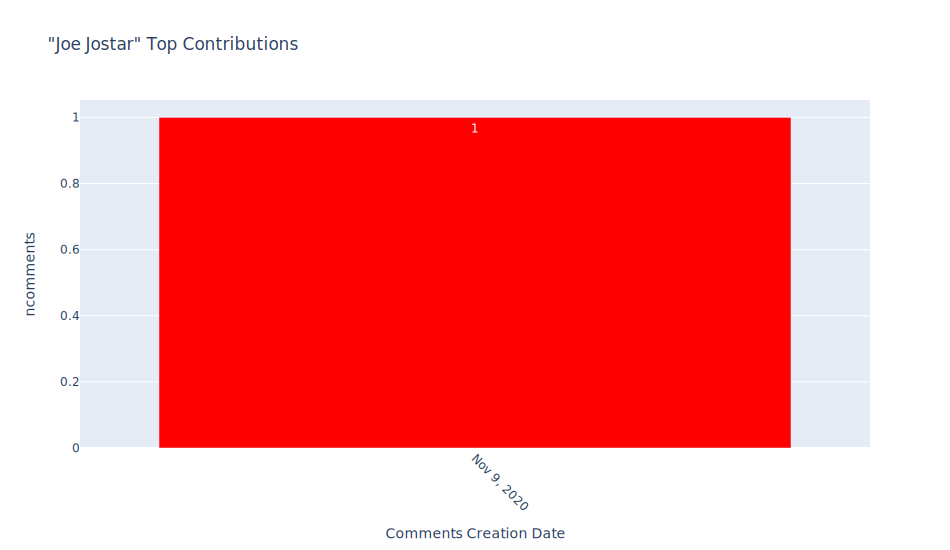

In [90]:
helpers.contr_peaks(df_comments, "Joe Jostar", n=3, threshold=0)

In [91]:
user = "Dana Welcker"
df_comments.query(" username == @user ").comment.value_counts().head()

amber heard is not telling the truth! she cut his finger off and antagonized him shortly after his mother’s  death to get money and fame for herself.    1
Name: comment, dtype: int64

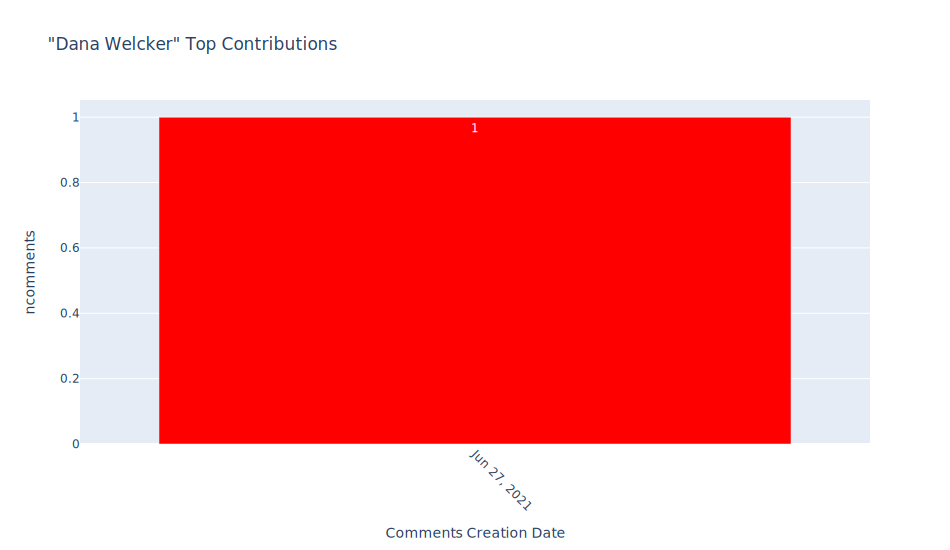

In [92]:
helpers.contr_peaks(df_comments, "Dana Welcker", n=3, threshold=0)

# murder

In [93]:
user = "Lucy Corbett"
df_comments.query(" username == @user ").comment.value_counts().head()

amber is a lying bitch and i swear if she fucking wins i will murder something.    1
Name: comment, dtype: int64

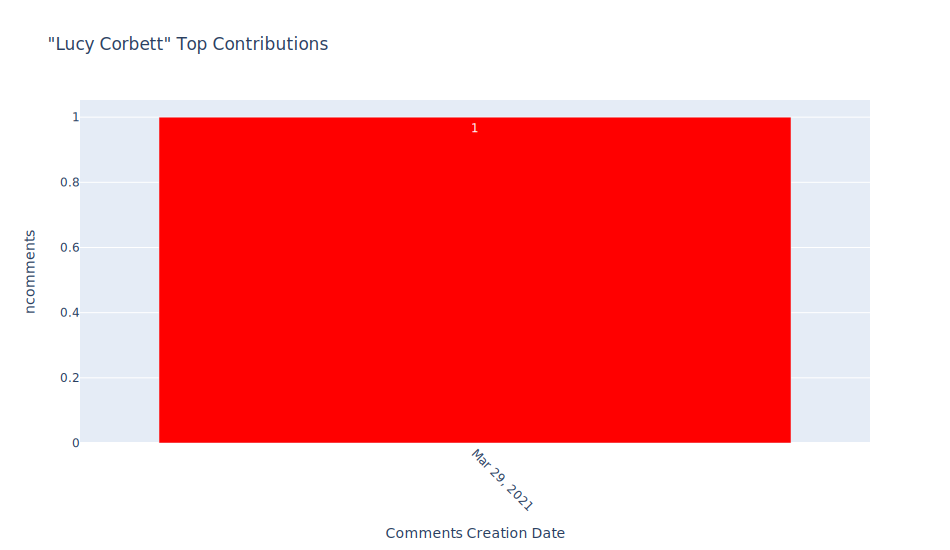

In [94]:
helpers.contr_peaks(df_comments, "Lucy Corbett", n=3, threshold=0)

# death penalty

In [95]:
user = "your king"
df_comments.query(" username == @user ").comment.value_counts().head()

give heard atleast 10 years in prison and if not the death penalty!    1
Name: comment, dtype: int64

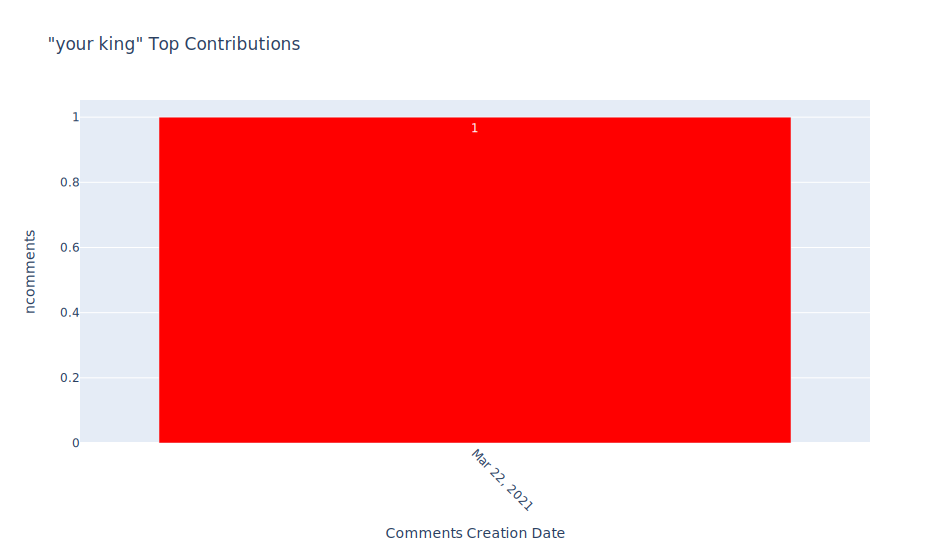

In [96]:
helpers.contr_peaks(df_comments, "your king", n=3, threshold=0)

# die and burn in hell

In [97]:
user = "Alexander Huang"
df_comments.query(" username == @user ").comment.value_counts().head()

because amber heard is a bitch who deserves to have her career ruined and to die and burn in hell    1
Name: comment, dtype: int64

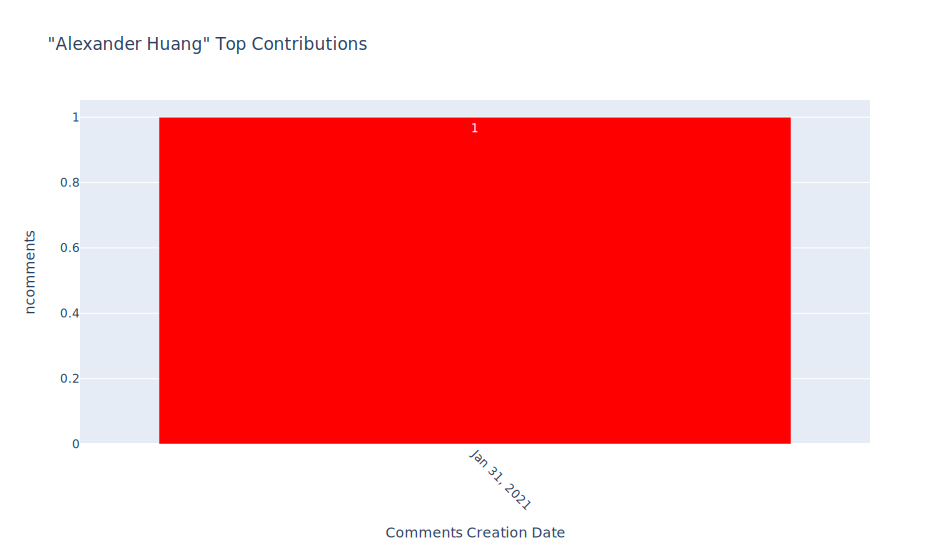

In [98]:
helpers.contr_peaks(df_comments, "Alexander Huang", n=3, threshold=0)

# death to her career

In [99]:
user = "Selin s"
df_comments.query(" username == @user ").comment.value_counts().head()

in this house we hate abusers! death to her career, she deserves to be in jail!!    1
Name: comment, dtype: int64

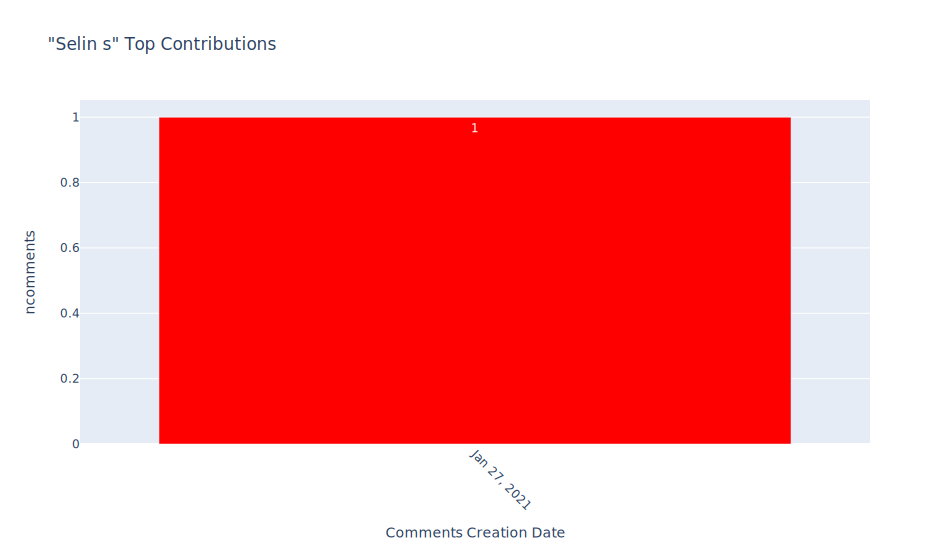

In [100]:
helpers.contr_peaks(df_comments, "Selin s", n=3, threshold=0)

# catch covid and die

In [101]:
user = "Matthew Pirtle"
df_comments.query(" username == @user ").comment.value_counts().head()

amber heard is a bitch and needs to catch covid and die. preferably after she’s been proven in a court of law to be the gold-digging whore of babylon we all know her to be.    1
Name: comment, dtype: int64

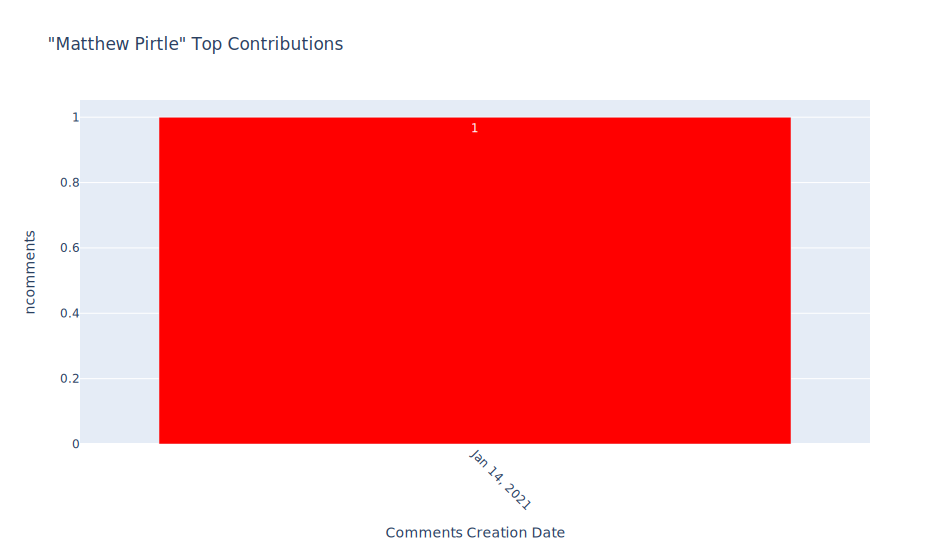

In [102]:
helpers.contr_peaks(df_comments, "Matthew Pirtle", n=3, threshold=0)

# kill yourself amber

In [103]:
user = "Super man"
df_comments.query(" username == @user ").comment.value_counts().head()

amber heard is an asshole go kill yourself amber!!!    1
Name: comment, dtype: int64

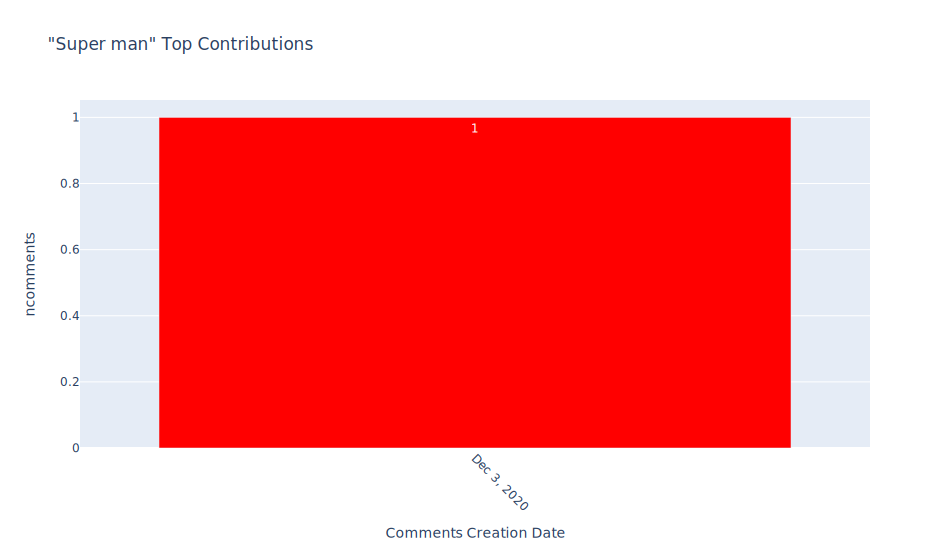

In [104]:
helpers.contr_peaks(df_comments, "Super man", n=3, threshold=0)

In [105]:
user = "Liam Bottoms"
df_comments.query(" username == @user ").comment.value_counts().head()

obviously, i believe that what she did was wrong, but i don't hope she dies for it. that is a little much.    1
Name: comment, dtype: int64

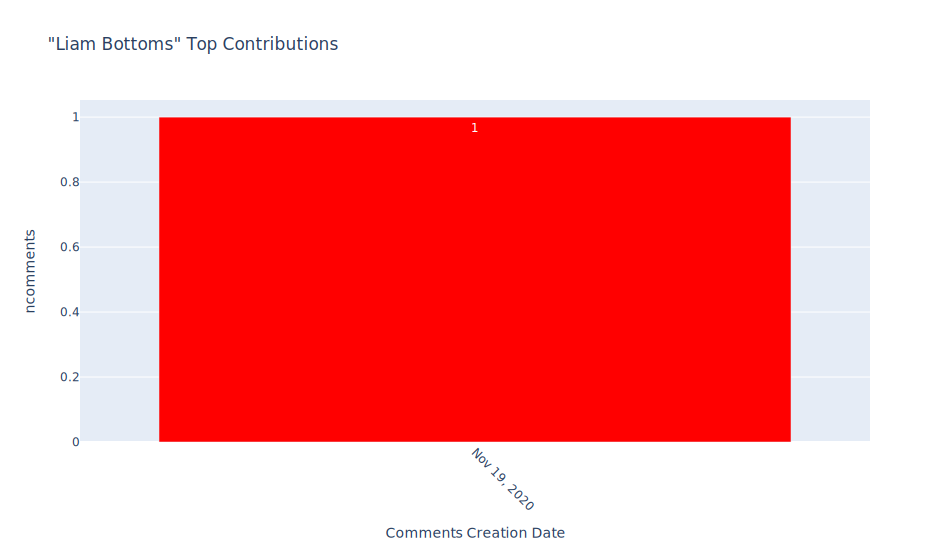

In [106]:
helpers.contr_peaks(df_comments, "Liam Bottoms", n=3, threshold=0)

# Kill Amber

In [107]:
user = "Joseph Titi"
df_comments.query(" username == @user ").comment.value_counts().head()

if this doesnt work i'm hiring an assasin to kill amber    1
this is the second petition i'm signing for depp           1
Name: comment, dtype: int64

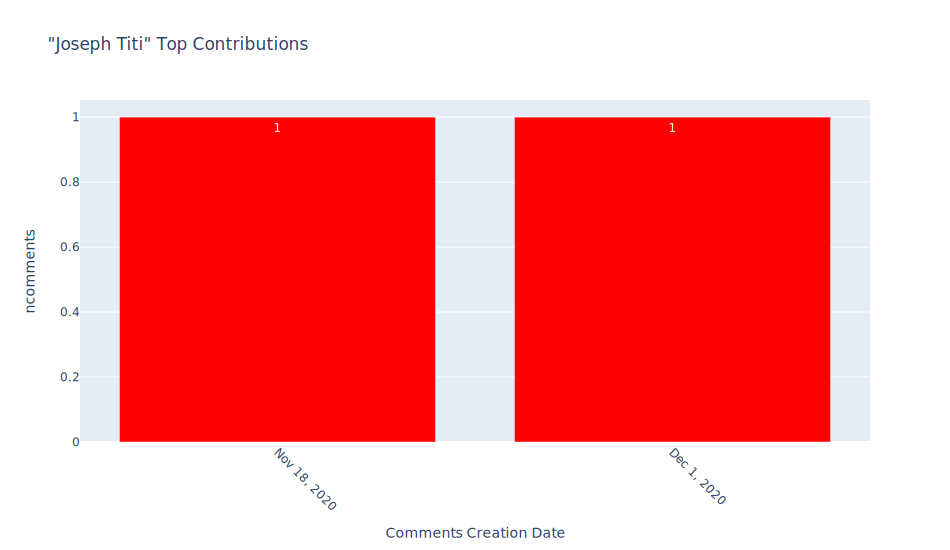

In [108]:
helpers.contr_peaks(df_comments, "Joseph Titi", n=3, threshold=0)

In [109]:
user = "Joseph Montiel"
df_comments.query(" username == @user ").comment.value_counts().head()

i love dc comics and want to watch this movie, but not with amber heard as queen of atlantis. maybe if she dies at the very beginning.    1
Name: comment, dtype: int64

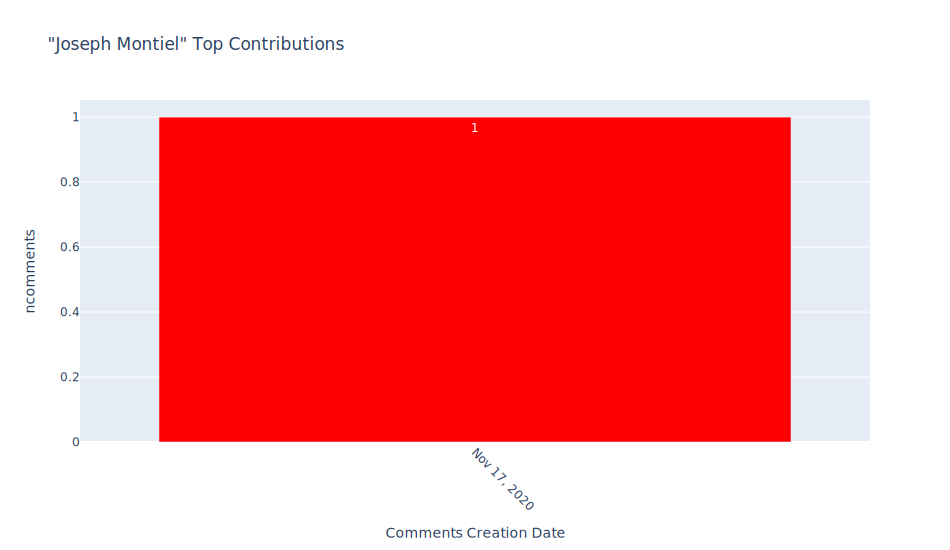

In [110]:
helpers.contr_peaks(df_comments, "Joseph Montiel", n=3, threshold=0)

# amber heard can kill herself

In [111]:
user = "Dndncjc Jdjdm"
df_comments.query(" username == @user ").comment.value_counts().head()

amber heard can kill kill herself    1
Name: comment, dtype: int64

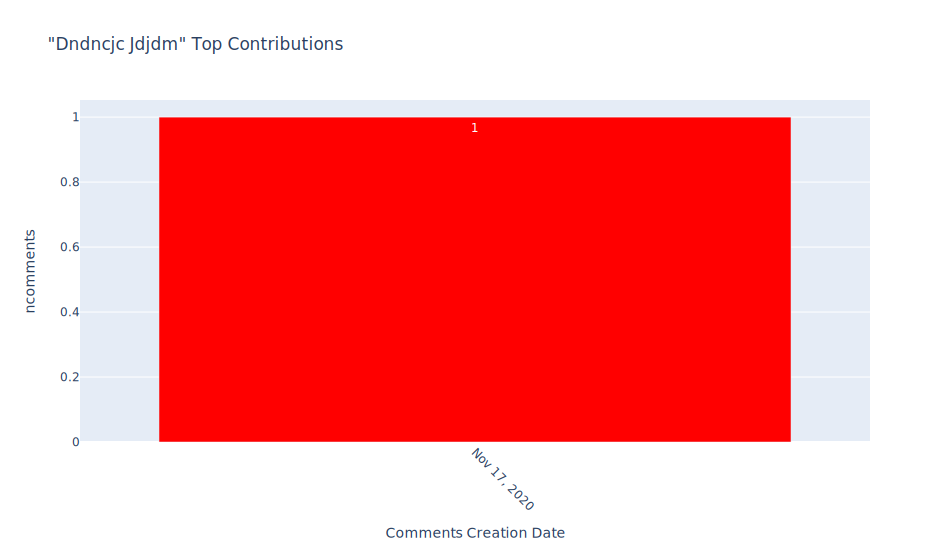

In [112]:
helpers.contr_peaks(df_comments, "Dndncjc Jdjdm", n=3, threshold=0)

# KillHer

In [113]:
user = "Natasha Karpov"
df_comments.query(" username == @user ").comment.value_counts().head()

killher    1
Name: comment, dtype: int64

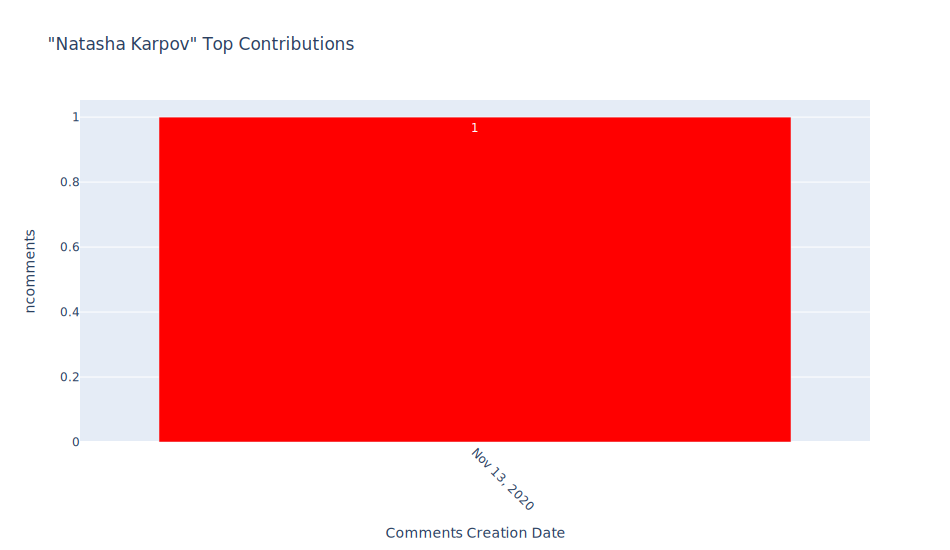

In [114]:
helpers.contr_peaks(df_comments, "Natasha Karpov", n=3, threshold=0)

# i hope she dies quickly and goes to hell

In [115]:
user = "Meeku 11032008"
df_comments.query(" username == @user ").comment.value_counts().head()

i hate amber heard , does can that woman ruin every mans lives, i hope she dies quickly and goes to hell , to hell with you , amber heard !!!!!!!!!                                    1
i know that he is just a sweet little marshmellow and cant be a wife beater even his ex wifes have said that he is a cute little potato and didnt hurt them so amber heard is lying    1
Name: comment, dtype: int64

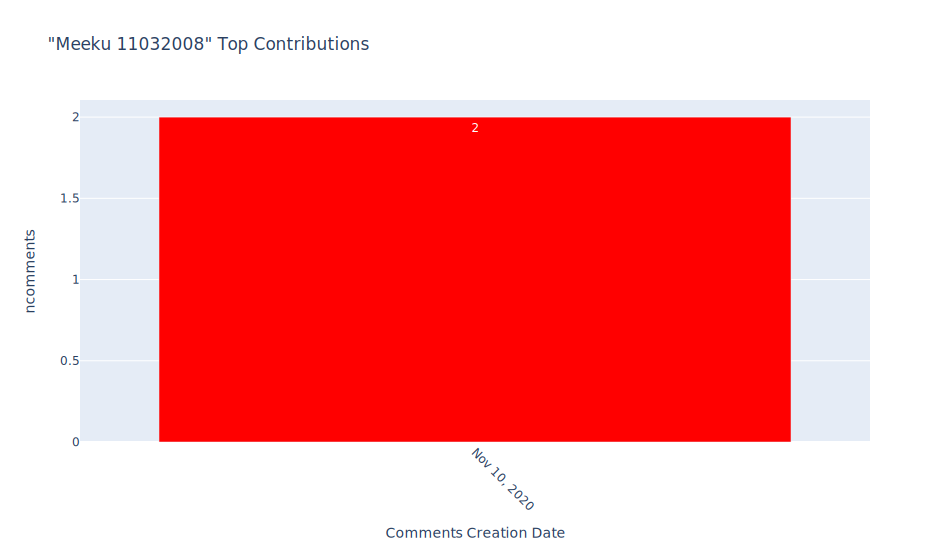

In [116]:
helpers.contr_peaks(df_comments, "Meeku 11032008", n=3, threshold=0)

# amber can die

In [117]:
user = "Rat God"
df_comments.query(" username == @user ").comment.value_counts().head()

johnny depp deserves an apology and his job back from warner bros. amber can die for all we care.    1
Name: comment, dtype: int64

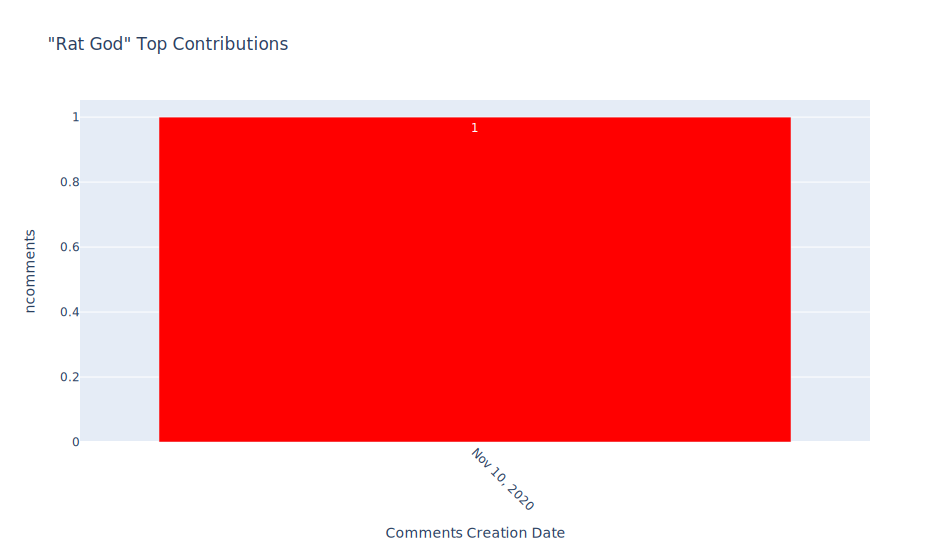

In [118]:
helpers.contr_peaks(df_comments, "Rat God", n=3, threshold=0)

# hope you die amber heard

In [119]:
user = "Victoria Schlobohm"
df_comments.query(" username == @user ").comment.value_counts().head()

no one should be paying this abusive cunt anything. hope you die amber heard ✌    1
Name: comment, dtype: int64

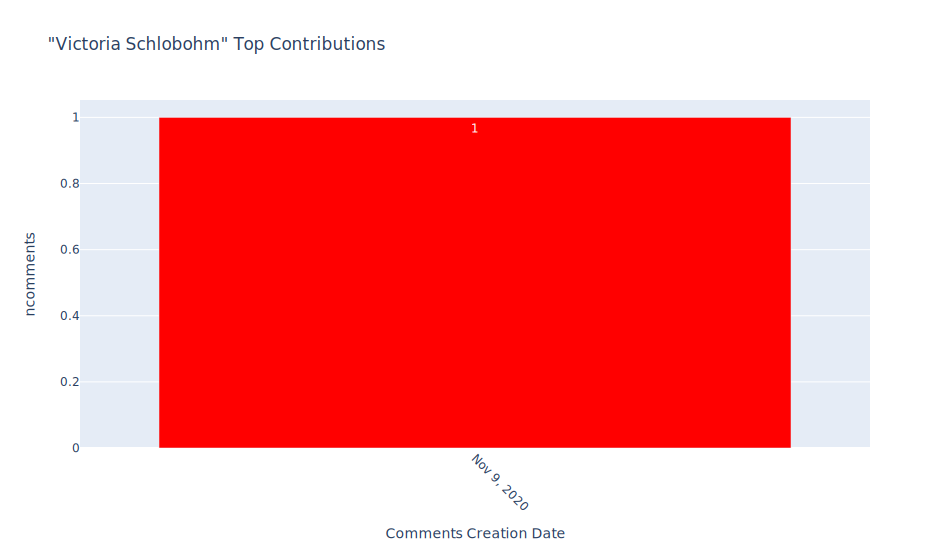

In [120]:
helpers.contr_peaks(df_comments, "Victoria Schlobohm", n=3, threshold=0)

<br>

<a id='hell_burn'></a>
>>## Hell & Burn
> <ul>
 <li><a href="#all_threat">All Threat</a></li>
 <li><a href="#kill_death">Kill & Death</a></li>
 <li><a href="#hell_burn"><b>Hell & Burn</b></a></li>
 <li><a href="#crime_jail">Crime & Jail</a></li>
 <li><a href="#threat_users">Threat Users Contributions</a></li>
 </ul>

In [121]:
burn_hell = {'burn the witch', 'she burns', 'blacklisted and burned', 'in hell', 'burn in hell', 'burns in hell', 
             'to hell', 'go to hell', 'burnt pig', 'burn down', 'to hell', 'tohell', 'of hell', 
             'rot in b movie hell', 'demon from hell', 'deserves hell'}

In [122]:
df_burn = df_comments[df_comments.comment.str.contains('|'.join(burn_hell))]
print(f'{df_burn.shape[0]} contributions, on {df_burn.petition_slug.nunique()} Slugs, made by {df_burn.username.nunique()} Users')
df_burn


57 contributions, on 12 Slugs, made by 56 Users


id                                            comment  \
21030  774758050  this woman does not deserve to be a spokespers...   
20908  775012419                       remove her!!! burn the witch   
20636  775278763                        let these women rot in hell   
20553  775324595  i don’t like narcissistic monsters and refuse ...   
26336  776015891  i have watched johnny depp forever and i have ...   
20022  784421665  what a despicable example of female empowermen...   
19596  797530974  this woman should be imprisoned. and she even ...   
19452  800199990  amber heard is a fucking bitch who lied and ha...   
19004  803831843                    fuck amber i hope she burns     
26051  808364743  justice will be served. may this man have his ...   
26026  808779022  amber heard is going to hell for this \nfuck w...   
18540  808799294  a disgusting person. a disgrace to the human r...   
17995  808866187                                she belongs in hell   
3889   808870436              amber heard is the embodiment of hell   
13456  808870453              amber heard is the embodiment of hell   
17956  808872613            voting because liars should rot in hell   
17871  808880694           she can have a fun time rotting in hell.   
13241  808906484  because amber heard is the devil. johnny depp ...   
17691  808908505  she is an abuser and doesn’t deserve to contin...   
25072  808965334               amber heard deserves to burn in hell   
17284  808994213          go to hell amber heard. #justiceforjohnny   
17186  809013940  i hate amber heard , does can that woman ruin ...   
24760  809040920  what the hell amber heard deserves being treat...   
17062  809062719              yo this girl can go to hell, real pos   
582    809069127  i refuse to watch any movies that feature this...   
24142  809221567  im signing bc amber heard is a stupid bitch wh...   
16469  809294252                                    lies go to hell   
8731   809342644  johnny depp ain’t diserve this bullshit, and s...   
8721   809342890                                   go to hell amber   
8096   809354892       because amber heard deserves to rot in hell.   
8086   809355051                   because bitch needs to burn down   
8007   809356259  fuck amber heard, everyone knows she’s a lying...   
7998   809356428  i am a survivor of domestic violence. i can't ...   
7990   809356602                                     burn the witch   
16406  809357624  fuck amber, abuser should rot in hell. fuck lo...   
7602   809367894                                     burn the witch   
7490   809370684  amber needs to be stopped if depp gets his rol...   
7269   809376026  she is an abuser no way in hell she can be in ...   
6555   809407270  justice above gender ! i wish all those funded...   
6541   809408450  rus\nактёр, что ведёт себя, как последняя твар...   
6445   809413653  she doesn’t deserve to have a platform. she’s ...   
23758  809444018  i’m signing because johnny depp is one of my f...   
26502  809633324  if johnny doesn't get rehired i am going to be...   
26673  810020082  johnny depp is innocent that dump ass  judge d...   
23331  810122794  i’m signing because johnny depp is my literall...   
23109  810900477      amber should rot in hell. he deserves justice   
2252   811292997        she’s a man abuser and is a demon from hell   
22921  811344002  ihope that bitch is fucking routing in hell. j...   
22806  811639028  if i will not seen him in those movies i wont ...   
2684   812917720  because amber heard is a bitch who deserves to...   
11208  814684477  amber can go to hell. punishing johnny because...   
22111  816269839  i’m all in the #metoo movement but just becaus...   
21694  821507071  i have watched ah and i believe she used depp ...   
2466   821953832  amber heard deserves hell for what she did to ...   
14818  821977012  it’s time we believed the victim. i’m so outra...   
11384  823193055  i'm signing this bec

In [123]:
df_burn.petition_slug.value_counts()

l-oréal-remove-amber-heard-as-l-oreal-spokesperson                                                          18
justice-for-johnny-depp                                                                                     13
dc-entertainment-remove-amber-heard-from-aquaman-2                                                          13
warner-brothers-give-johnny-deep-his-roles-back                                                              3
warner-brothers-keep-johnny-depp-as-grindelwald                                                              2
warner-brothers-boycott-aquaman-2-and-l-oreal                                                                2
hollywood-boycott-aquaman-2-amber-heard                                                                      1
disney-get-johnny-depp-back-in-pirates-6                                                                     1
the-royal-courts-of-justice-london-justice-for-johnny-depp                                                   1
w

In [124]:
df_burn.user_country_code.value_counts()

US    31
IN     5
AU     5
CA     3
GB     2
PH     1
LK     1
MT     1
GR     1
MY     1
EG     1
PK     1
RU     1
AE     1
MK     1
JP     1
Name: user_country_code, dtype: int64

In [125]:
df_burn.user_locale.value_counts()

en-US    36
en-GB     6
en-IN     5
en-AU     5
en-CA     4
ru-RU     1
Name: user_locale, dtype: int64

In [126]:
df_burn.user_city.value_counts()

Spokane            2
Calgary            2
Wigan              1
Dubai              1
tbilisi            1
Kuala Lumpur       1
Atlanta            1
Princeton          1
Assiut             1
Karachi            1
Ozersk             1
Beaumont           1
Dayton             1
Kansas City        1
Bossier City       1
Peoria             1
Bronx              1
Bitola             1
Bhopal             1
New York           1
San Diego          1
Tsunashimanishi    1
Havana             1
Southington        1
Novato             1
Omaha              1
Diamondhead        1
Jaipur             1
Orange             1
newtown            1
Carmona            1
Regina             1
Bixby              1
None               1
Patna              1
Long Beach         1
East Wenatchee     1
Colombo            1
Toms River         1
ardmore            1
Widdrington        1
Novi               1
Sydney             1
Delhi              1
Los Angeles        1
Manly              1
Shrewsbury         1
Sacramento   

In [127]:
df_burn.role.value_counts()

comment              55
comment_dashboard     2
Name: role, dtype: int64

In [128]:
df_burn.status_manual.value_counts()

against    57
Name: status_manual, dtype: int64

### A Heat Map for the "Burn & Hell" Comments 

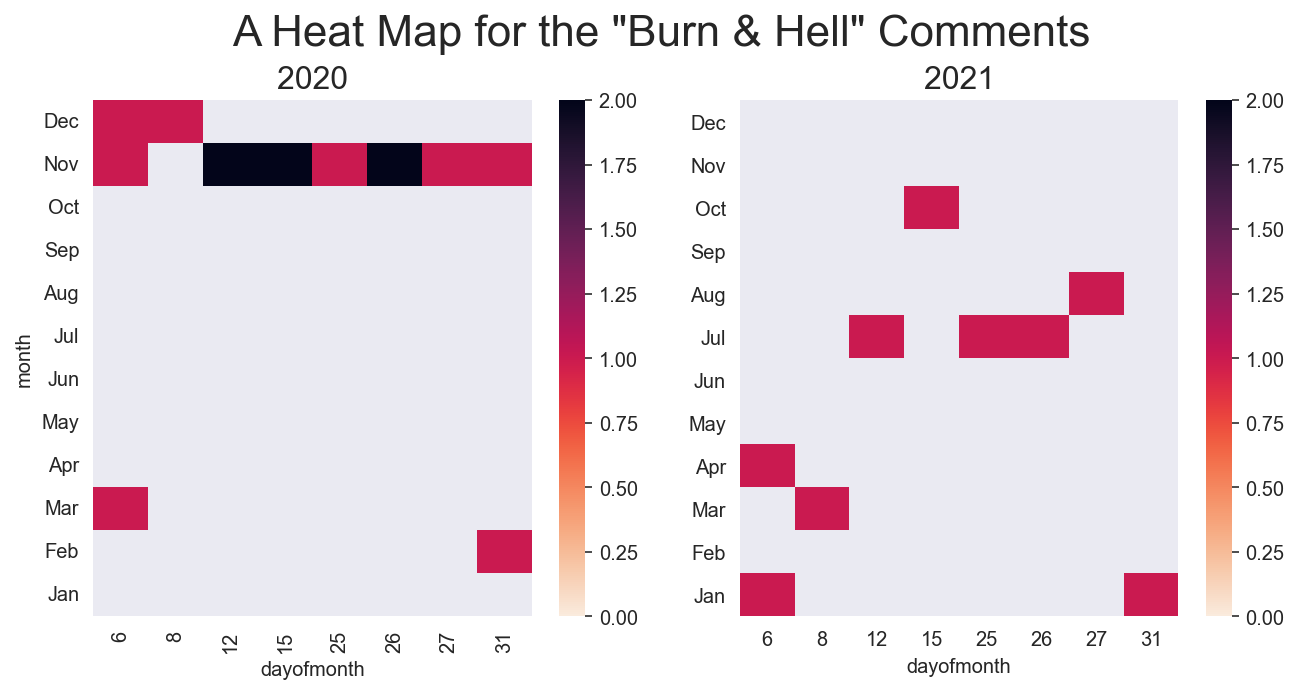

In [129]:
burn_daily = df_burn.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

title = 'A Heat Map for the "Burn & Hell" Comments'
helpers.facet_heat(burn_daily, title, n_col=2, vmax=2)

### "Burn & Hell" Comments Peak Dates

In [130]:
burn_dates = df_burn.groupby(['date']).agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'}).sort_values('ncomments', ascending=False)

burn_dates.head(15)

date  ncomments  likes
18 2020-11-17          9      7
11 2020-11-08          7      1
13 2020-11-10          4      3
19 2020-11-18          3      7
17 2020-11-16          2      2
10 2020-11-06          2      0
32 2021-07-25          1      0
31 2021-07-12          1      0
30 2021-04-06          1      3
29 2021-03-08          1      0
28 2021-01-31          1      0
27 2021-01-06          1      0
21 2020-11-24          1      1
33 2021-07-26          1      1
26 2020-12-31          1      1

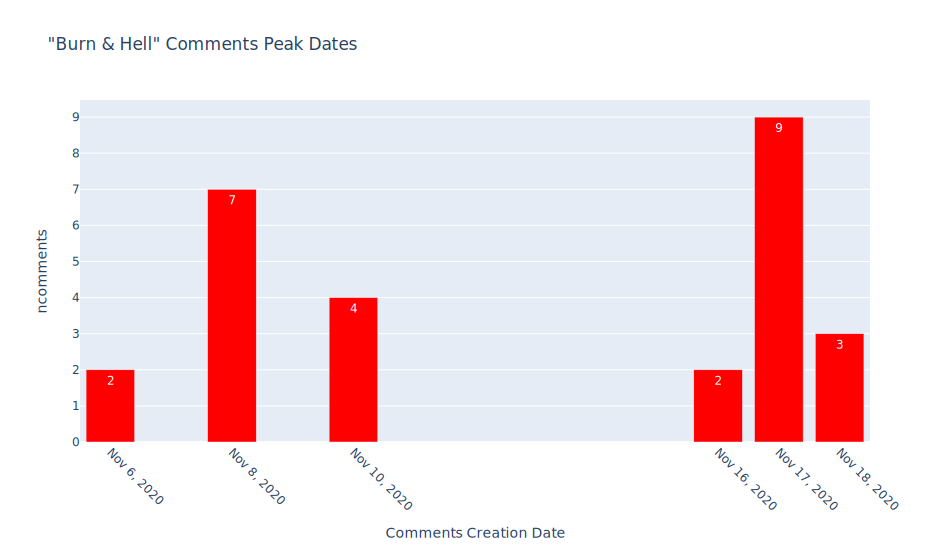

In [131]:
helpers.bar_peaks(burn_dates[['date', 'ncomments']].head(6), 
                  '"Burn & Hell" Comments Peak Dates')

# "Burn & Hell" Comments

In [132]:
df_burn.comment.value_counts()

burn the witch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        2
amber heard is the embodiment of hell                                                                                                                                                                                                                                           

# Top Users Commented with "Burn & Hell" keywords

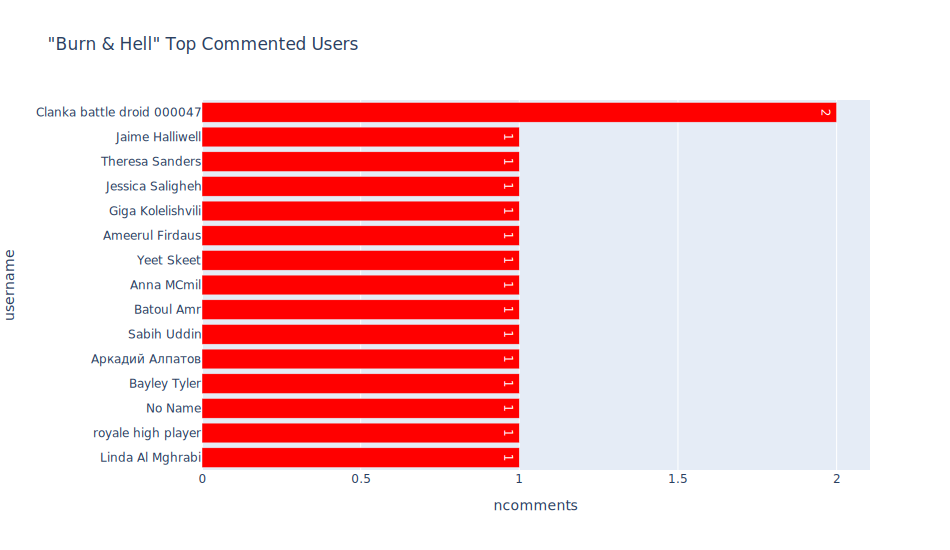

In [133]:
burn_users = df_burn.username.value_counts().to_frame().reset_index().rename(columns={'index':'username',
                                                                                  'username':'ncomments'})
helpers.barh(burn_users.head(15), '"Burn & Hell" Top Commented Users', threshold=0, c=0)

In [134]:
df_burn.username.value_counts().head()

Clanka battle droid 000047    2
Jaime Halliwell               1
Theresa Sanders               1
Jessica Saligheh              1
Giga Kolelishvili             1
Name: username, dtype: int64

In [135]:
threat_users = threat_users | set(df_burn.username)

# amber heard is the embodiment of hell

In [136]:
df_comments.query(" username == 'Clanka battle droid 000047' ").comment.value_counts().head()

amber heard is the embodiment of hell    2
Name: comment, dtype: int64

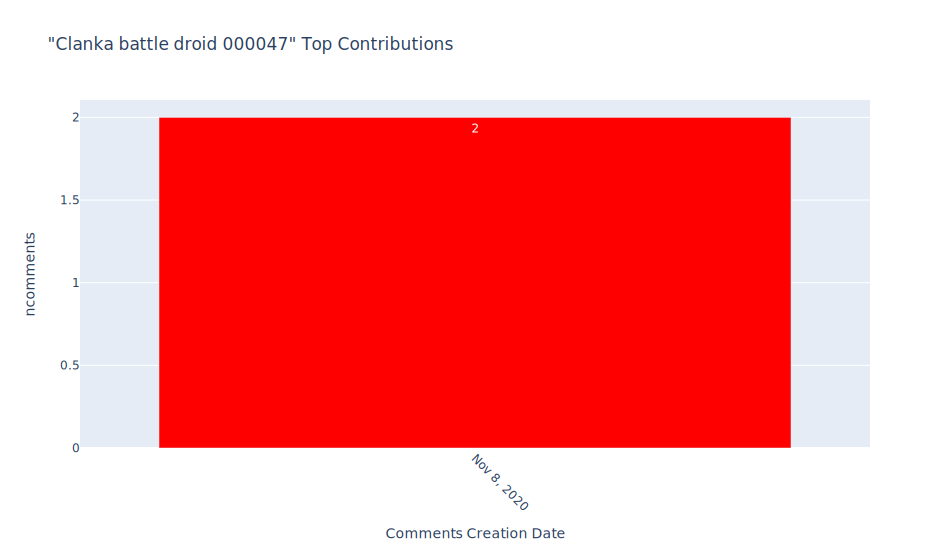

In [137]:
helpers.contr_peaks(df_comments, "Clanka battle droid 000047", n=3, threshold=0)

In [138]:
df_comments.query(" username == 'Jaime Halliwell' ").comment.value_counts().head()

this woman does not deserve to be a spokesperson for anything! she is an abuser. plus i've been a johnny depp fan for 27 years and there is no way in hell i ever believed that he would cause harm to anyone. get rid of her!!    1
Name: comment, dtype: int64

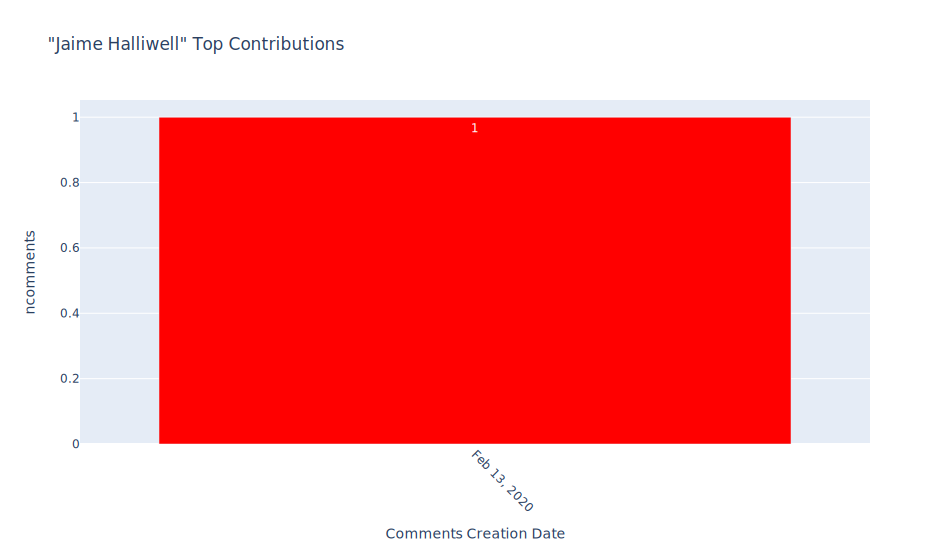

In [139]:
helpers.contr_peaks(df_comments, "Jaime Halliwell", n=3, threshold=0)

In [140]:
df_comments.query(" username == 'Theresa Sanders' ").comment.value_counts().head()

johnny depp is innocent that dump ass  judge didn't even look up evidence and hers my thing if and if a johnny deep really accused amber way back then then why she didn't come out then why is she says this know!!!!! we're is the fucking proof!!!!!!! johnny deep is innocent!!!!! and amber!! go to hell!    1
amber is going to get what's coming to her sooner or later u dog idk why amber fans even like that witch! fire her!                                                                                                                                                                                               1
Name: comment, dtype: int64

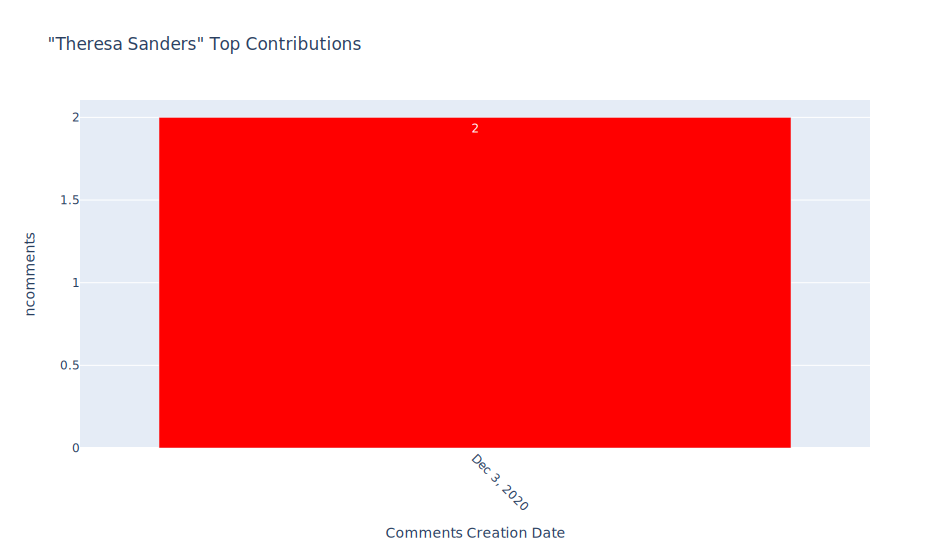

In [141]:
helpers.contr_peaks(df_comments, "Theresa Sanders", n=3, threshold=0)

In [142]:
df_comments.query(" username == 'Jessica Saligheh' ").comment.value_counts().head()

i am a survivor of domestic violence. i can't do anything to help johnnydepp, but i can help amber destroy her career. she doesn't deserve to any positive recognition. she needs to go down to the pits of hell where she belongs. she is a true, plotting and scheming sociopath. she discredits all victims of abuse, male and female.    1
Name: comment, dtype: int64

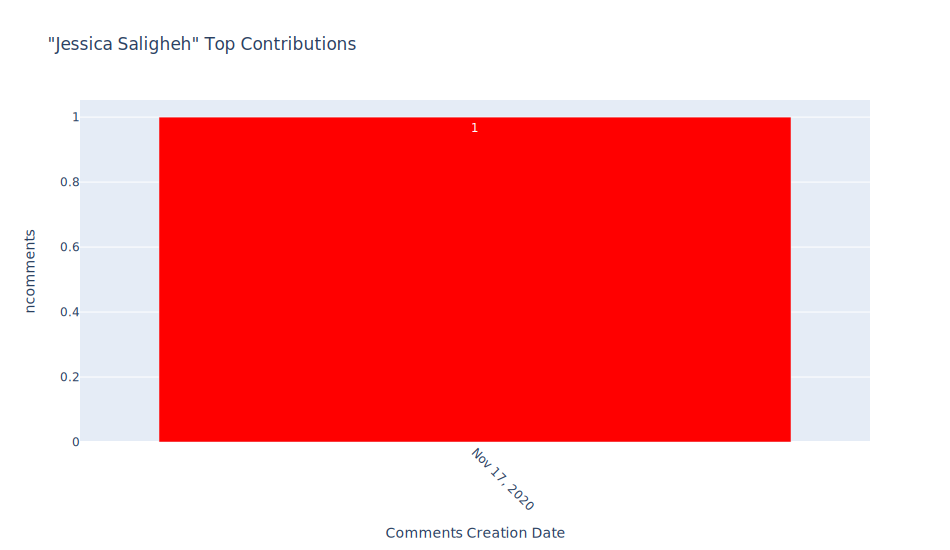

In [143]:
helpers.contr_peaks(df_comments, "Jessica Saligheh", n=3, threshold=0)

In [144]:
df_comments.query(" username == 'Giga Kolelishvili' ").comment.value_counts().head()

burn the witch    1
Name: comment, dtype: int64

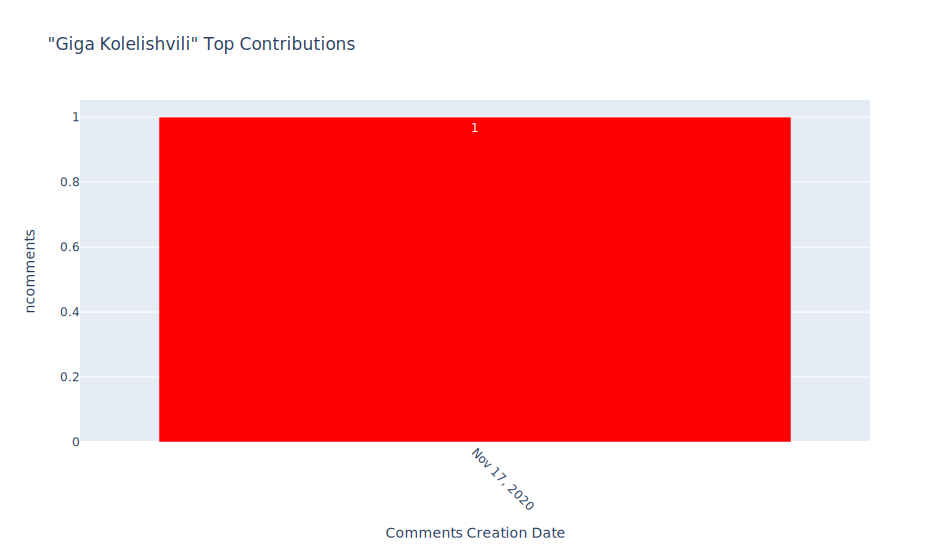

In [145]:
helpers.contr_peaks(df_comments, "Giga Kolelishvili", n=3, threshold=0)

<br>

<a id='crime_jail'></a>
>>## Punish, Crime, Jail & Prison
> <ul>
 <li><a href="#all_threat">All Threat</a></li>
 <li><a href="#kill_death">Kill & Death</a></li>
 <li><a href="#hell_burn">Hell & Burn</a></li>
 <li><a href="#crime_jail"><b>Crime & Jail</b></a></li>
 <li><a href="#threat_users">Threat Users Contributions</a></li>
 </ul>

In [146]:
crime_jail = {'her crime', 'her own crime', 'is criminal', 'is a criminal', 'unforgivable crimes', 
              'unforgivable crimes', 'commits crimes', 'punish', 'punish her', 'punish amber', 'deserves punish', 
              'should be punished', 'needs to be punished', 'place is jail', 'prison now', 'prison time', 
              'deserves prison', 'imprisoned for', 'in prison', 'to prison', 'prisonforamber', 'prisontimetoamber', 
              'imprison amber', 'deserves a prison cell', 'deserves fucking prison', 'in fucking prison', 
              'should be imprisoned', 'should be jailed', 'jail time', 'in jail', 'to jail', 'jail for', 
              'in a jail', 'into jail', 'she deserves it'}

In [147]:
df_crime = df_comments[df_comments.comment.str.contains('|'.join(crime_jail))]
print(f'{df_crime.shape[0]} contributions, on {df_crime.petition_slug.nunique()} Slugs, made by {df_crime.username.nunique()} Users')
df_crime.head()


890 contributions, on 72 Slugs, made by 808 Users


id                                            comment  \
9368  476368544  amber heard is a cruel and vicious woman who h...   
1181  532266899  i never trusted that scumbag bridezilla she sh...   
1115  532679474  amber tried to extort $ from johnny by demandi...   
1096  533411285  because no man, not even johnny depp, should b...   
9431  718086585  johnny depp is an asshole that shoud be thrown...   

     commentable_id  likes     role                created_at    user_id  \
9368        7177154      9  comment 2016-07-03 19:43:34+00:00  565817003   
1181        8655098      2  comment 2016-11-05 19:34:11+00:00   28268805   
1115        8655098      1  comment 2016-11-06 18:20:37+00:00     258065   
1096        8655098      2  comment 2016-11-07 21:02:32+00:00  117524405   
9431        9036344      0  comment 2017-11-22 10:42:09+00:00  631458848   

               username  user_city user_country_code user_locale  \
9368         Bunny Depp  San Diego                US       en-US   
1181   Gail Costenbader     Edison                US       en-US   
1115   Lorraine Bauleth       L.A.                US       en-US   
1096      Lori Hatfield     Quincy                US       en-US   
9431  Rebecca Bertolini        NaN                IT       it-IT   

                                          petition_slug status_manual  year  \
9368                      everybody-boycott-amber-heard       against  2016   
1181  kate-quinn-support-jk-rowling-s-fantastic-beas...       against  2016   
1115  kate-quinn-support-jk-rowling-s-fantastic-beas...       against  2016   
1096  kate-quinn-support-jk-rowling-s-fantastic-beas...       against  2016   
9431              jk-rowling-recast-gellert-grindelwald       against  2017   

           date month  dayofmonth  hour  
9368 2016-07-03   Jul           3    19  
1181 2016-11-05   Nov           5    19  
1115 2016-11-06   Nov           6    18  
1096 2016-11-07   Nov           7    21  
9431 2017-11-22   Nov          22    10

In [148]:
df_crime.petition_slug.value_counts().head(10)

l-oréal-remove-amber-heard-as-l-oreal-spokesperson                                                          176
justice-for-johnny-depp                                                                                     161
warner-brothers-keep-johnny-depp-as-grindelwald                                                             122
dc-entertainment-remove-amber-heard-from-aquaman-2                                                          110
warner-brothers-give-johnny-deep-his-roles-back                                                              58
united-states-supreme-court-put-amber-heard-behind-bars                                                      32
hollywood-boycott-aquaman-2-amber-heard                                                                      27
warner-brothers-warner-bros-warner-media-and-dc-films-fire-amber-heard-from-her-role-as-mera-in-the-dceu     18
change-org-blacklist-amber-heard-from-hollywood                                                         

In [149]:
df_crime.user_country_code.value_counts().head(10)

US    546
GB     89
CA     58
AU     45
IN     16
SE     13
ZA      8
PK      7
PH      6
DE      5
Name: user_country_code, dtype: int64

In [150]:
df_crime.user_locale.value_counts()

en-US     602
en-GB     126
en-CA      58
en-AU      42
en-IN      19
es-419     15
de-DE       7
fr-FR       6
es-AR       3
it-IT       2
ru-RU       2
hi-IN       2
es-ES       2
id-ID       2
pt-BR       1
ja-JP       1
Name: user_locale, dtype: int64

In [151]:
df_crime.user_city.value_counts().head(10)

Shrewsbury    11
Denton        10
Denver        10
Lemont         8
Phoenix        7
San Diego      6
Chicago        6
Long Beach     5
Tuscaloosa     5
Toronto        5
Name: user_city, dtype: int64

In [152]:
df_crime.role.value_counts()

comment              878
comment_dashboard     12
Name: role, dtype: int64

In [153]:
df_crime.status_manual.value_counts()

against    881
for          7
related      2
Name: status_manual, dtype: int64

### A Heat Map for the "Crime & Jail" Comments 

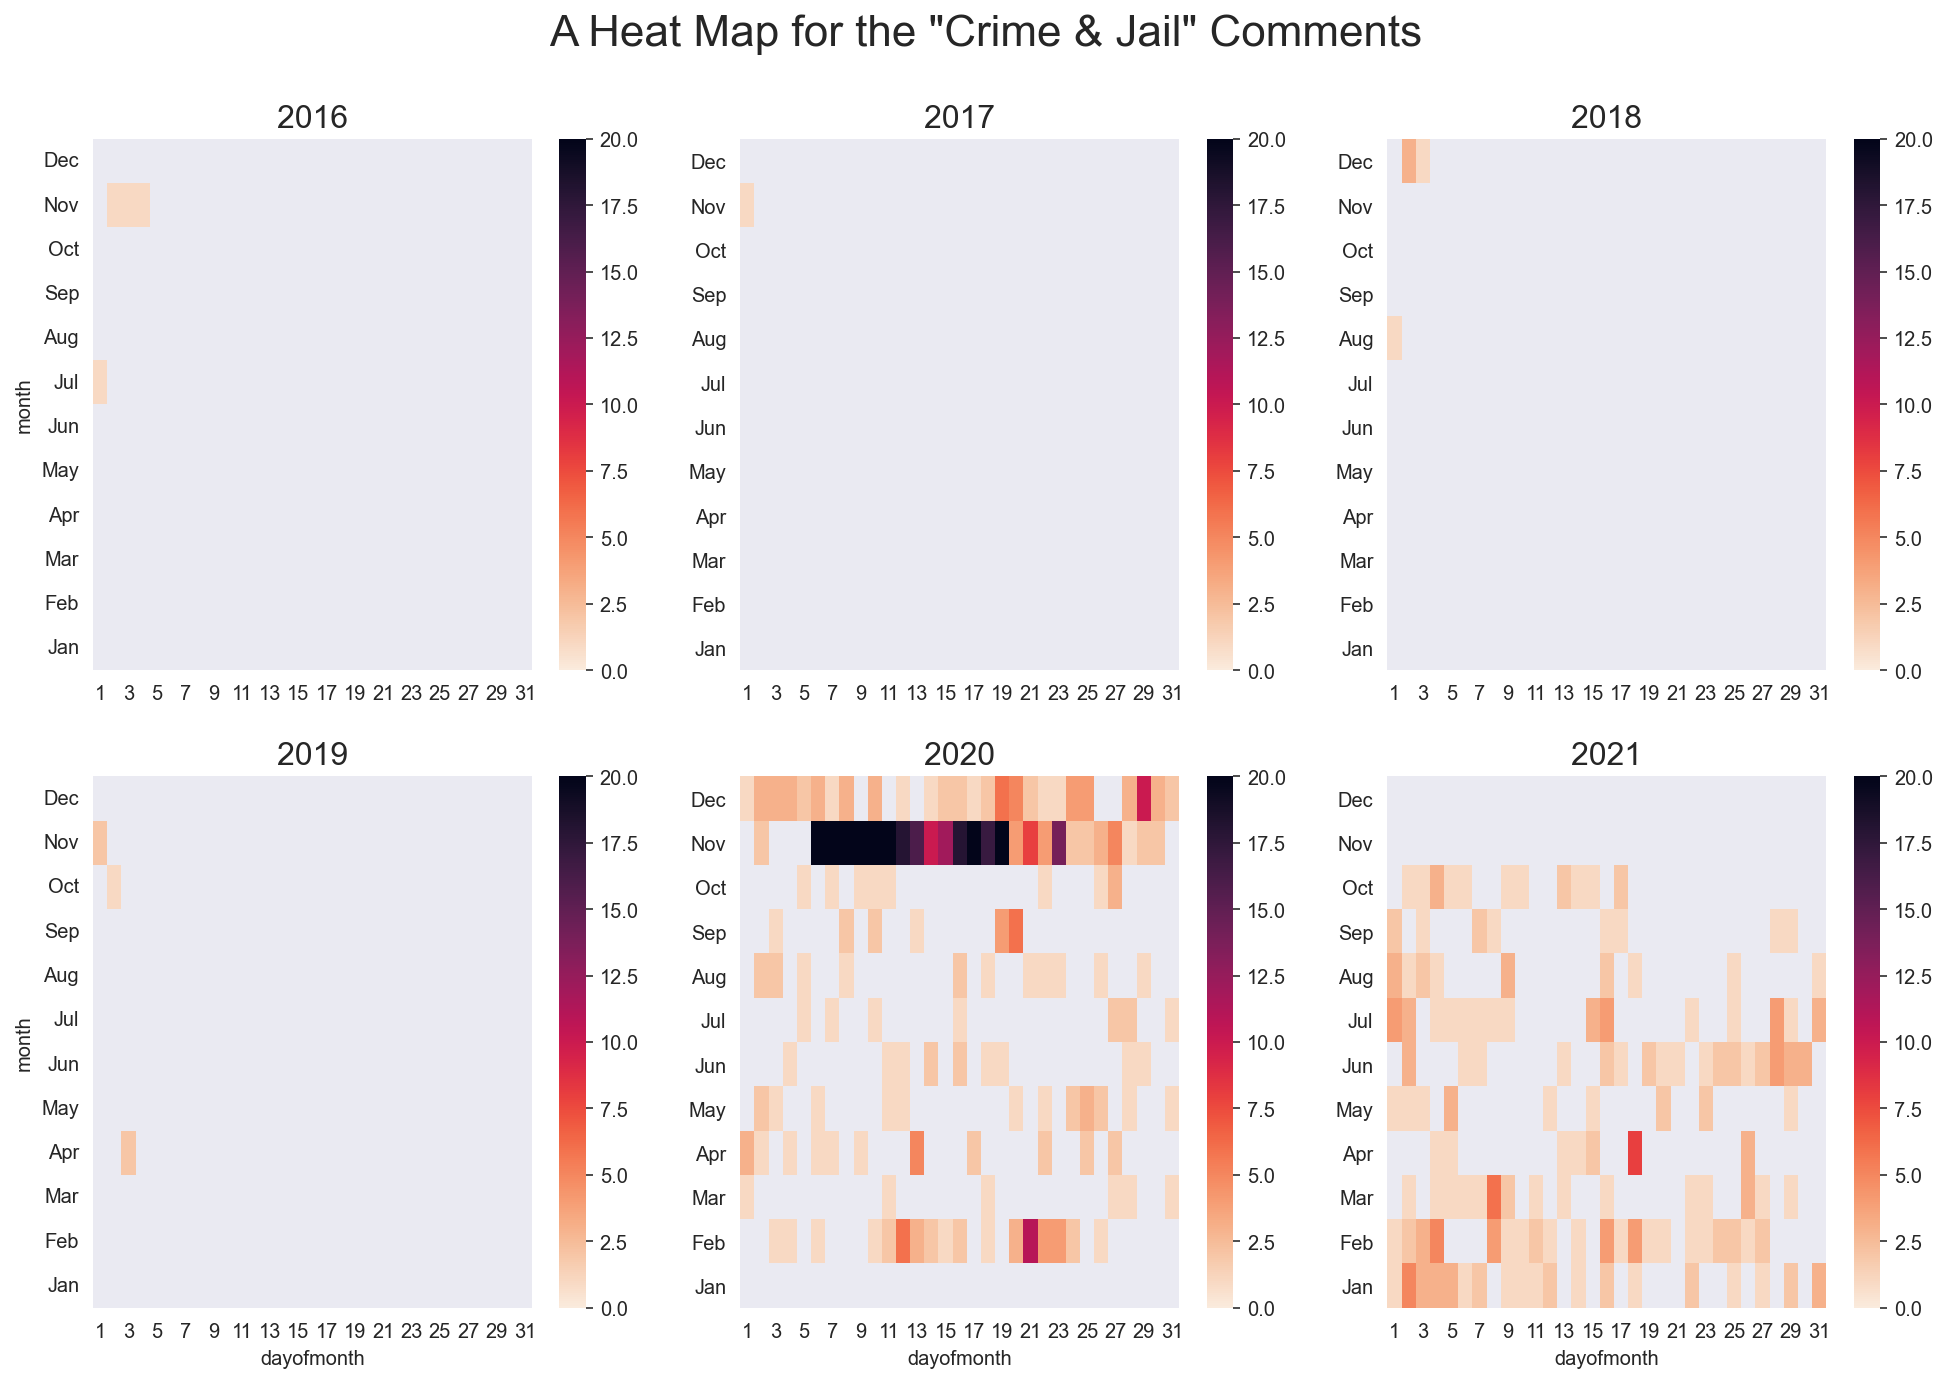

In [154]:
crime_daily = df_crime.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

title = 'A Heat Map for the "Crime & Jail" Comments'
helpers.facet_heat(crime_daily, title, n_col=3, vmax=20)

### "Crime & Jail" Comments Peak Dates

In [155]:
crime_dates = df_crime.groupby(['date']).agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'}).sort_values('ncomments', ascending=False)

crime_dates.head(15)

date  ncomments  likes
100 2020-11-07         50     19
110 2020-11-17         41     53
101 2020-11-08         40     12
102 2020-11-09         38     11
99  2020-11-06         34     41
103 2020-11-10         31     12
104 2020-11-11         28     18
112 2020-11-19         20     21
105 2020-11-12         18      7
109 2020-11-16         18     10
111 2020-11-18         17     41
106 2020-11-13         16      6
116 2020-11-23         14      7
108 2020-11-15         12      4
23  2020-02-21         11     11

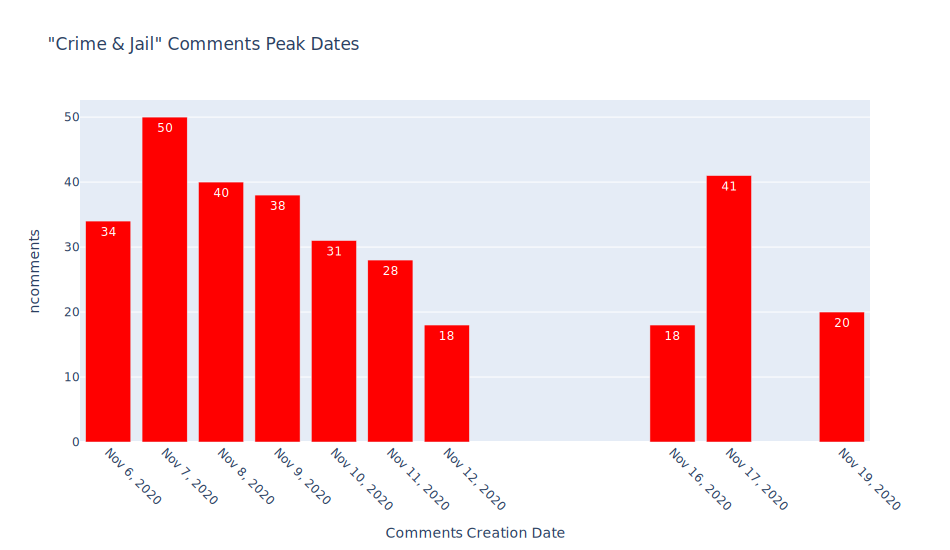

In [156]:
helpers.bar_peaks(crime_dates[['date', 'ncomments']].head(10), 
                  '"Crime & Jail" Comments Peak Dates')

# "Crime & Jail" Comments

In [157]:
df_crime.comment.value_counts().head(60)

she deserves it                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         8
i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done 

In [158]:
df_crime.comment.value_counts()[60:].head(60)

johnny depp is a great actor, and if he is being punished then so should his ex and loose her part\n\nkeep johnny depp in no one can do this part                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1
nicest guy ever! never abused his ex-wife neither one especially a.h. who is the true abuser! punching him, gaslighing, manipulating, black-mailing, trash talked him behind his back. amber heard decided to "gone girl" him the minute she met him or maybe sooner than that! put her in jail where she belongs                                                              

# Top Users Commented with "Crime & Jail" keywords

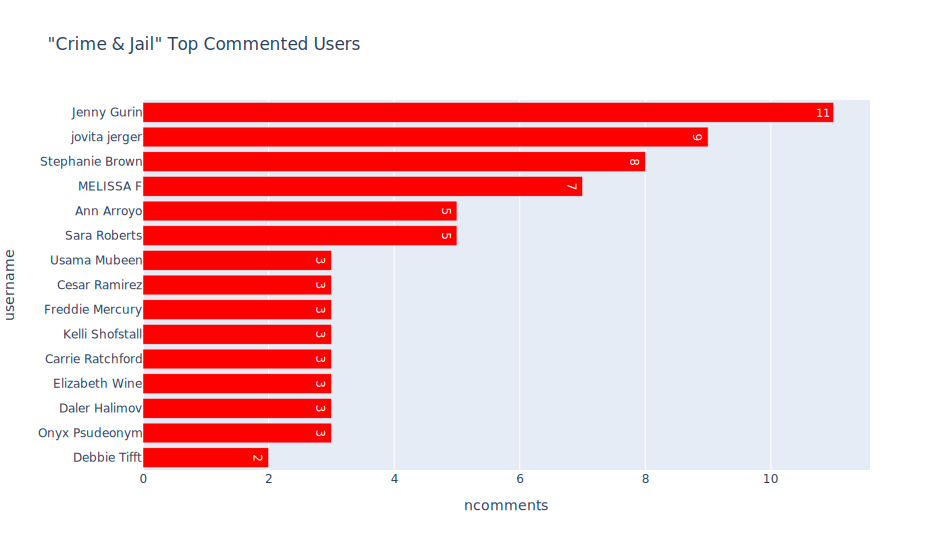

In [159]:
crime_users = df_crime.username.value_counts().to_frame().reset_index().rename(columns={'index':'username',
                                                                                  'username':'ncomments'})
helpers.barh(crime_users.head(15), '"Crime & Jail" Top Commented Users', threshold=0, c=0)

In [160]:
df_crime.username.value_counts().head()

Jenny Gurin        11
jovita jerger       9
Stephanie Brown     8
MELISSA F           7
Ann Arroyo          5
Name: username, dtype: int64

In [161]:
threat_users = threat_users | set(df_crime.username)

In [162]:
df_comments.query(" username == 'Jenny Gurin' ").comment.value_counts().head(60)

johnny is innocent and deserves nothing but the best!!                                                                                                                                                                                                                                                                                                                                                                                   4
she has taken advantage of and abused my favorite actor for years                                                                                                                                                                                                                                                                                                                                                                        1
these nasty lies and accusations about johnny (my favorite actor since childhood) have got to stop, and the person responsible for starting all of

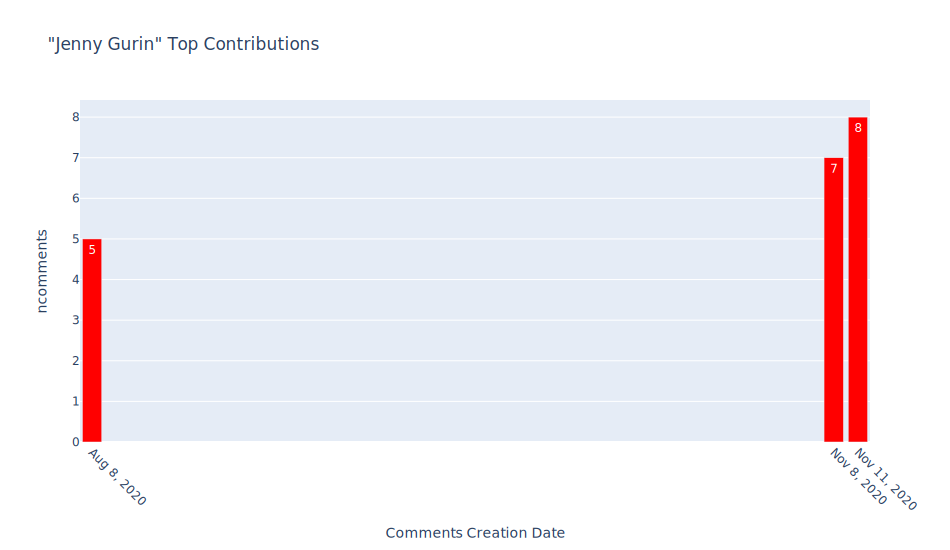

In [163]:
helpers.contr_peaks(df_comments, "Jenny Gurin", n=3, threshold=0)

In [164]:
df_comments.query(" username == 'jovita jerger' ").comment.value_counts().head(60)

# justice for the innocent \n# justice for johnny depp                                                                                                    1
# justice for johnny depp\n# justice for the innocent                                                                                                     1
justice for the innocent \njustice for johnny depp                                                                                                        1
punish the guilty! not the innocent!! \njustice for victims not the abusers!!                                                                             1
punish the guilty not the innocent!!!\njustice for the victims not the abusers \nstop letting abusers get away with abuse and have the victims suffer!    1
punish the  guilty not the innocent\nstop punishing the victims and letting the abusers get away with it stop domestic abuse                              1
stop punishing the victims and punish the abusers\nstop domestic

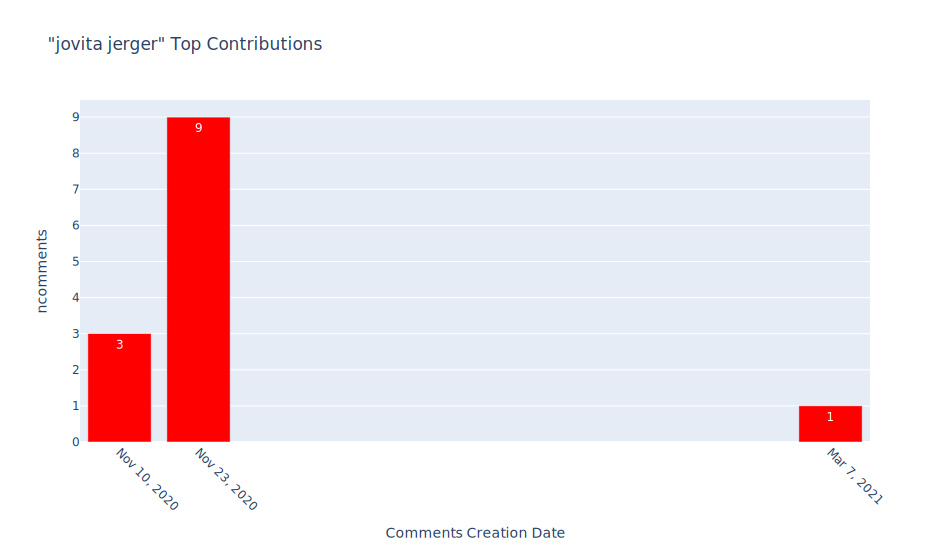

In [165]:
helpers.contr_peaks(df_comments, "jovita jerger", n=5, threshold=0)

In [166]:
df_comments.query(" username == 'Stephanie Brown' ").comment.value_counts().head(60)

#justiceforjohnnydepp!                                                                                                                                                                                                                                                                                                                                                                                4
#johnnydeppismygrindelwald!                                                                                                                                                                                                                                                                                                                                                                           3
johnny depp is innocent!                                                                                                                                                                                                

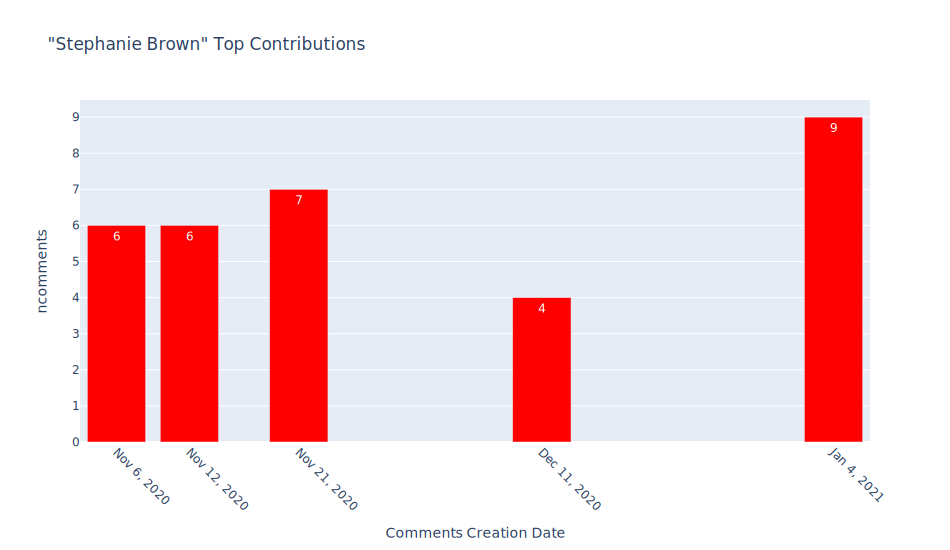

In [167]:
helpers.contr_peaks(df_comments, "Stephanie Brown", n=5, threshold=0)

In [168]:
df_comments.query(" username == 'MELISSA F' ").comment.value_counts().head(60)

i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift & severe punishment in order to be made an example of. #justiceforjohnnydepp    6
i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift and severe punishment in order to make an example. #justiceforjohnnydepp        1
Name: comment, dtype: int64

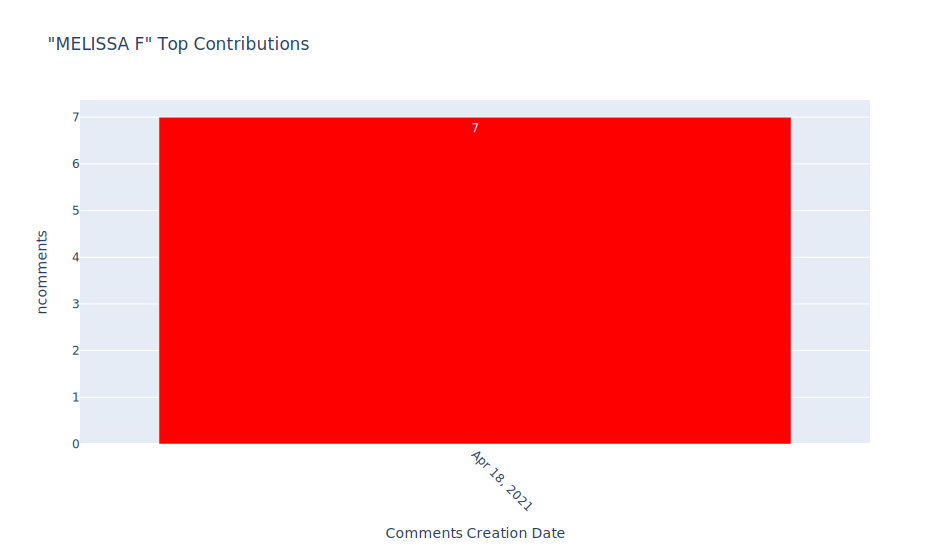

In [169]:
helpers.contr_peaks(df_comments, "MELISSA F", n=3, threshold=0)

In [170]:
df_comments.query(" username == 'Ann Arroyo' ").comment.value_counts().head(60)

amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she was even arrested for domestic violence by an officer who witness the assault. heard should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others. johnny depp who did not have this history in his former relationships is the victim of abuse and at some point victims do fight back as a result of the abuse. he should not be punished for being a victim.                                                                                     3
amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others.                                                                                                                                             

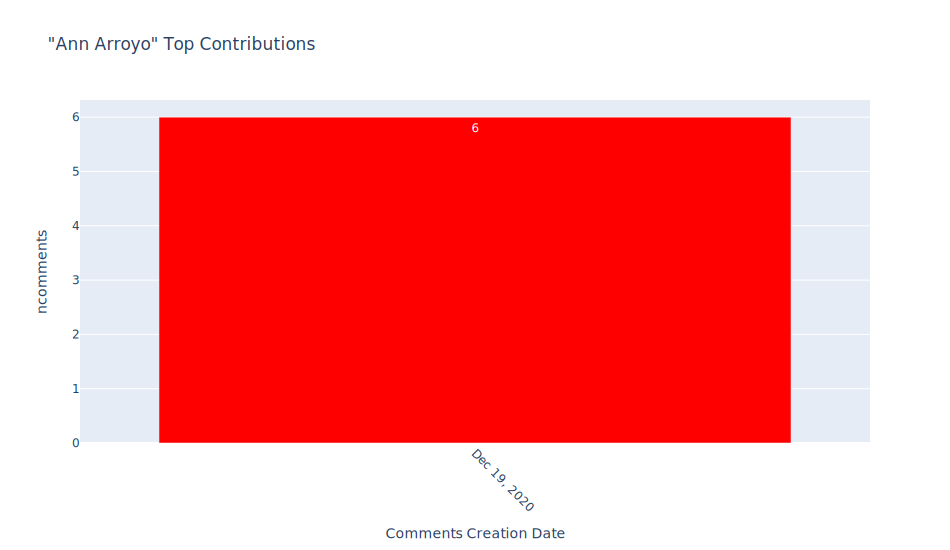

In [171]:
helpers.contr_peaks(df_comments, "Ann Arroyo", n=3, threshold=0)

<br>

# pay for her crime

In [172]:
df_pay = df_comments[df_comments.comment.str.contains('pay for her crime')]
print(f'{df_pay.shape[0]} contributions, on {df_pay.petition_slug.nunique()} Slugs, made by {df_pay.username.nunique()} Users')
df_pay


5 contributions, on 3 Slugs, made by 5 Users


id                                            comment  \
21165  774640964  she needs to pay for her crimes. all of her cr...   
26303  784012688  this man brings joy to people, not punishment....   
18190  808850042  amber heard is an abuser and if she won’t be p...   
17911  808877009                she deserves to pay for her crimes.   
179    821299560  the right thing to do is to make the guilty st...   

      commentable_id  likes     role                created_at     user_id  \
21165       20196023      0  comment 2020-02-11 17:59:02+00:00   876941341   
26303       20186707      0  comment 2020-04-22 18:10:50+00:00  1035519071   
18190       20196023      1  comment 2020-11-07 18:53:16+00:00   944404573   
17911       20196023      0  comment 2020-11-08 05:18:21+00:00  1153365978   
179         20569720      0  comment 2021-07-07 03:37:20+00:00  1109415432   

                               username          user_city user_country_code  \
21165  Yelva Kathleen MINYANGADOU MONNY  Villeneuve-le-Roi                FR   
26303                       Jason Hamel         St. John's                CA   
18190               Christopher McManus           Vernonia                US   
17911                    Hannah Laubach          San Diego                US   
179                 Crista Van Nostrand      Arkansas City                US   

      user_locale                                      petition_slug  \
21165       fr-FR  l-oréal-remove-amber-heard-as-l-oreal-spokespe...   
26303       en-CA                            justice-for-johnny-depp   
18190       en-US  l-oréal-remove-amber-heard-as-l-oreal-spokespe...   
17911       en-US  l-oréal-remove-amber-heard-as-l-oreal-spokespe...   
179         en-US            hollywood-boycott-aquaman-2-amber-heard   

      status_manual  year       date month  dayofmonth  hour  
21165       against  2020 2020-02-11   Feb          11    17  
26303       against  2020 2020-04-22   Apr          22    18  
18190       against  2020 2020-11-07   Nov           7    18  
17911       against  2020 2020-11-08   Nov           8     5  
179         against  2021 2021-07-07   Jul           7     3

In [173]:
df_pay.comment.value_counts().head(60)

she needs to pay for her crimes. all of her crimes, as not only did she set all victims of domestic abuse (male or female) back in time, but she also had the gall to parade her lies all over the media and the world! no shame, no conscious, no remorse, nothing! she’s a sociopath who needs to be behind bars!    1
this man brings joy to people, not punishment. this woman must pay for her crimes in the exact same fashion in which a man would pay for such outrageous behavior. an example must be made here in a big way.                                                                                                          1
amber heard is an abuser and if she won’t be punished by the criminal system, we will punish her by not using products she endorses and not watching movies she is in. damage her career. she will pay for her crimes one way or another.                                                                              1
she deserves to pay for her crimes.                          

In [174]:
df_pay.username.value_counts().head(15)

Yelva Kathleen MINYANGADOU MONNY    1
Jason Hamel                         1
Christopher McManus                 1
Hannah Laubach                      1
Crista Van Nostrand                 1
Name: username, dtype: int64

In [175]:
df_pay[['comment', 'username', 'date']]

comment  \
21165  she needs to pay for her crimes. all of her cr...   
26303  this man brings joy to people, not punishment....   
18190  amber heard is an abuser and if she won’t be p...   
17911                she deserves to pay for her crimes.   
179    the right thing to do is to make the guilty st...   

                               username       date  
21165  Yelva Kathleen MINYANGADOU MONNY 2020-02-11  
26303                       Jason Hamel 2020-04-22  
18190               Christopher McManus 2020-11-07  
17911                    Hannah Laubach 2020-11-08  
179                 Crista Van Nostrand 2021-07-07

In [176]:
threat_users = threat_users | set(df_pay.username)

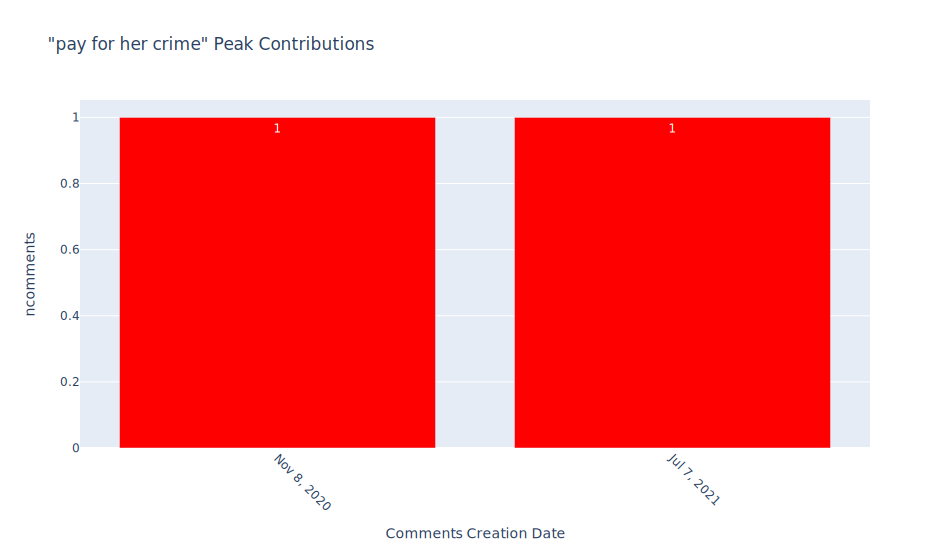

In [177]:
helpers.text_peaks(df_pay, 'pay for her crime', n=2, threshold=0, mode='contain')

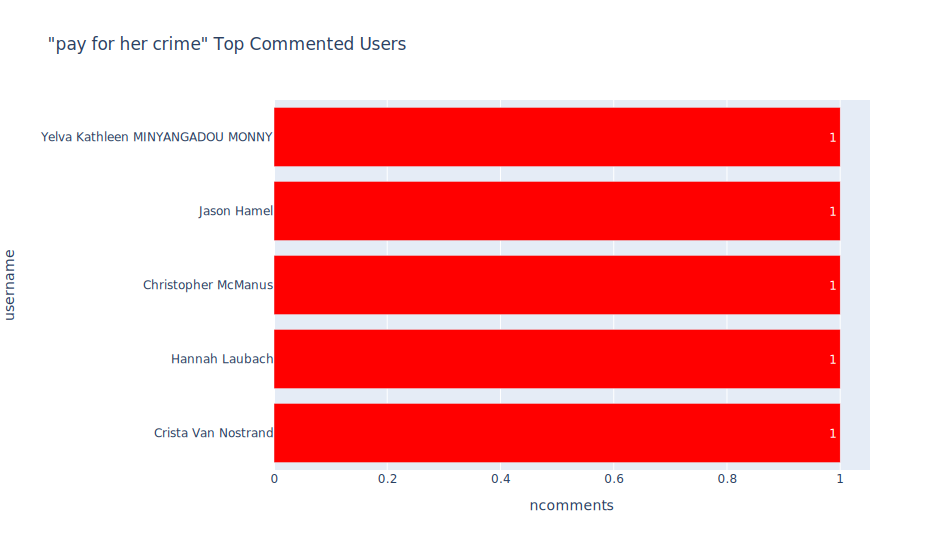

In [178]:
pay_users = df_pay.username.value_counts().to_frame().reset_index().rename(columns={'index':'username',
                                                                                  'username':'ncomments'})
helpers.barh(pay_users.head(15), '"pay for her crime" Top Commented Users', threshold=0, c=0)

<br>

<a id='threat_users'></a>
>>## Threat Users Contributions (All Contributions)
> <ul>
 <li><a href="#all_threat">All Threat</a></li>
 <li><a href="#kill_death">Kill & Death</a></li>
 <li><a href="#hell_burn">Hell & Burn</a></li>
 <li><a href="#crime_jail">Crime & Jail</a></li>
 <li><a href="#threat_users"><b>Threat Users Contributions</b></a></li>
 </ul>

In [179]:
len(set(df_threat.username))

874

In [180]:
threat_users_list = list(df_threat.username)
df_threat_users = df_comments.query(' username == @threat_users_list ')
print(f'{df_threat_users.shape[0]} contributions, on {df_threat_users.petition_slug.nunique()} Slugs, made by {df_threat_users.username.nunique()} Users')
df_threat_users.head(2)


1532 contributions, on 152 Slugs, made by 874 Users


id                                            comment  \
9373  465226313  the fact that amber filed for divorce the next...   
9368  476368544  amber heard is a cruel and vicious woman who h...   

     commentable_id  likes     role                created_at    user_id  \
9373        7177154     18  comment 2016-06-12 00:10:53+00:00     258065   
9368        7177154      9  comment 2016-07-03 19:43:34+00:00  565817003   

              username  user_city user_country_code user_locale  \
9373  Lorraine Bauleth       L.A.                US       en-US   
9368        Bunny Depp  San Diego                US       en-US   

                      petition_slug status_manual  year       date month  \
9373  everybody-boycott-amber-heard       against  2016 2016-06-12   Jun   
9368  everybody-boycott-amber-heard       against  2016 2016-07-03   Jul   

      dayofmonth  hour  
9373          12     0  
9368           3    19

In [181]:
df = df_threat_users.groupby('username').agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'})

print(df.shape)
df.sort_values('ncomments', ascending=False).head(15)

(874, 3)


username  ncomments  likes
734   Stephanie Brown        137    110
353       Jenny Gurin         41     27
692      Sara Roberts         32     21
123  Carrie Ratchford         25      5
200    Deborah Skikos         20     15
485   Linda Lundgvist         19      7
41           Amy Hope         18     15
51       Angela Marie         16     12
129     Cesar Ramirez         15      8
827     jovita jerger         13      4
746  Tanya Waterfield         12     15
865       vickie luck         10      3
201  Deborah Slockett          9      7
18        Alexis Lotz          9     16
636       Penguin 322          8      5

### A Heat Map for the Threat Users Comments 

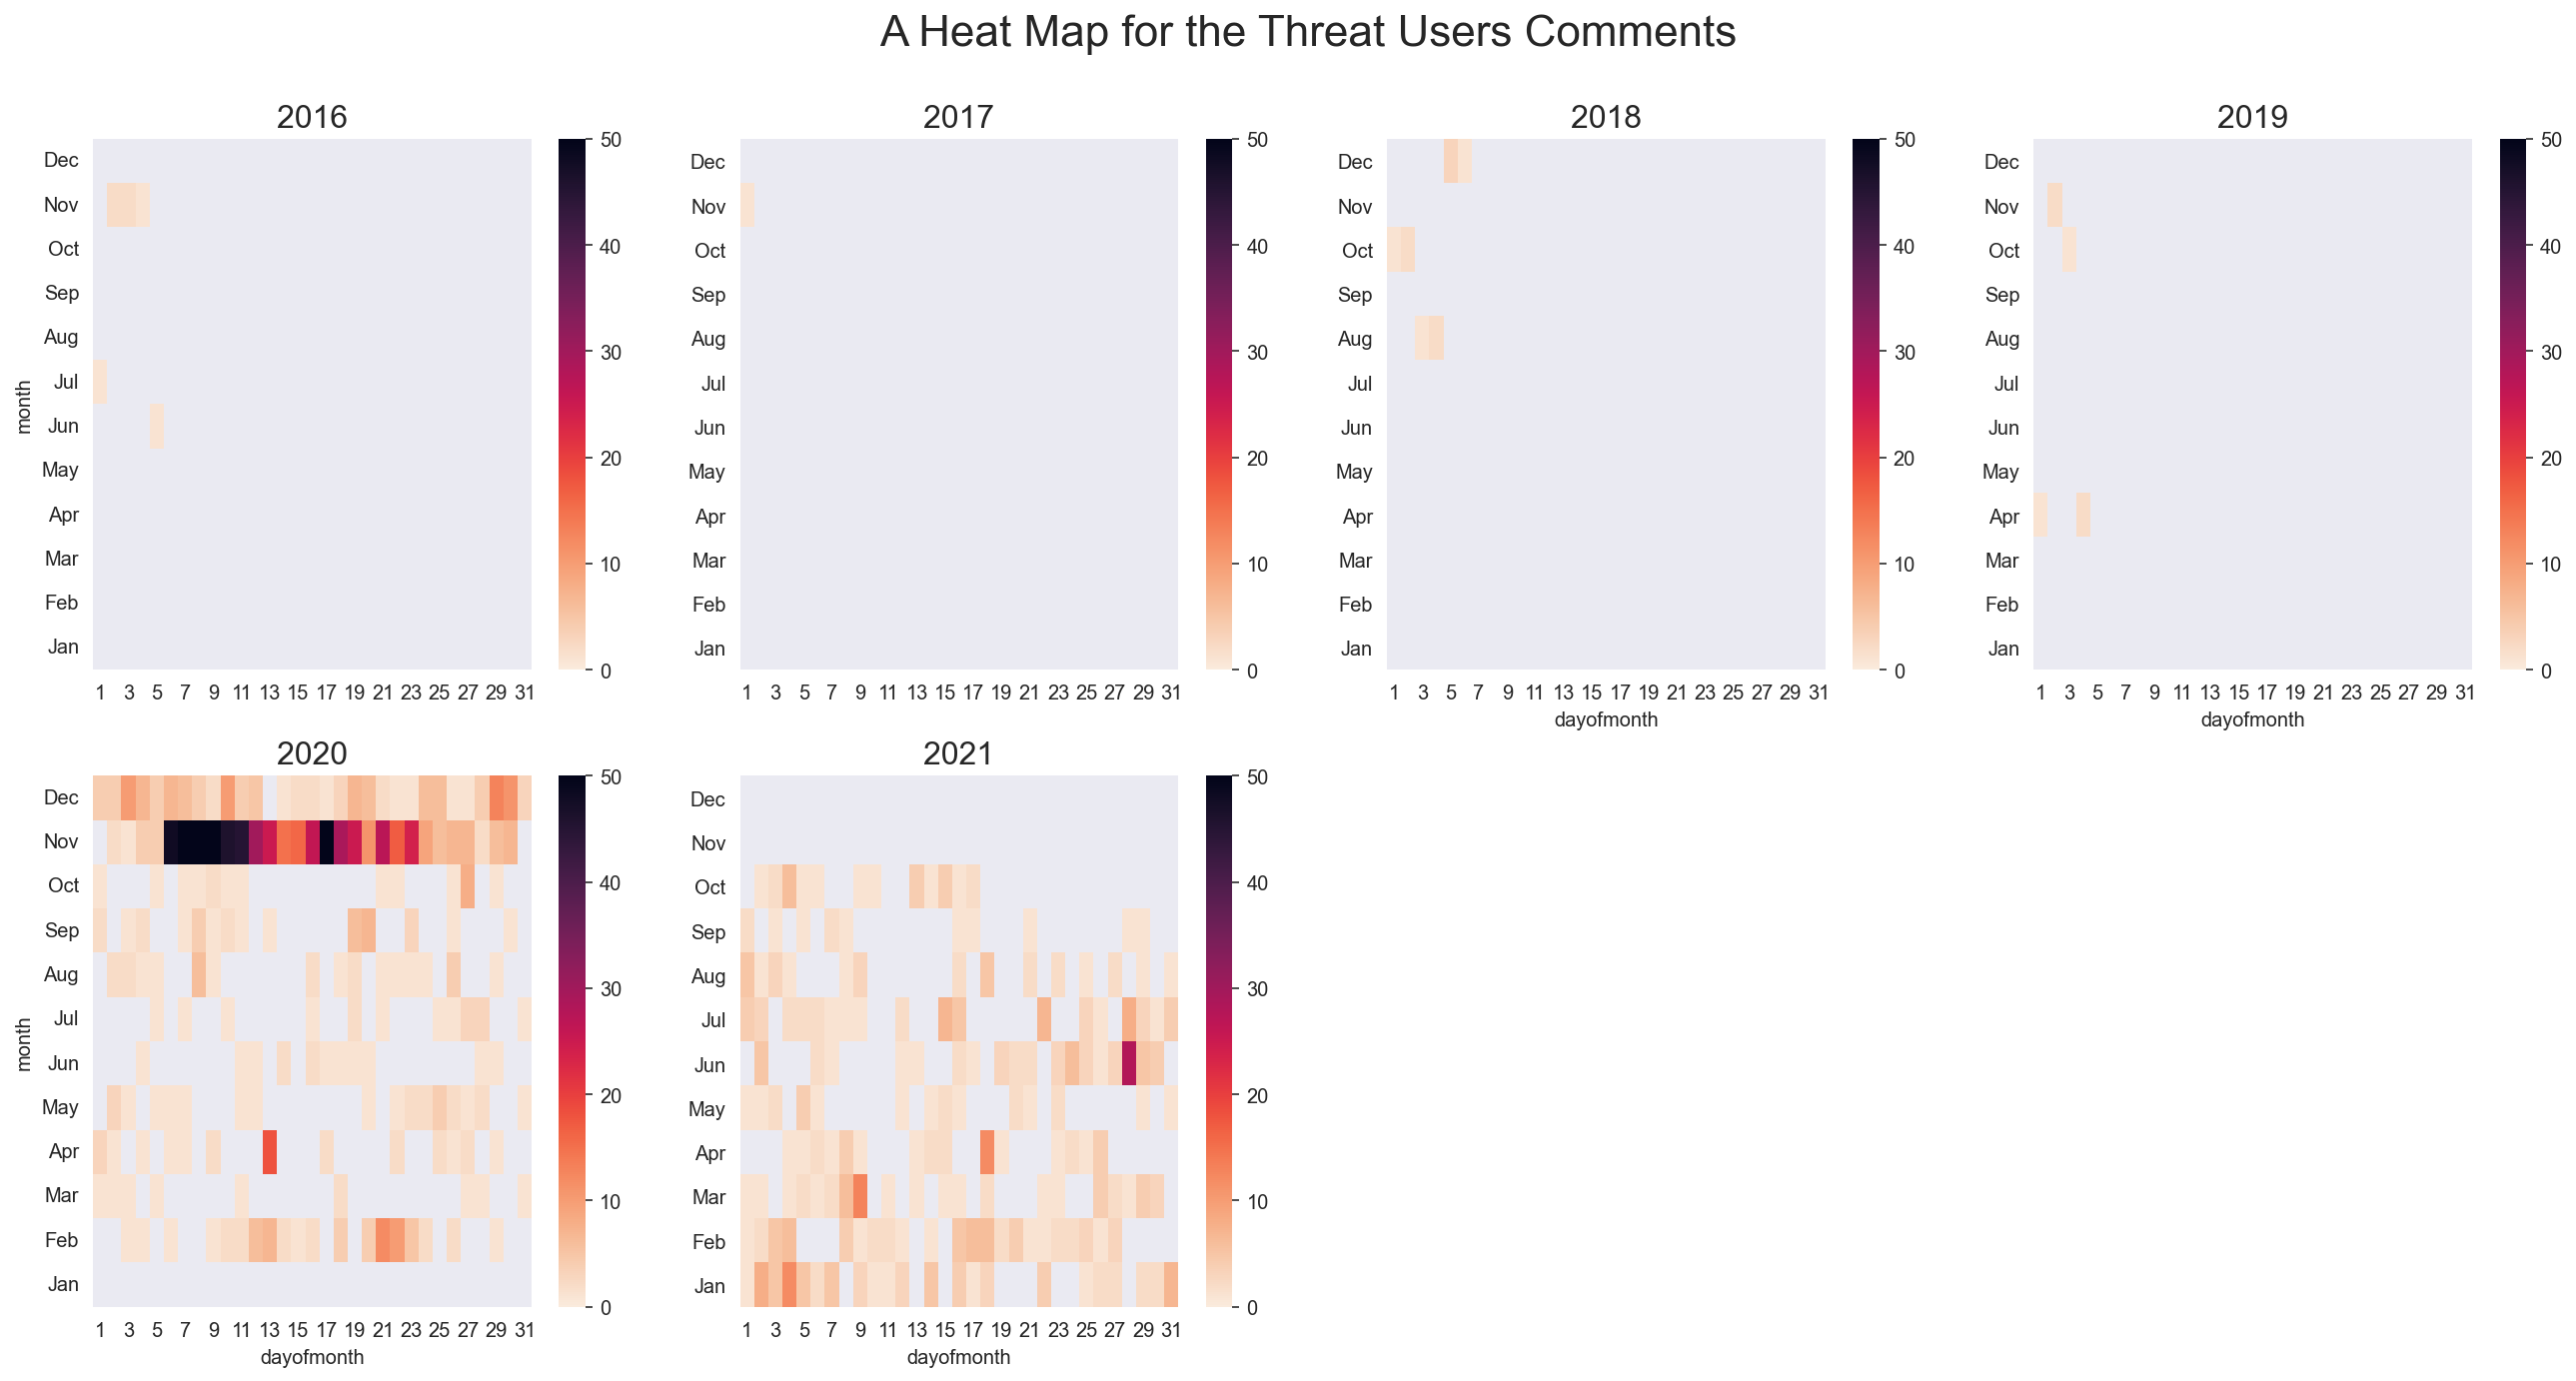

In [182]:
threat_users_daily = df_threat_users.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

title = 'A Heat Map for the Threat Users Comments'
helpers.facet_heat(threat_users_daily, title, n_col=4, vmax=50)

### Threat Users Comments Peak Dates

In [183]:
threat_users_dates = df_threat_users.groupby(['date']).agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'}).sort_values('ncomments', ascending=False)

threat_users_dates.head(15)


date  ncomments  likes
142 2020-11-08         68     29
151 2020-11-17         59     63
141 2020-11-07         57     22
143 2020-11-09         57     16
140 2020-11-06         48     49
144 2020-11-10         46     20
145 2020-11-11         45     27
146 2020-11-12         30     12
152 2020-11-18         29     57
303 2021-06-28         28      7
155 2020-11-21         27     19
150 2020-11-16         26     15
147 2020-11-13         25     10
153 2020-11-19         25     25
157 2020-11-23         24     12

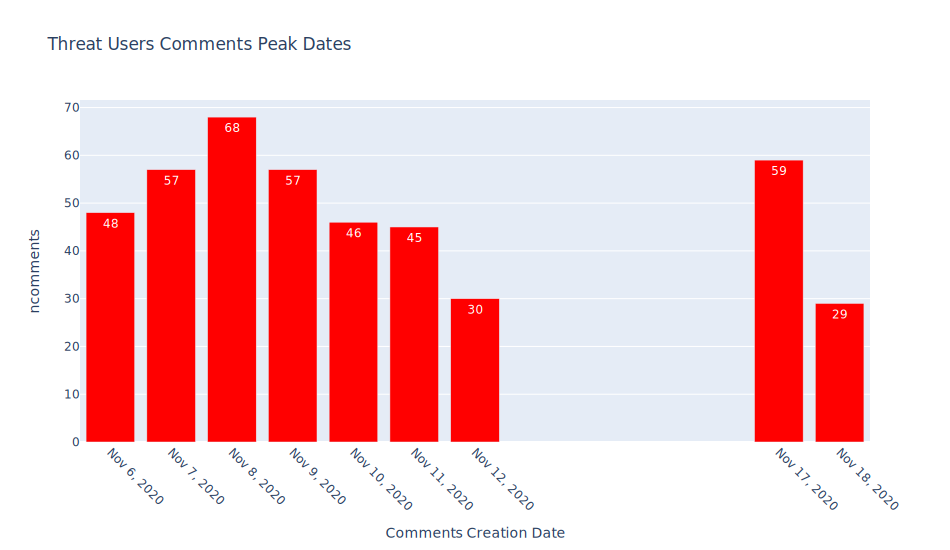

In [184]:
helpers.bar_peaks(threat_users_dates[['date', 'ncomments']].head(9), 
                  'Threat Users Comments Peak Dates')

# Most Repeated Threat Users Comments

In [185]:
df_threat_users.comment.value_counts().head(60)

#justiceforjohnny                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          13
she deserves it                                                                                                                                                                                                                                                                                                           

In [186]:
df_threat_users.comment.value_counts()[60:].head(60)

i stand with johny depp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1
i refuse to go see another pirates of the caribbean movie, without the best leading man of all time!                                          

### Text Contains "not a victim" --> 38

In [187]:
df_victim = df_comments[df_comments.comment.str.contains('not a victim')]
print(f'{df_victim.shape[0]} contributions, on {df_victim.petition_slug.nunique()} Slugs, made by {df_victim.username.nunique()} Users')
df_victim

38 contributions, on 16 Slugs, made by 37 Users


id                                            comment  \
10558  768782289  i support john depp! he is my favorite actor, ...   
21066  774723269  she lied & tried to destroy a good man!!! i'm ...   
20400  775447310  she's not a healthy, rational individual. nor ...   
2359   775902557                        amber heard is not a victim   
20011  784536330  she deserves to have her life and career ruine...   
19065  803495549  amber heard is clearly not a victim. represent...   
18807  805698254  she’s not a victim and she lied about the situ...   
18649  807008190  as a woman who has actually suffered abuse... ...   
1353   808795865  no innocent man should be fired... sorry, "ask...   
25541  808877825  no person should be abused and then abused aga...   
17762  808895442  shame on them for keeping a known abuser. ther...   
13125  808936133  you will not convince me that johnny depp is n...   
17299  808990004  the evidence is there. she is part of the prob...   
14613  809169302                       she’s an abuser not a victim   
57     809277450  because it is a complete injustice to take thi...   
16467  809295745  as it is clear she is an abuser both physicall...   
5951   809433843  i am a domestic violence victim who suffers fr...   
1628   809657177  amber heard will never speak for me; she is an...   
23016  811122066  "they won’t believe you, because you are a man...   
14710  811122167  "they won’t believe you, because you are a man...   
16193  811278931                                 she’s not a victim   
14705  811284221                                 she’s not a victim   
1528   811289661  i am not a bot and i am sick of people that us...   
1515   811293761  amber heard is an imposter. she is not a victi...   
1484   811307264  i am not a victim, but my friend has been a vi...   
1448   811357729  amber is not a victim. johnny depp is the victim.   
1412   811439152  i am a surviver not a victim. i am a real pers...   
11800  811549681  "no one will believe you because you are a man...   
1406   811571332           i’m signing because she is not a victim.   
1402   811746758  amber heard is not a victim. she is the abuser...   
403    811807615  because of her jhonny deep lost his role and e...   
2716   811875622  abuse can happen to men as well! screw amber h...   
395    812076298                    she is a lier & is not a victim   
1009   812652287  this woman is making a mockery out of dv, she'...   
1008   812652632  amber heard is a domestic violence perpetrator...   
2214   814728431  fire amber heard she is not a victim! i am not...   
16239  824593061  as a domestic abuse survivor, i stand with all...   
16234  824604074                         she is not a victim of dv.   

      commentable_id  likes     role                created_at     user_id  \
10558       13641580      2  comment 2019-11-20 09:27:50+00:00  1019664696   
21066       20196023      3  comment 2020-02-13 00:48:25+00:00   280018761   
20400       20196023      0  comment 2020-02-24 07:34:03+00:00    73684130   
2359        14799888      0  comment 2020-03-02 01:27:58+00:00   844815598   
20011       20196023      0  comment 2020-04-27 06:08:11+00:00    55662173   
19065       20196023      3  comment 2020-08-23 00:10:52+00:00    68780900   
18807       20196023      4  comment 2020-09-20 02:02:11+00:00    83779517   
18649       20196023      3  comment 2020-10-11 22:19:39+00:00  1156082216   
1353        25296529      2  comment 2020-11-06 21:20:55+00:00   155253940   
25541       20186707      0  comment 2020-11-08 05:47:04+00:00  1162406686   
17762       20196023      0  comment 2020-11-08 14:09:33+00:00   944148006   
13125       25699776      0  comment 2020-11-09 03:58:57+00:00   963652468   
17299       20196023      0  comment 2020-11-09 23:59:40+00:00   932397989   
14613       25806104      0  comment 2020-11-12 15:28:37+00:00  1138415884   
57          25699792      1  comment 2020-11-14 20:52:39+00:00  1151753784

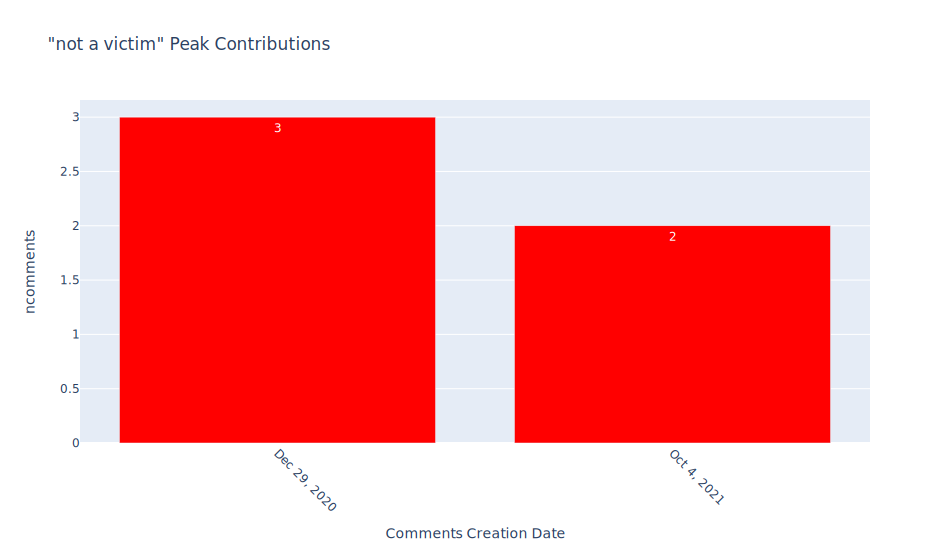

In [188]:
helpers.text_peaks(df_victim, "not a victim", n=2, threshold=0, mode='contain')

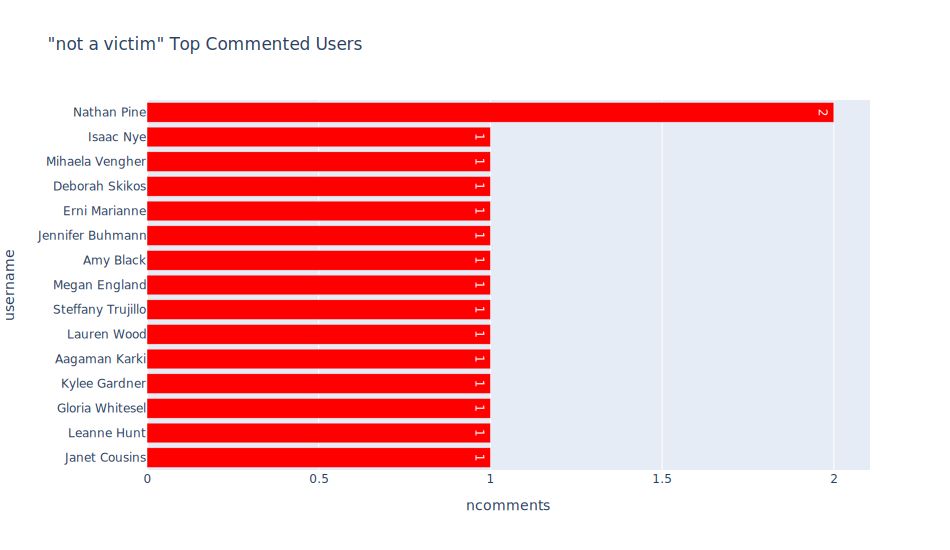

In [189]:
victim_users = df_victim.username.value_counts().to_frame().reset_index().rename(columns={'index':'username',
                                                                                  'username':'ncomments'})
helpers.barh(victim_users.head(15), '"not a victim" Top Commented Users', threshold=0, c=0)

**NOTE:** Most of these users only commented with "not a victim" comments!!!

<br>

# Top Users Commented with "not a victim" 

In [190]:
df_victim.username.value_counts().head()

Nathan Pine        2
Isaac Nye          1
Mihaela Vengher    1
Deborah Skikos     1
Erni Marianne      1
Name: username, dtype: int64

In [191]:
df_comments.query(" username == 'Nathan Pine' ").comment.value_counts().head()

"they won’t believe you, because you are a man”\n\nshe is not a victim.    2
Name: comment, dtype: int64

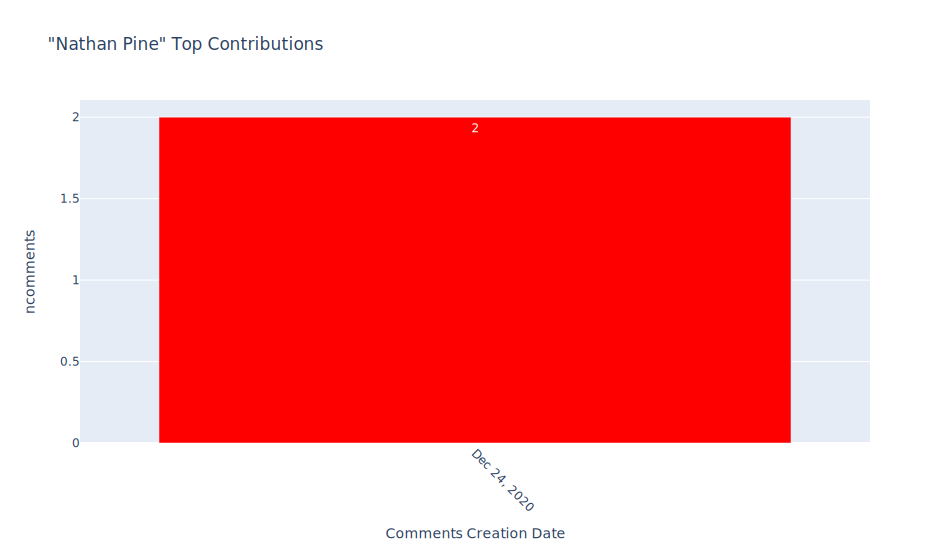

In [192]:
helpers.contr_peaks(df_comments, "Nathan Pine", n=3, threshold=0)

In [193]:
df_comments.query(" username == 'Isaac Nye' ").comment.value_counts().head()

she’s not a victim    1
Name: comment, dtype: int64

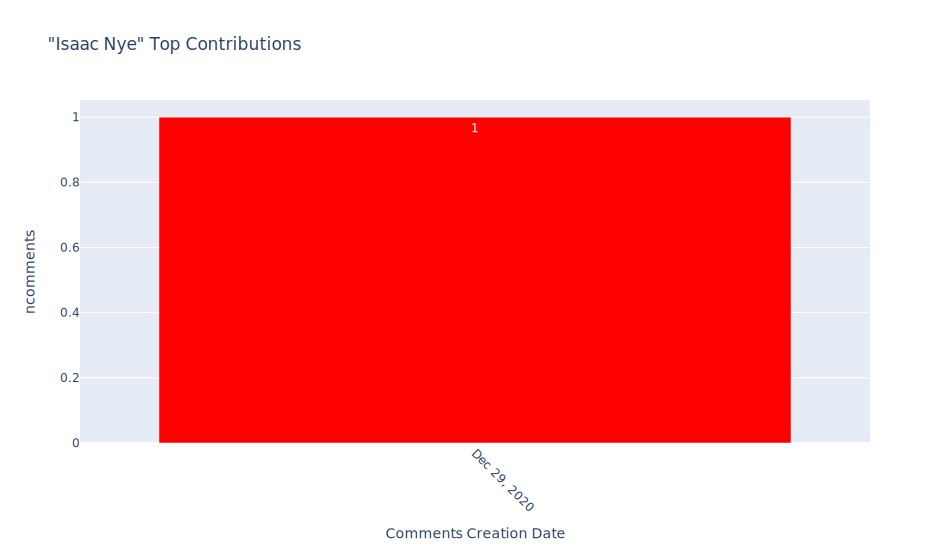

In [194]:
helpers.contr_peaks(df_comments, "Isaac Nye", n=3, threshold=0)

In [195]:
df_comments.query(" username == 'Mihaela Vengher' ").comment.value_counts().head()

i am not a bot and i am sick of people that uses media and heartbreaking stories to make money. ah is not a victim and she doesn't speaks for me.  i would feel like to insult her because i am mad for all the lies... but i really can't find a word so repellent fitting for miss heard.  i could also implore her to tell the truth, but would obviously be a waste of time because it seems she has no conscience.    1
Name: comment, dtype: int64

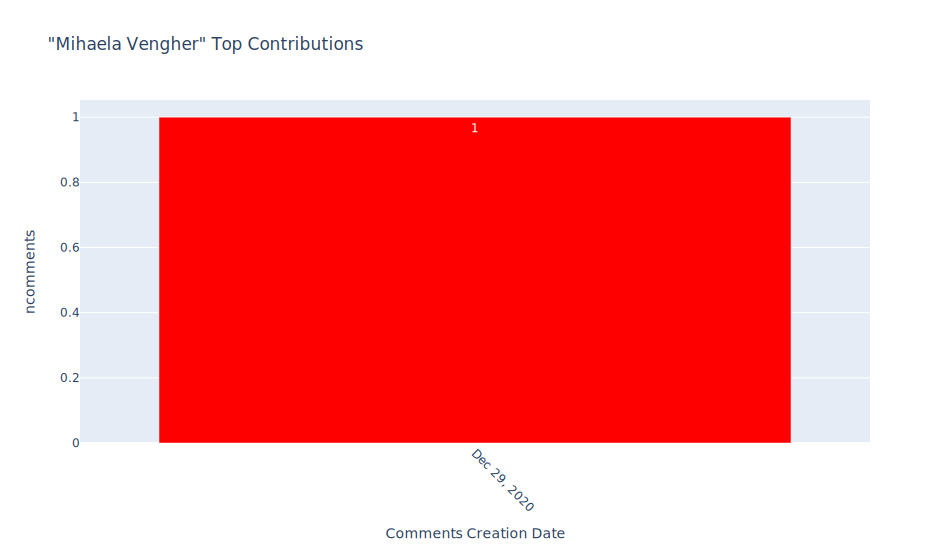

In [196]:
helpers.contr_peaks(df_comments, "Mihaela Vengher", n=3, threshold=0)

In [197]:
df_comments.query(" username == 'Deborah Skikos' ").comment.value_counts().head()

i believe she has abused johnny and all of us who have to listen to her lie and we don’t need to see her anymore. we shouldn’t have to give up l’loreal because they keep her  but i will.                  1
i will never watch the stand because of amber heard. i love stephan king, but having her a part of this when you knew about her abusing depp makes me sick. do better next time and listen to the truth.    1
i don’t like liars. they have no place to spread lies in society. liars must be stopped.                                                                                                                    1
she’s lied, abused, blackmailed her untalented arse long enough. she should be done, finished, blackballed.                                                                                                 1
if anyone has ever gone to jail for perjury then this woman deserves to go.                                                                                                     

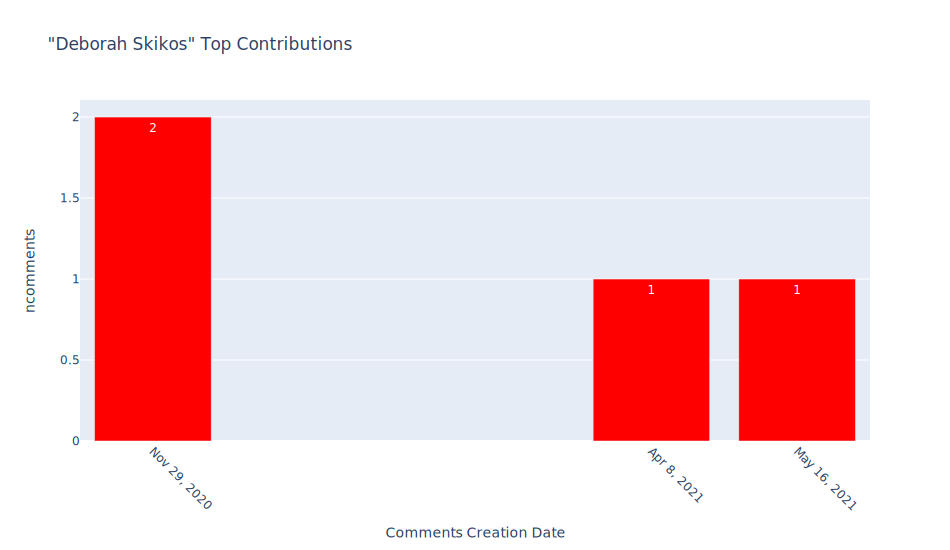

In [198]:
helpers.contr_peaks(df_comments, "Deborah Skikos", n=3, threshold=0)

In [199]:
df_comments.query(" username == 'Erni Marianne' ").comment.value_counts().head()

jemand, der andere menschen schlägt, ist keine person für werbung.                                                                                                                                                          1
look at all the evidence the judge dismissed on the males side and what he granted on her side. that was not justice. it should be looked at again.                                                                         1
i am not a victim, but my friend has been a victim of abuse and even if she has left him she still fears for her life after a lot of years. she did not leave the house alone during the first years after she left him.    1
she is an abuser and hearing her speak must be awful for real victims of abuse. she does it only for a lot of money.                                                                                                        1
Name: comment, dtype: int64

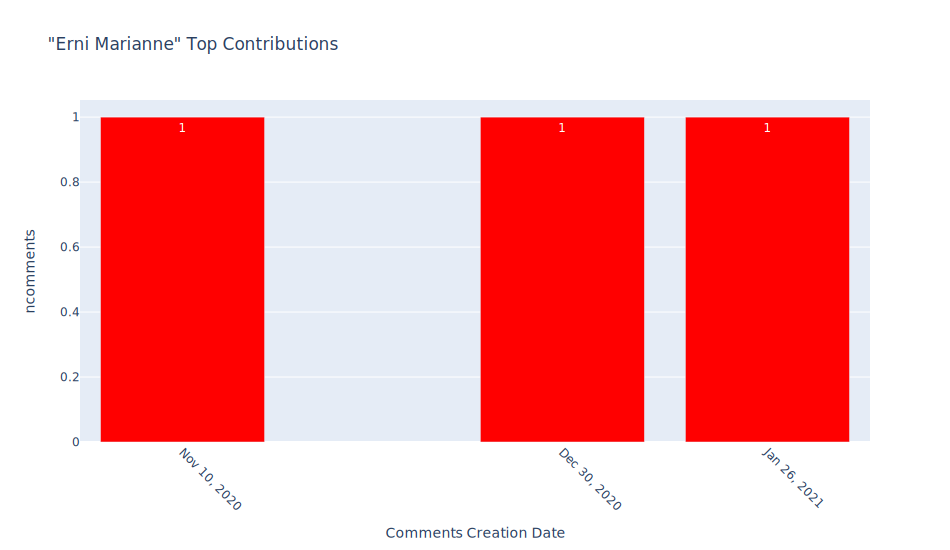

In [200]:
helpers.contr_peaks(df_comments, "Erni Marianne", n=3, threshold=0)

<br>

<a id='hate_speech'></a>
>## Hate-Speech Comments
> <ul>
 <li><a href="#threat_comments">Threat Comments</a></li>
 <li><a href="#hate_speech"><b>Hate-Speech Comments</b></a></li>
 <li><a href="#same">Same Text Same Date</a></li>
 <li><a href="#same_youtube">Same YouTube UserNames</a></li>
 <li><a href="#primarly">Primarly Text Investigations</a></li>
 </ul>

In [201]:
# To Load the dictionary of negative text    
with open('./cleaned_data/negative_text.pkl', 'rb') as f:
    neg_dict = pickle.load(f) 
    neg_text = set(neg_dict.keys())

In [202]:
neg_text = neg_text | {'narcissist', 'cancelamber', 'cancel amber', 'amber sucks', 'hate amber heard', 'scamber', 
                       'boycott amber', 'amber heard sucks', "i remind that amber heard craped on jonny depp's bed",
                       'amber heard is trash', 'deleteamber', 'delete amber', 'amber heard is a monster'}

In [203]:
# # KYS is an internet acronym standing for “kill yourself
# all_threat = {'deathto', "death to fascists", "death to mera", "death to all narcissistic", "social death to", 
#               "professional death", "death to femnazis", "death to those people", ' go die', 'die cunt', 
#               'kill heard', 'kill amber', 'kill her', 'kys fuck you amber', 'deserve', 'jail', 'prison', 
#               'pay for her crimes', 'if she wants assault she well get it', 'death to a turd', 'amberfbi',
#               'death to anybody not supporting johnny', 'kiss of death', 'death amber', 'go kill yourselves',
#               'kill all the people who disliked', 'to hell', 'tohell', 'in hell', 'inhell', "who the hell is",
#               'burn her', 'burn turd', 'her burn', 'isacriminal', 'amberfbi', 'pay for her crime'}

In [204]:
hate_speech = {'victim', 'fuck', 'ambich', 'abuser', 'liar', 'jail', 'prison', 'deserve', 'digger',
               'bullies', 'bitch', 'crazy', 'psycho', 'not a victim', 'lies'}

In [205]:
neg_text = neg_text | all_threat | hate_speech

In [206]:
len(neg_text)

200

In [207]:
neg_text

{' death',
 ' death ',
 ' raped',
 '#fuckamberheard',
 '50 million',
 '7 million',
 '@amberheard fuck you',
 'abus',
 'abuse',
 'abuser',
 'abusing',
 'aggressive',
 'aggressively pull',
 'alcoholic',
 'amber abus',
 'amber can die',
 'amber heard abus',
 'amber heard is a monster',
 'amber heard is trash',
 'amber heard sucks',
 'amber lunge',
 'amber sucks',
 'amber turd',
 'amber-heard-abus',
 'amberheardisaliar',
 'amberheardisanabuser',
 'amberheardisanabuserandliar',
 'amberisanabuser',
 'ambertheabuser',
 'amberturd',
 'ambich',
 'and to die',
 'assault',
 'assaulted johnny',
 'be killed',
 'beaten',
 'beaten up',
 'because she is a woman',
 'because she’s a woman',
 'bitch',
 'blacklisted and burned',
 'boycott amber',
 'boycottamber',
 'boycottamberheard',
 'bullies',
 'bullshit',
 'burn',
 'burn down',
 'burn in hell',
 'burn the witch',
 'burninhell',
 'burns in hell',
 'burnt pig',
 'cancel amber',
 'cancelamber',
 'catch covid and die',
 'change.org',
 'clawing',
 'clown',

In [208]:
df_hate = df_comments[df_comments.comment.str.contains('|'.join(neg_text))]
print(f'{df_hate.shape[0]} contributions, on {df_hate.petition_slug.nunique()} Slugs, made by {df_hate.username.nunique()} Users')
df_hate.head(2)

12286 contributions, on 156 Slugs, made by 10900 Users


id                                            comment  \
9380  457546085  given that:\n\n1) suicide is a leading cause o...   
9378  464729252  i think she is lying about domestic abuse agai...   

     commentable_id  likes     role                created_at   user_id  \
9380        7177154      1  comment 2016-05-29 09:07:04+00:00  22109716   
9378        7177154      4  comment 2016-06-10 20:59:34+00:00   9228048   

                      username   user_city user_country_code user_locale  \
9380  Marianna Anagnostopoulou      Athens                GR       en-US   
9378             Donna Kanzler  Montebello                US       en-US   

                      petition_slug status_manual  year       date month  \
9380  everybody-boycott-amber-heard       against  2016 2016-05-29   May   
9378  everybody-boycott-amber-heard       against  2016 2016-06-10   Jun   

      dayofmonth  hour  
9380          29     9  
9378          10    20

### A Heat Map for the Hate-Speech Comments 


Note: The Peaks on Nov 2020



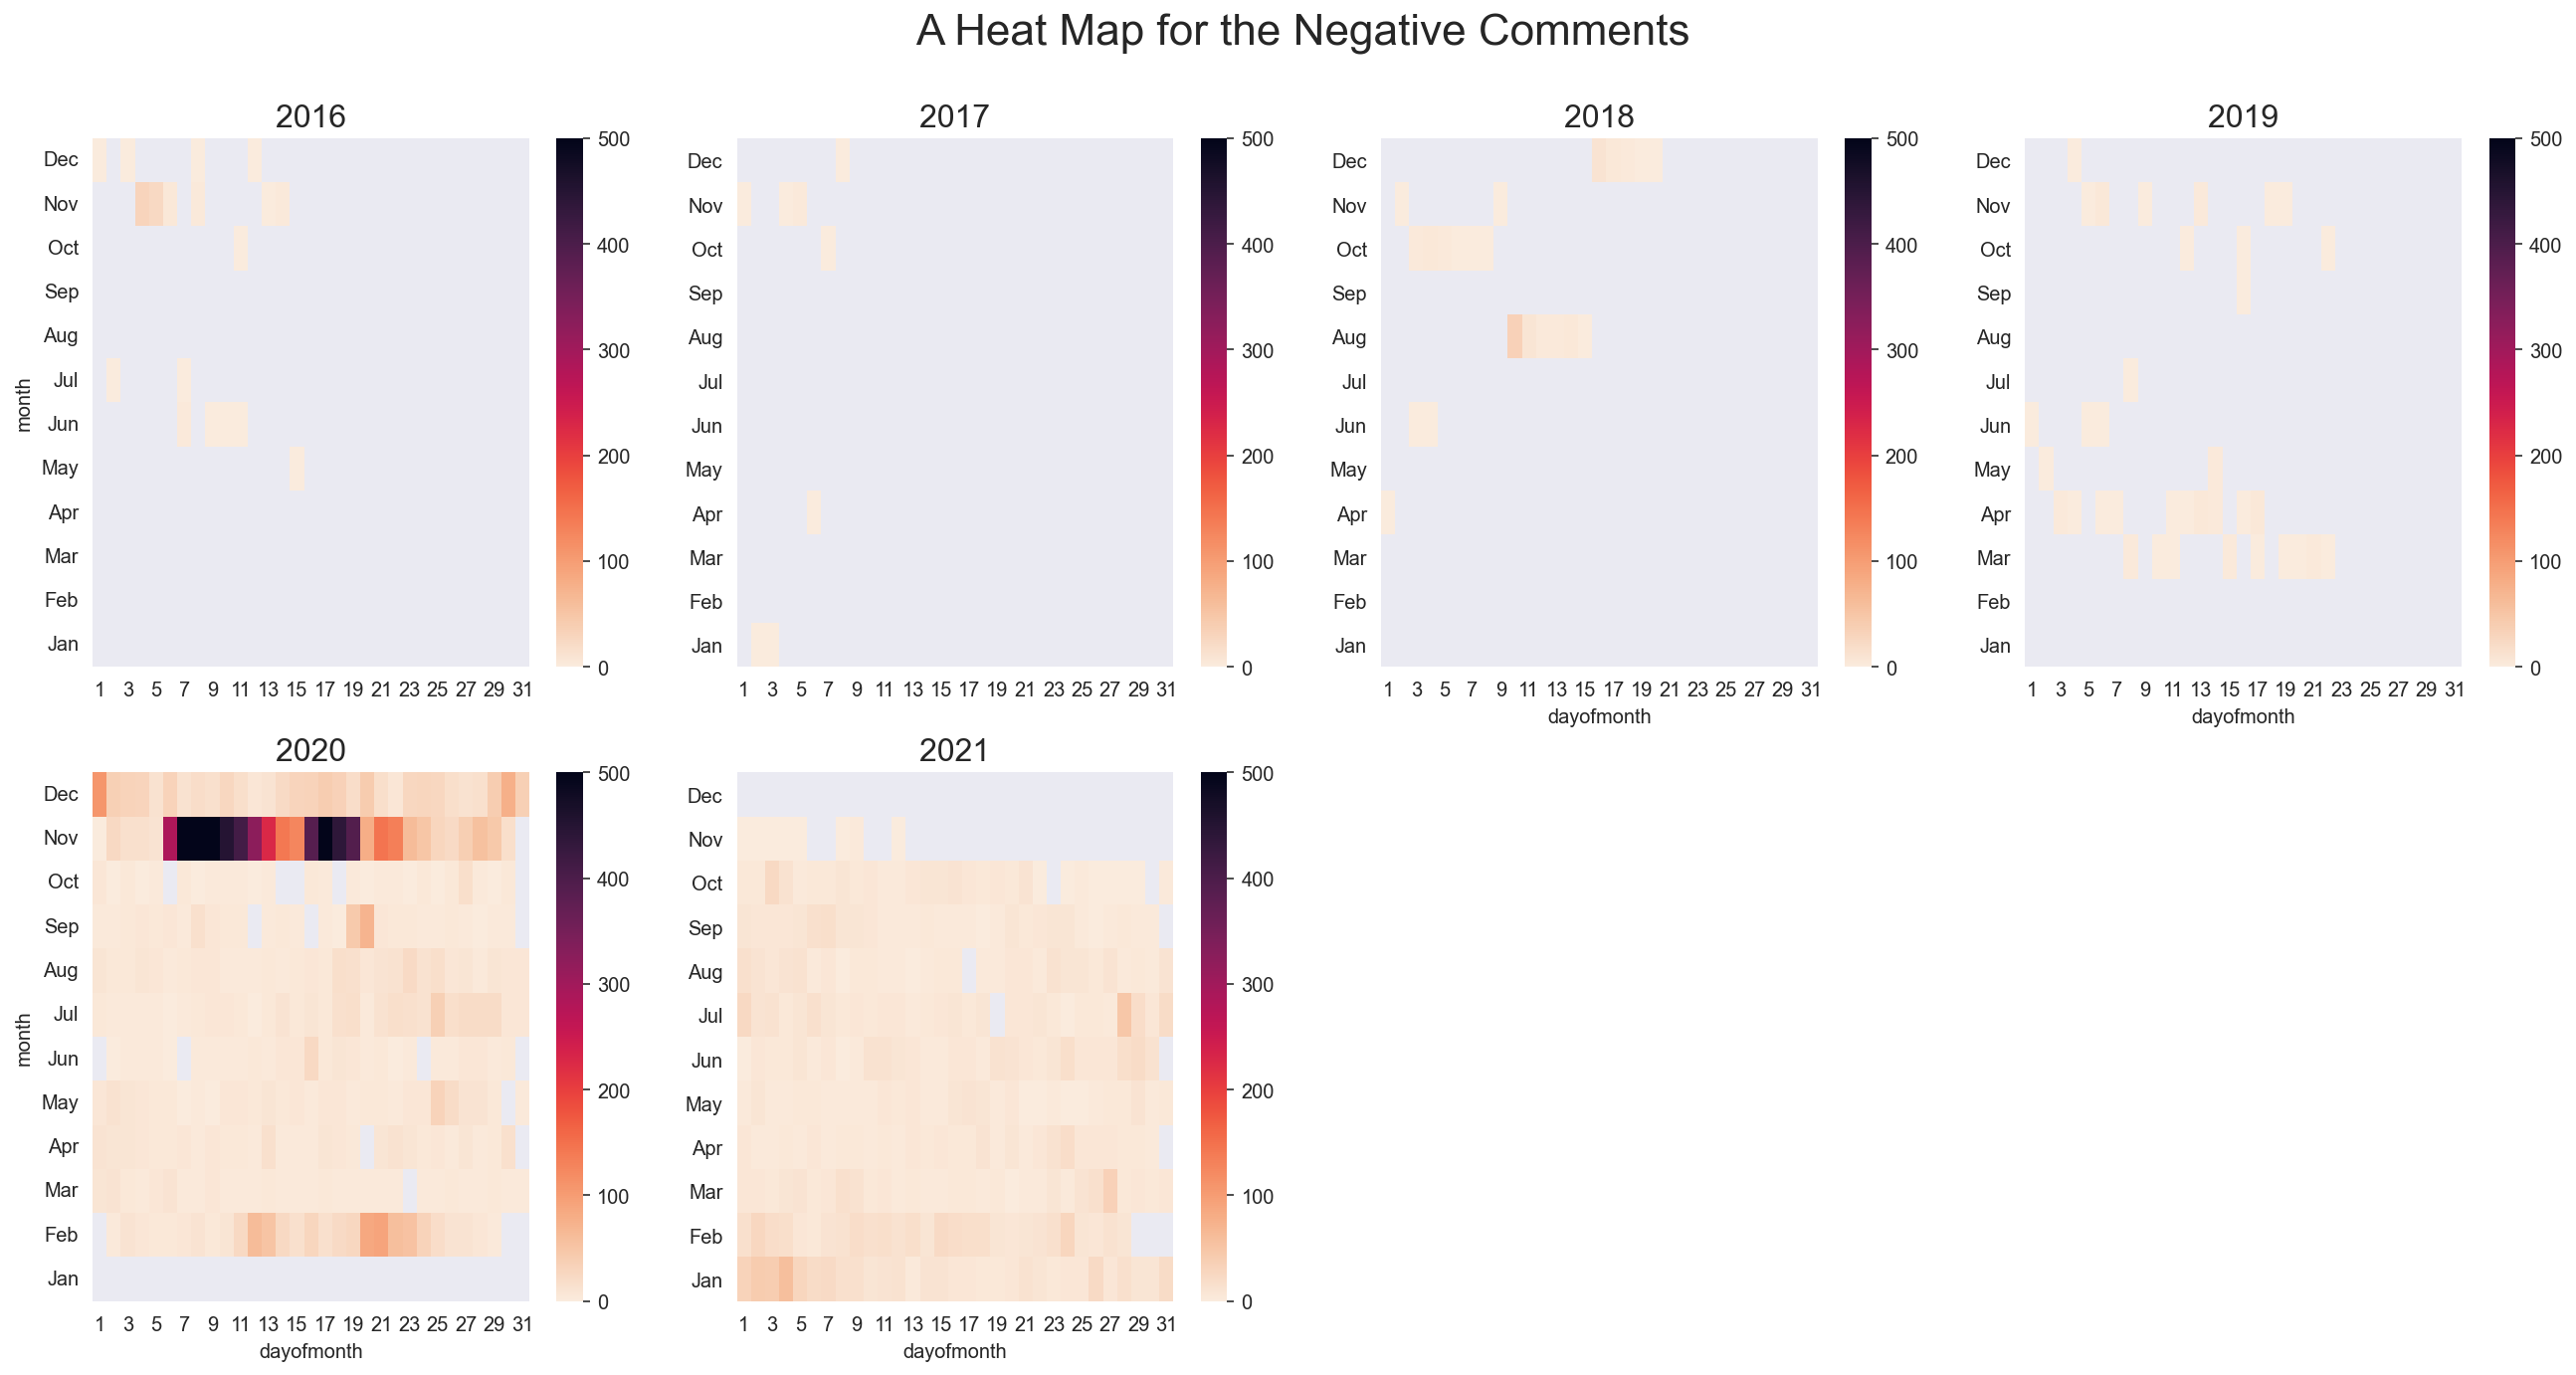

In [209]:
hate_daily = df_hate.groupby(['year', 'dayofmonth', 'month']).size().reset_index(name='ncomments')

print('\nNote: The Peaks on Nov 2020\n')
title = 'A Heat Map for the Negative Comments'
helpers.facet_heat(hate_daily, title, n_col=4, vmax=500)

### Hate-Speech Comments Peak Dates

In [210]:
hate_dates = df_hate.groupby(['date']).agg({'comment':'count', 'likes': 'sum'}).reset_index(
).rename(columns={'comment':'ncomments'}).sort_values('ncomments', ascending=False)

hate_dates.head(15)

date  ncomments  likes
351 2020-11-08        743    252
350 2020-11-07        726    505
360 2020-11-17        681    841
352 2020-11-09        569    212
353 2020-11-10        451    261
361 2020-11-18        438    658
354 2020-11-11        412    134
362 2020-11-19        391    482
359 2020-11-16        387    377
355 2020-11-12        323    124
349 2020-11-06        286    240
356 2020-11-13        228    168
364 2020-11-21        146    150
357 2020-11-14        142     73
365 2020-11-22        134    169

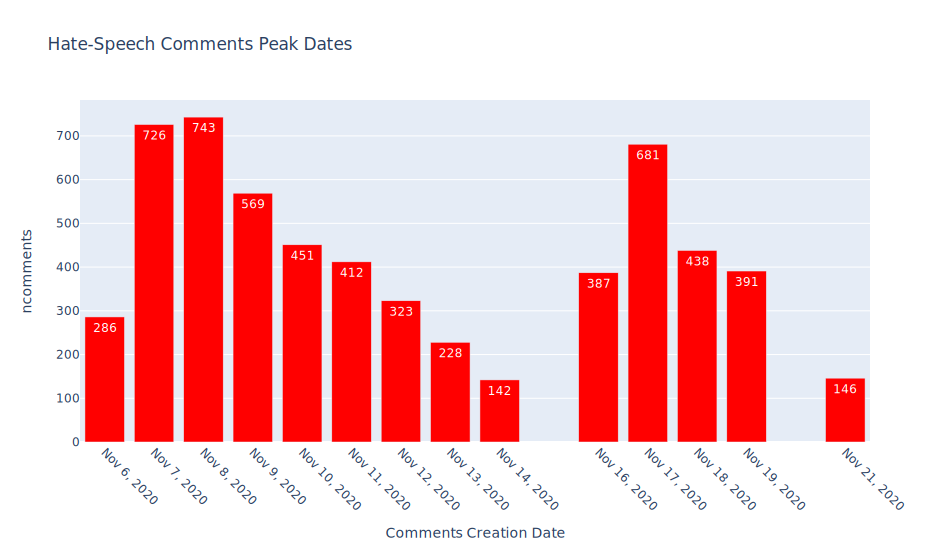

In [211]:
helpers.bar_peaks(hate_dates[['date', 'ncomments']].head(14), 
                  'Hate-Speech Comments Peak Dates')

# Most Repeated Hate-Speech Comments

In [212]:
df_hate.comment.value_counts().head(60)

fuck amber heard                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 168
fuck amber                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        7

In [213]:
df_hate.comment.value_counts()[60:].head(60)

he deserves it.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Top Users Commented with Hate-Speech keywords

In [214]:
df_hate.username.value_counts().head(10)

Brandi Granger     67
Stephanie Brown    48
Jenny Gurin        28
Marianne Lloyd     26
Sara Roberts       24
Deborah Skikos     16
Cesar Ramirez      12
Linda Lundgvist    12
Angela Marie       12
Amy Hope           10
Name: username, dtype: int64

In [215]:
df_comments.query(" username == 'Brandi Granger' ").comment.value_counts().head(60)

she's an evil abuser. justice for jd! she should be held accountable as the abuser. no way should the abuser keep her job and career and destroy the victim's career. fire her sorry ass!    67
v                                                                                                                                                                                             1
Name: comment, dtype: int64

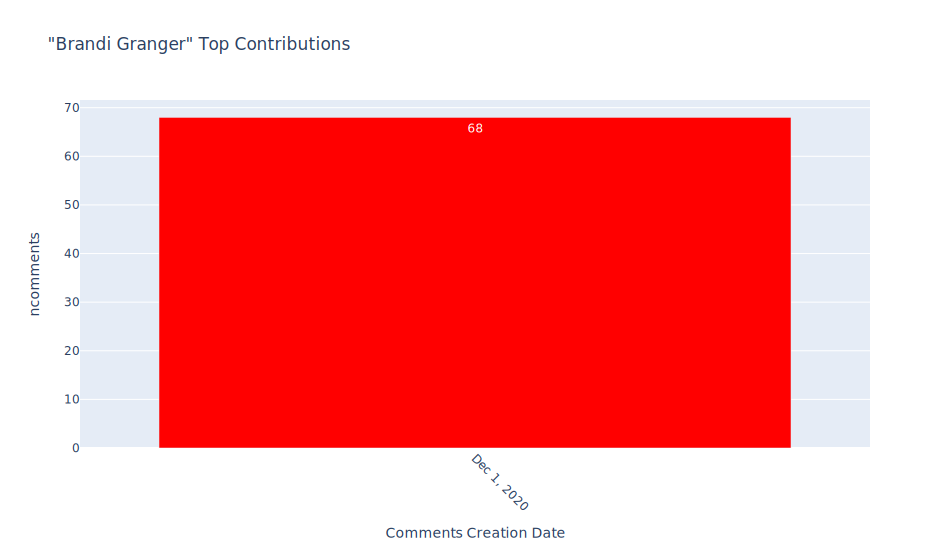

In [216]:
helpers.contr_peaks(df_comments, "Brandi Granger", n=3, threshold=0)

In [217]:
df_comments.query(" username == 'Stephanie Brown' ").comment.value_counts().head(60)

#justiceforjohnnydepp!                                                                                                                                                                                                                                                                                                                                                                                4
#johnnydeppismygrindelwald!                                                                                                                                                                                                                                                                                                                                                                           3
johnny depp is innocent!                                                                                                                                                                                                

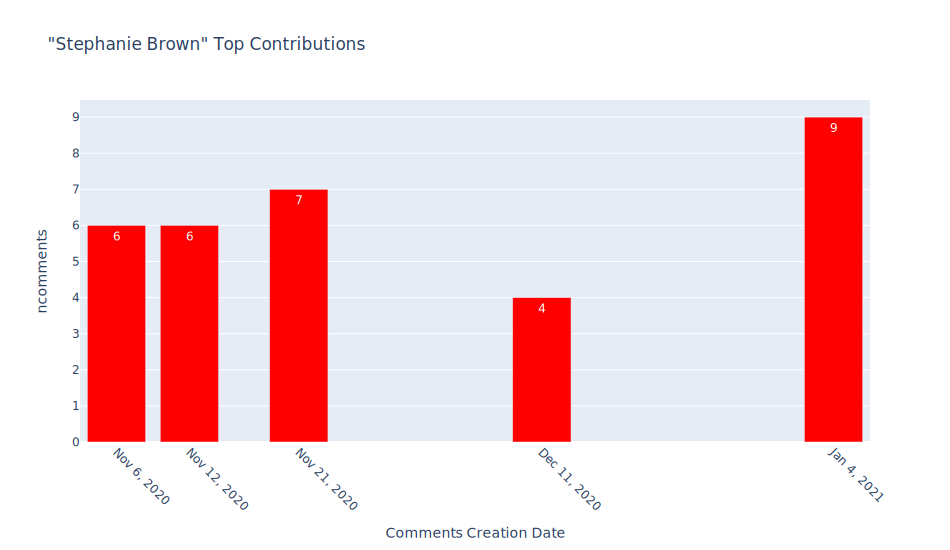

In [218]:
helpers.contr_peaks(df_comments, "Stephanie Brown", n=5, threshold=0)

In [219]:
df_comments.query(" username == 'Marianne Lloyd' ").comment.value_counts().head(60)

johnny depp was severely abused both physically and emotionally by amber heard, her free loading scum friends lived off johnny, heard tried to extort money out of johnny and blackmail him. yet the corrupt, biased judge nicol ruled in her favour because she played the victim card and lied and lied. she should be held accountable and there should be justice for johnny! johnny should get his life back!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

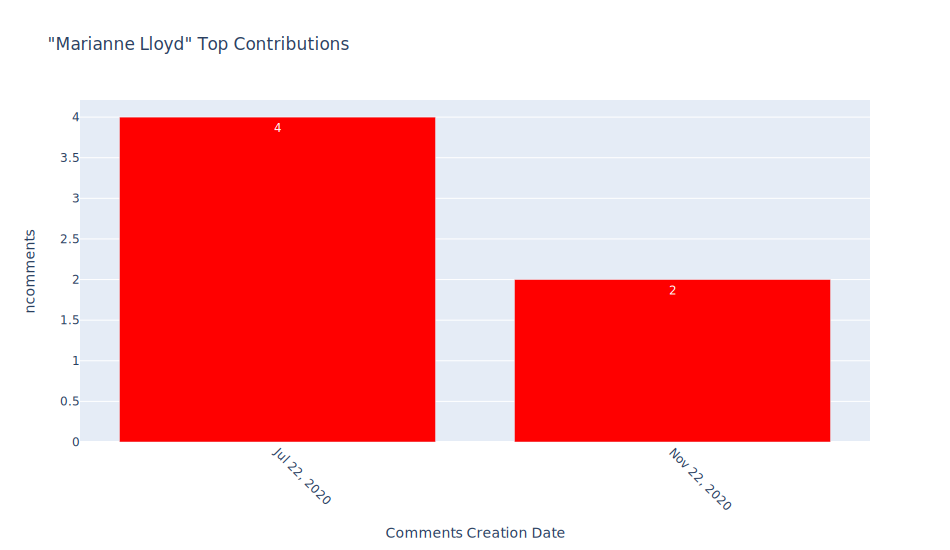

In [220]:
helpers.contr_peaks(df_comments, "Marianne Lloyd", n=2, threshold=0)

In [221]:
df_comments.query(" username == 'Sara Roberts' ").comment.value_counts().head(60)

thank you to whoever brought this tape forward! johnny has had his life ruined for the past five years because a woman made claims and fake evidence and people stupidly bought it. well, time’s up, amb!tch! #justiceforjohnny #cancelamberheard #fireamberheard #therealabuser #wearewithyoujohnny                                                                  1
she is a disgrace and a #metoo liar! she used the fact that she’s a woman and ran with it. sadly, our culture believes lying women. #istandwithjohnnydepp                                                                                                                                                                                                             1
she’s a better actress!!!                                                                                                                                                                                                                                                               

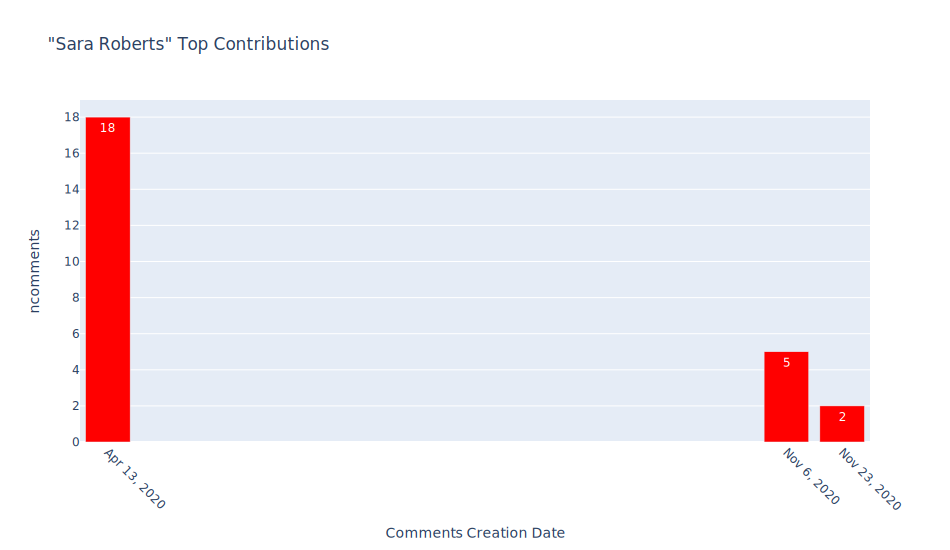

In [222]:
helpers.contr_peaks(df_comments, "Sara Roberts", n=3, threshold=0)

In [223]:
df_comments.query(" username == 'Deborah Skikos' ").comment.value_counts().head(60)

i believe she has abused johnny and all of us who have to listen to her lie and we don’t need to see her anymore. we shouldn’t have to give up l’loreal because they keep her  but i will.                                                                                                                                         1
i will never watch the stand because of amber heard. i love stephan king, but having her a part of this when you knew about her abusing depp makes me sick. do better next time and listen to the truth.                                                                                                                           1
i don’t like liars. they have no place to spread lies in society. liars must be stopped.                                                                                                                                                                                                                                           1
she’s lied, abused, black

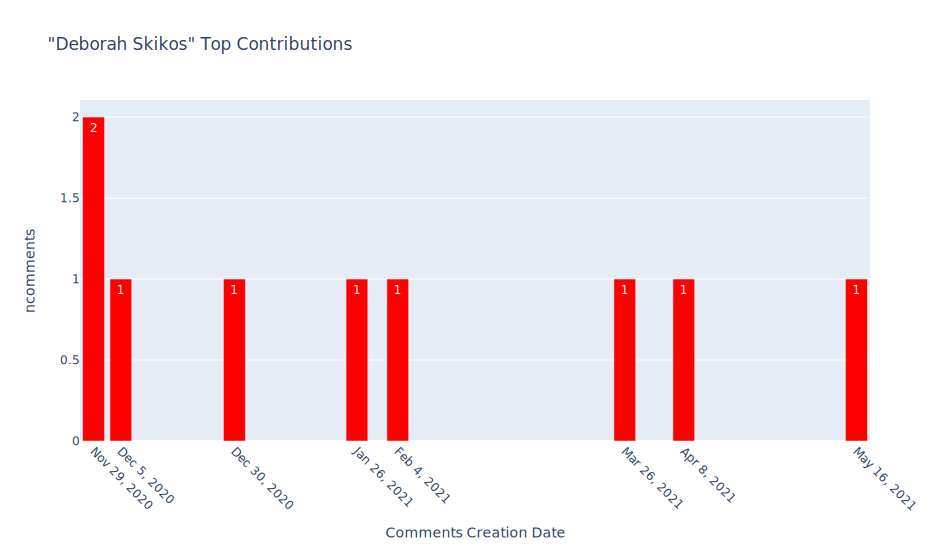

In [224]:
helpers.contr_peaks(df_comments, "Deborah Skikos", n=8, threshold=0)

In [225]:
df_comments.query(" username == 'Cesar Ramirez' ").comment.value_counts().head(60)

johnny depp is innocent, amber heard is a lier, amber heard is an abuser, johnny depp needs to comeback gellert grindelwald for fantastic beast 3.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

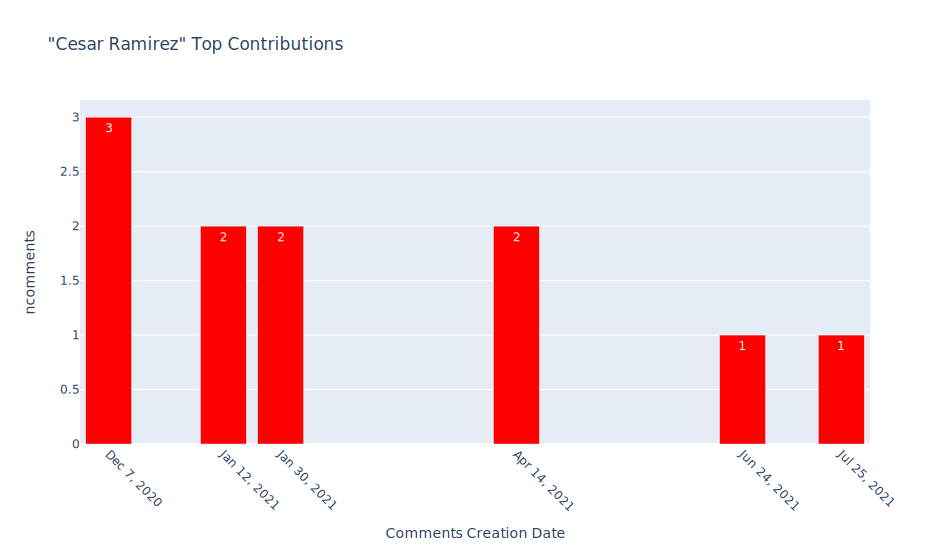

In [226]:
helpers.contr_peaks(df_comments, "Cesar Ramirez", n=6, threshold=0)

In [227]:
df_comments.query(" username == 'Linda Lundgvist' ").comment.value_counts().head(60)

he deserves justice!! i am not a bot                                                                                                                                                                 1
fire amber heard she is not a victim! i am not a bot.                                                                                                                                                1
amber heard is the domestic abuser not johnny depp. fire amber heard!! i'm not a russian bot.                                                                                                        1
the uk was a joke of a trail. johnny depp is the victim and amber heard is the domestic abuser. johnny depp deserves justice! i'm not a bot.                                                         1
if jack sparrow isn't in the movie i won't se it! and not just a cameo. i'm not a russian bot.                                                                                                       1
no-on

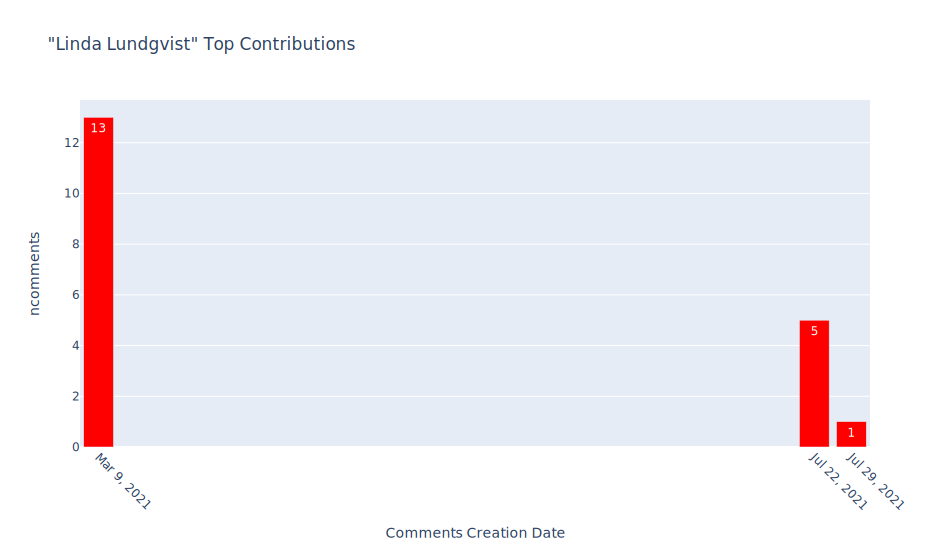

In [228]:
helpers.contr_peaks(df_comments, "Linda Lundgvist", n=5, threshold=0)

In [229]:
df_comments.query(" username == 'Angela Marie' ").comment.value_counts().head(60)

anyone that supports amber heard is supporting the perpetrator of domestic violence. #justiceforjohnnydepp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       1
anyone that supports amber heard is supporting a perpetrator of domestic violence. #justiceforjohnnydepp                                                                                                                                                                                                                                                                                                                             

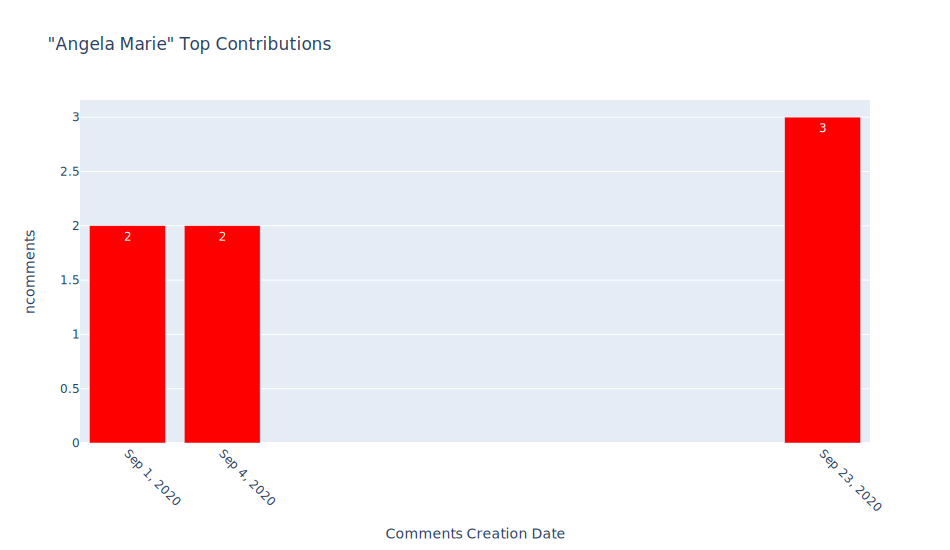

In [230]:
helpers.contr_peaks(df_comments, "Angela Marie", n=3, threshold=0)

In [231]:
df_comments.query(" username == 'Amy Hope' ").comment.value_counts().head(60)

amber is an abuser and continues to lie about it then turns around to charge and blame her ex-husband as the abuser. send her packing! don't buy ,l'oreal products until she is sacked.                                                                                                                                                                                                                                                                                                                                                                                                                                          1
i am sure when young girls look for role models, they wouldn't want to support a company or woman connected to domestic abuse.  the evidence is mounting against amber heard everyday. even her ex-employee, who had suffered a sexual attack, amber stole her story for herself to use against her own husband, a gentle, loving & generous human being!                                            

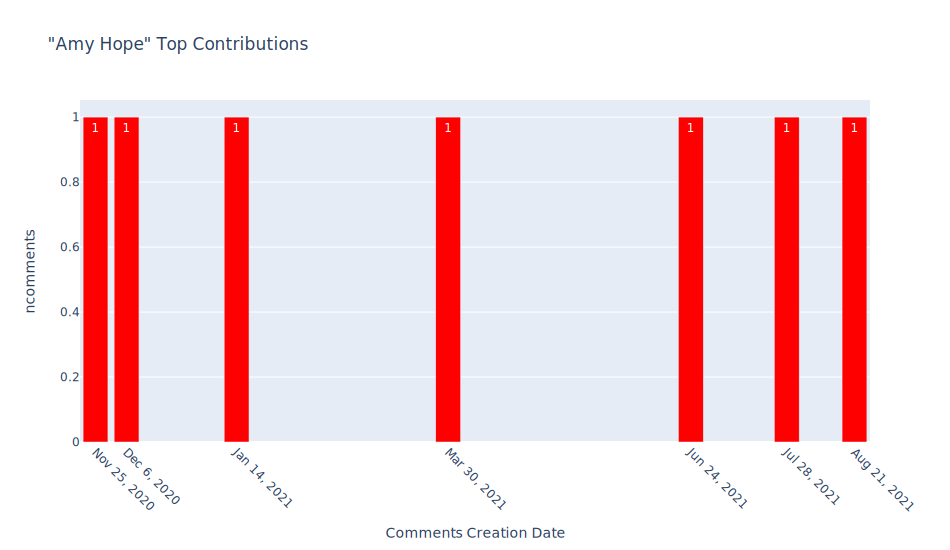

In [232]:
helpers.contr_peaks(df_comments, "Amy Hope", n=7, threshold=0)

<br>

<a id='same_youtube'></a>
> ## SAME UserNames IN YouTube Analysis
> <ul>
 <li><a href="#threat_comments">Threat Comments</a></li>
 <li><a href="#hate_speech">Hate-Speech Comments</a></li>
 <li><a href="#same">Same Text Same Date</a></li>
 <li><a href="#same_youtube"><b>Same YouTube UserNames</b></a></li>
 <li><a href="#primarly">Primarly Text Investigations</a></li>
 </ul>

In [233]:
df_comments.query(" username == 'Lindsey Depp' ").comment.value_counts().head()

i honestly don’t think that amber heard should no longer be the spokesperson for domestic violence, seeing what she did to my darling husband to be johnny depp                                                                                                                                                                    1
i’m signing this cause i believe my husband to be johnny depp is 20000% innocent and should get his role as captain jack sparrow back with sincere apology and massive rise, he should never have been kicked off if it weren’t for that evil, twisted pyschotic barn witch scamber  and her compulsive and pathological lying    1
Name: comment, dtype: int64

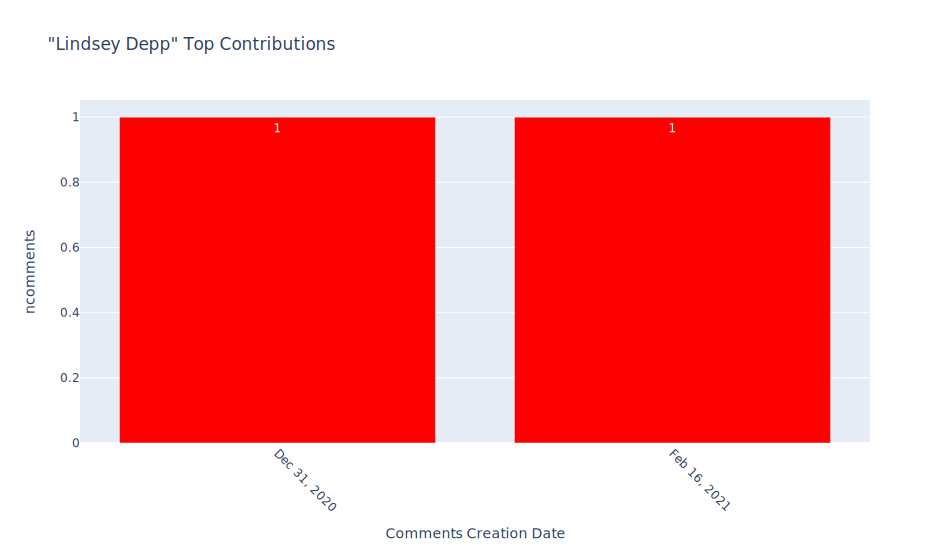

In [234]:
helpers.contr_peaks(df_comments, "Lindsey Depp", n=3, threshold=0)

In [235]:
df_comments.query(" username == 'Linda Landry' ").comment.value_counts().head()

i’m signing this petition because she is an abuser who should not be rewarded.  amber i am not being paid to sign this petition and i am not a bot and you are delusional if you think johnny’s supporters are not real people.    1
Name: comment, dtype: int64

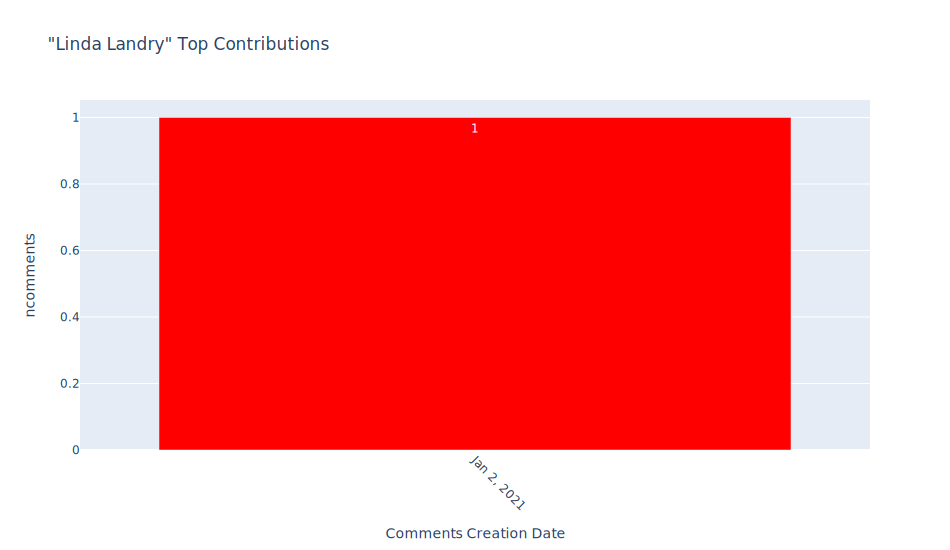

In [236]:
helpers.contr_peaks(df_comments, "Linda Landry", n=7, threshold=0)

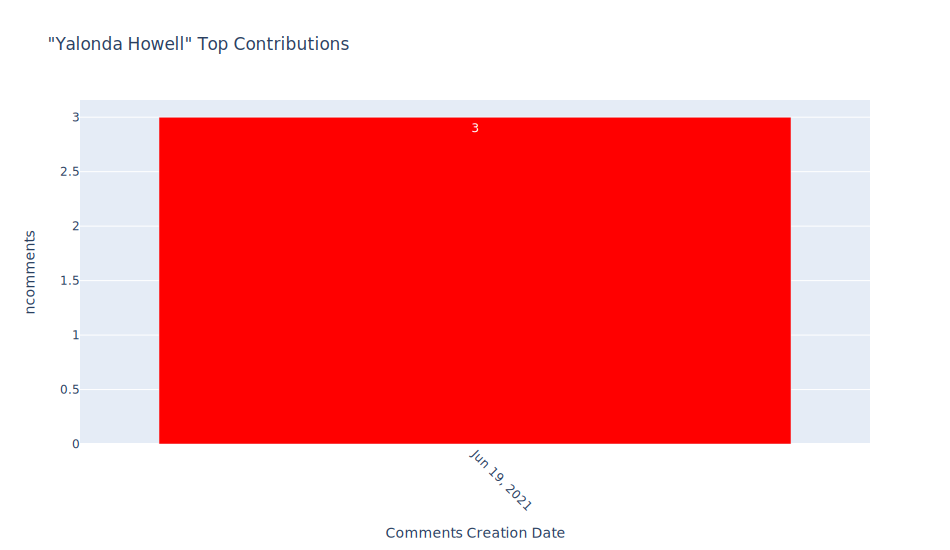

In [237]:
helpers.contr_peaks(df_comments, "Yalonda Howell", n=6, threshold=0)

In [238]:
df_hate.query(" username == 'Yalonda Howell' ").comment.value_counts().head()

boycott amber heard and aquaman to or any other warner brothers franchises disney included boycott everything this evil woman is in!!!! i would love to watch aquaman too but unfortunately amber heard everything she touches turns to career suicide i will not support a reoccurring abuser i will not support a person that pledges to donate millions of dollars too sick little kids and does not do so it was not a payment arrangement sweetheart it's a pledge full amount not payments i will not support a reoccurring abuser spokesperson husband abuser who are children is supposed to idolize as a superhero boycott everything this woman is in us fans need to show these industries that's our money that they live off of it's us that puts the money in the bank you can bank on that boycott amber heard #fire amber heard #elist amber heard #she's not even a great actress there is so many other people that you could use that would be way better than this reoccurring abusing i steal from sick children bu

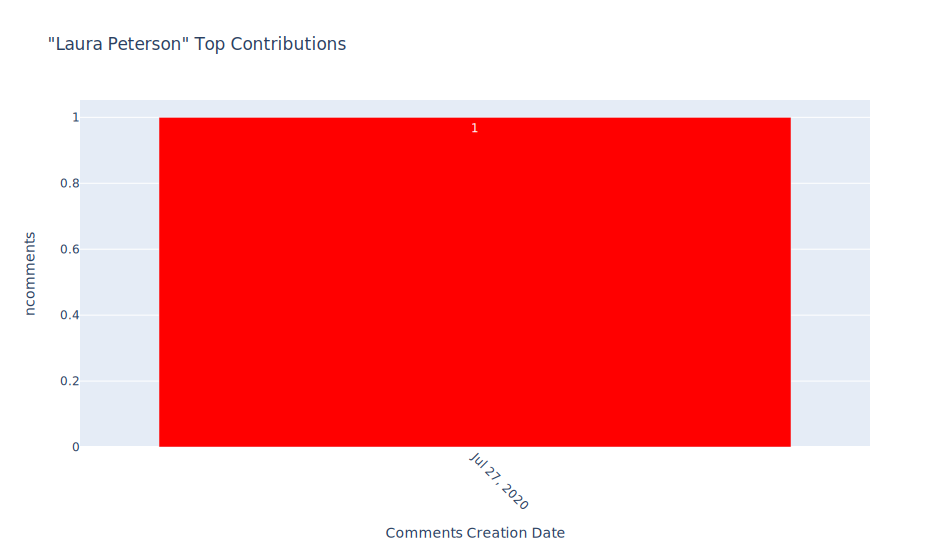

In [239]:
helpers.contr_peaks(df_comments, "Laura Peterson", n=6, threshold=0)

<br>

<a id='same'></a>
>## Same Text Same Date
> <ul>
 <li><a href="#threat_comments">Threat Comments</a></li>
 <li><a href="#hate_speech">Hate-Speech Comments</a></li>
 <li><a href="#same"><b>Same Text Same Date</b></a></li>
 <li><a href="#same_youtube">Same YouTube UserNames</a></li>
 <li><a href="#primarly">Primarly Text Investigations</a></li>
 </ul>

In [240]:
# print('\nThe Amplifications in the counts and number of likes on #justiceforjohnnydepp is quite obvious!!')
df_same = df_threat.groupby(["comment", "date"]).agg({'id':'count', 'likes':'sum'}).reset_index()
df_same.rename(columns={'id': 'ncomments'}, inplace=True) 
df_same.sort_values(["ncomments", 'date'], ascending=[False, True]).head(60)


comment       date  ncomments  \
326  i am neither russian nor a bot. amber heard ha... 2021-04-18          6   
807            stop punishing the victim of the abuse! 2020-11-10          3   
46   amber heard has a history of being abusive emo... 2020-12-19          3   
310  heard is a fucking lair... put her in jail, an... 2021-02-03          3   
72   amber heard is a liar, and johnny depp doesn’t... 2021-07-16          3   
753  she makes it look like being abused is a joke.... 2020-02-22          2   
100              amber heard is the embodiment of hell 2020-11-08          2   
202                                     burn the witch 2020-11-17          2   
689                                    she deserves it 2020-11-19          2   
814  the abused should not be punished whilst the a... 2020-11-27          2   
284  he is the victim and should not be punished fo... 2021-02-04          2   
230  equal rights. johnny lost his rolls, equally s... 2021-07-01          2   
676  she abused a man 23 years older than her and l... 2021-08-09          2   
60   amber heard is a cruel and vicious woman who h... 2016-07-03          1   
379  i never trusted that scumbag bridezilla she sh... 2016-11-05          1   
149  amber tried to extort $ from johnny by demandi... 2016-11-06          1   
189  because no man, not even johnny depp, should b... 2016-11-07          1   
548  johnny depp is an asshole that shoud be thrown... 2017-11-22          1   
59   amber heard is a criminal...supporting crimina... 2018-08-16          1   
122  amber heard was arrested and spend a night in ... 2018-12-26          1   
123  amber heard was arrested for domestic abuse ag... 2018-12-26          1   
785  she was arrested for dv against her girlfriend... 2018-12-26          1   
642  no one who has been arrested and held in a jai... 2018-12-27          1   
267  he has done such amazing work, and i'm sure ha... 2019-04-24          1   
592  johnny is the victim we need to stop punishing... 2019-04-24          1   
369  i have never followed celebrity problems in my... 2019-10-19          1   
227  ember heard is a good actor. in the other hand... 2019-11-11          1   
332              i am signing because she deserves it. 2019-11-11          1   
519  johnny depp deserves justice. his abuser deser... 2020-02-03          1   
504  i’ve loved this man since i was little. he is ... 2020-02-04          1   
156  any abuser shouldn't escape law. she's proven ... 2020-02-06          1   
667  put her ads in prison, get her out of fame for... 2020-02-10          1   
769  she needs to pay for her crimes. all of her cr... 2020-02-11          1   
783  she should not be the spokesman for any high p... 2020-02-11          1   
22   abusers should be punished for their crimes. t... 2020-02-12          1   
237                         fire her, send her to jail 2020-02-12          1   
314         her disgusting actions should be punished. 2020-02-12          1   
756                       she must serve time in jail. 2020-02-12          1   
779  she should face the same punishment that depp ... 2020-02-12          1   
801  society immediately assumed amber heard was a ... 2020-02-12          1   
61   amber heard is a despicable person and should ... 2020-02-13          1   
380  i really find abhorrent when women use their g... 2020-02-13          1   
800                      simply put: shell go to jail! 2020-02-13          1   
868  this woman does not deserve to be a spokespers... 2020-02-13          1   
139  amber is the most abusive, lied and have past ... 2020-02-14          1   
403  i'm not a big fan of "cancel culture" because ... 2020-02-14          1   
154  amber, you destroyed the career of jonny depp ... 2020-02-15          1   
214  domestic abuse should be punished equally betw... 2020-02-16          1   
724  she is a bad person, she abused johnny depp ve... 2020-02-16          1   
486  i’m sick of this injustice. and to think m

In [241]:
df_same.comment.value_counts().head(20)

she deserves it                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

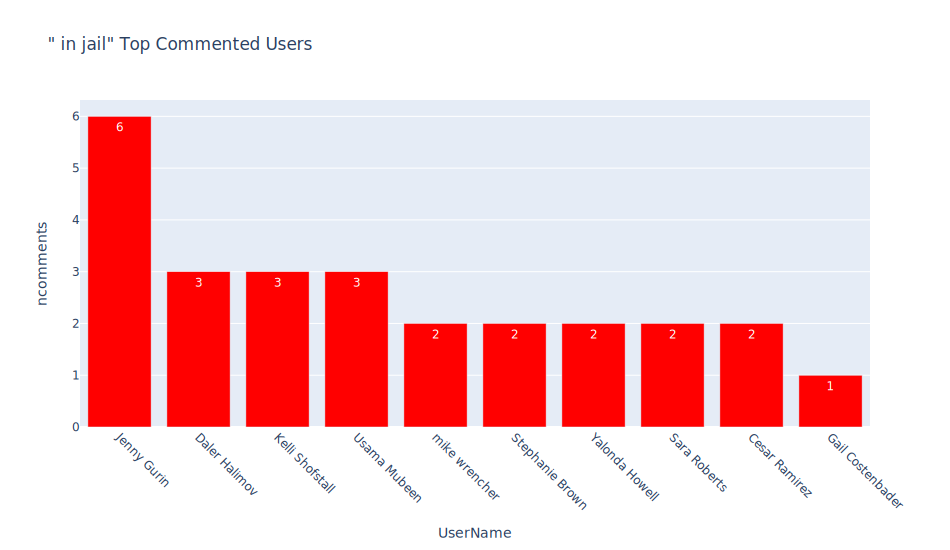

In [242]:
# importlib.reload(helpers)
helpers.users_peaks(df_comments, ' in jail', n=10, threshold=0, mode='contain')

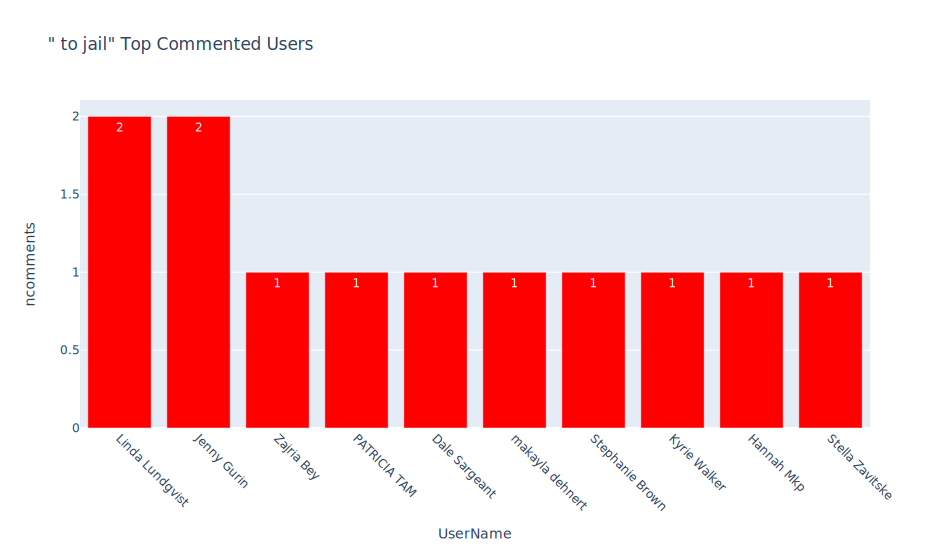

In [243]:
helpers.users_peaks(df_comments, ' to jail', n=10, threshold=0, mode='contain')

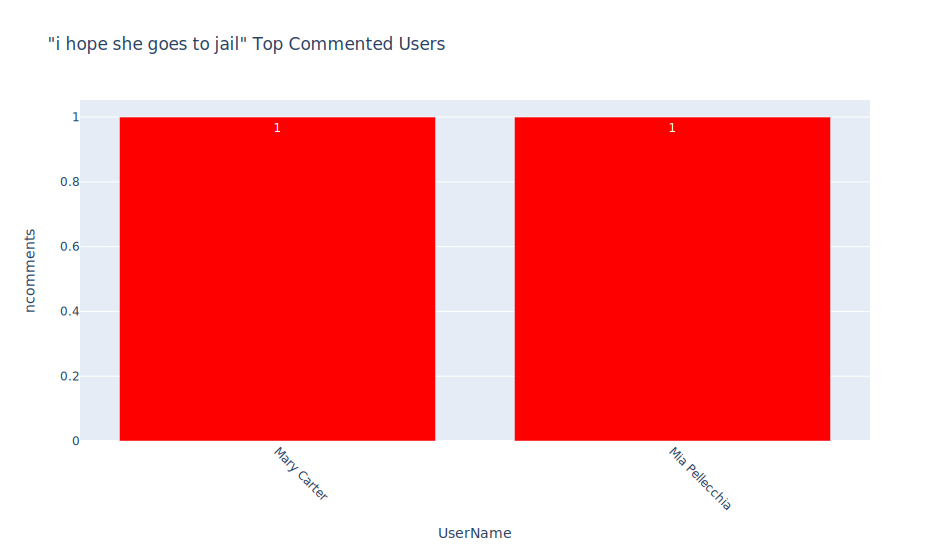

In [244]:
helpers.users_peaks(df_comments, 'i hope she goes to jail', n=10, threshold=0, mode='contain')

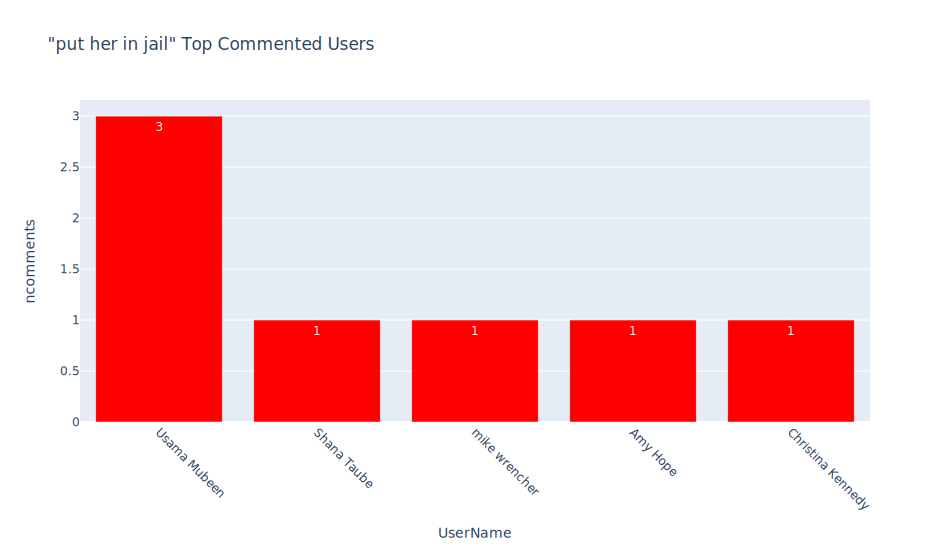

In [245]:
helpers.users_peaks(df_comments, 'put her in jail', n=10, threshold=0, mode='contain')

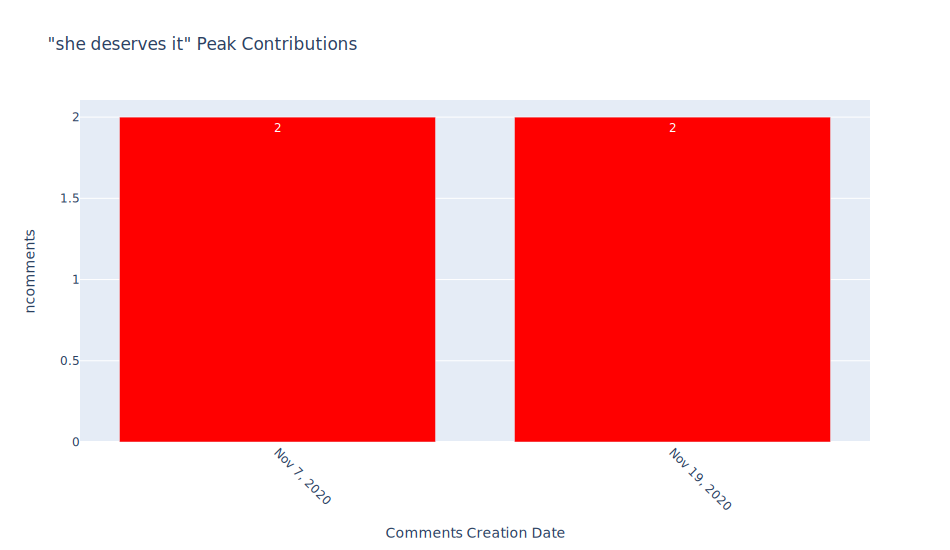

In [246]:
helpers.text_peaks(df_comments, 'she deserves it', n=2, threshold=0, mode='contain')

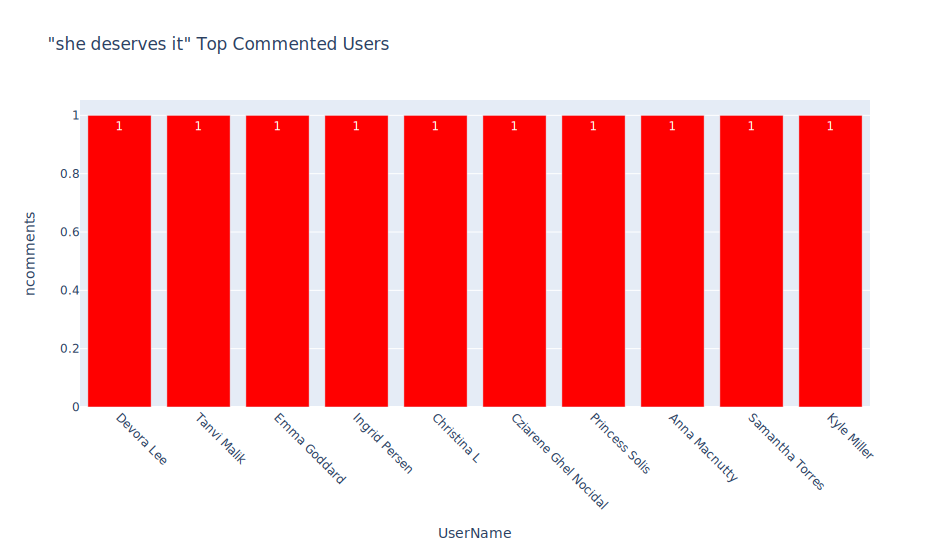

In [247]:
helpers.users_peaks(df_comments, 'she deserves it', n=10, threshold=0, mode='contain')

### Threat Text Contains "jail" --> 262

In [248]:
df_all_jail = df_threat[df_threat.comment.str.contains('jail')]
print(f'{df_all_jail.shape[0]} contributions, on {df_all_jail.petition_slug.nunique()} Slugs, made by {df_all_jail.username.nunique()} Users')
df_all_jail.head(2)


262 contributions, on 39 Slugs, made by 238 Users


id                                            comment  \
1181  532266899  i never trusted that scumbag bridezilla she sh...   
1096  533411285  because no man, not even johnny depp, should b...   

     commentable_id  likes     role                created_at    user_id  \
1181        8655098      2  comment 2016-11-05 19:34:11+00:00   28268805   
1096        8655098      2  comment 2016-11-07 21:02:32+00:00  117524405   

              username user_city user_country_code user_locale  \
1181  Gail Costenbader    Edison                US       en-US   
1096     Lori Hatfield    Quincy                US       en-US   

                                          petition_slug status_manual  year  \
1181  kate-quinn-support-jk-rowling-s-fantastic-beas...       against  2016   
1096  kate-quinn-support-jk-rowling-s-fantastic-beas...       against  2016   

           date month  dayofmonth  hour  
1181 2016-11-05   Nov           5    19  
1096 2016-11-07   Nov           7    21

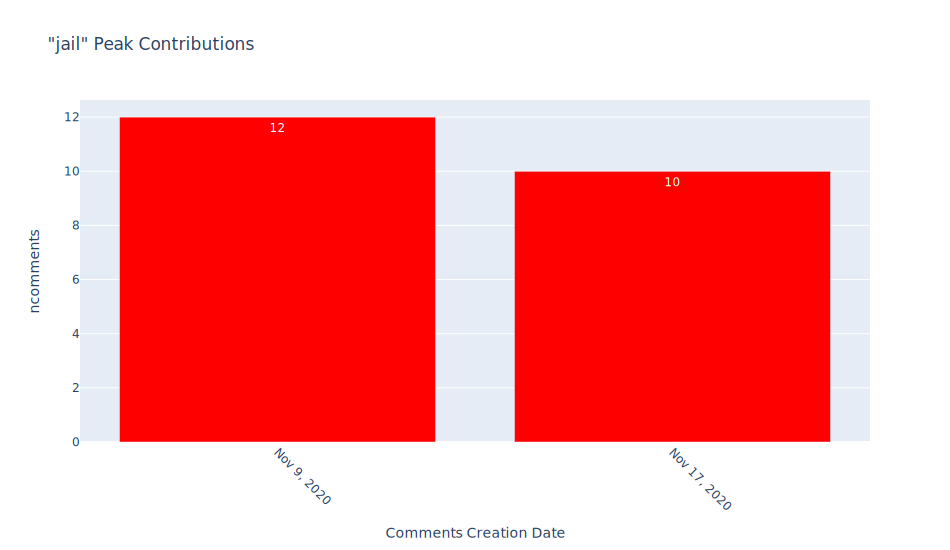

In [249]:
helpers.text_peaks(df_comments, 'jail', n=2, threshold=0, mode='contain')

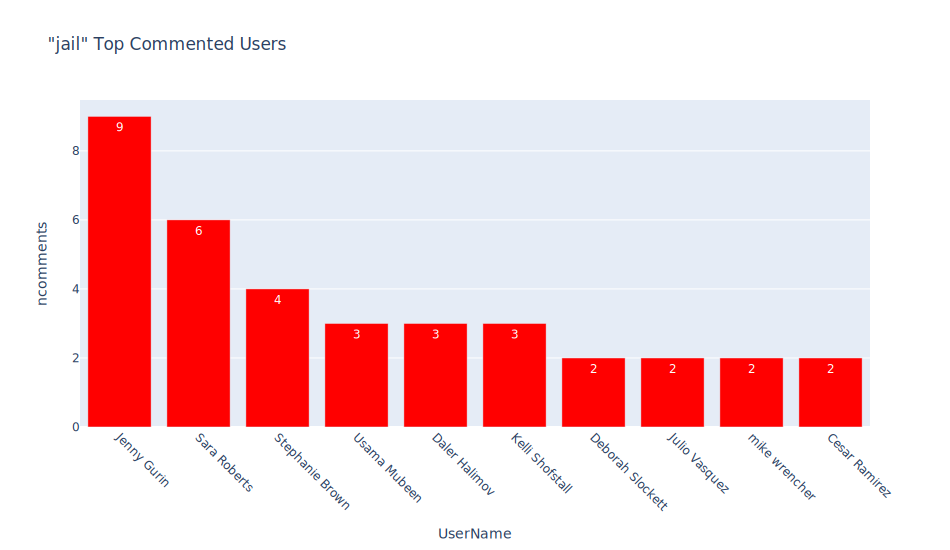

In [250]:
helpers.users_peaks(df_comments, 'jail', n=10, threshold=0, mode='contain')

### Threat Text Containing "hell" --> 57

In [251]:
df_all_hell = df_threat[df_threat.comment.str.contains('hell')]
print(f'{df_all_hell.shape[0]} contributions, on {df_all_hell.petition_slug.nunique()} Slugs, made by {df_all_hell.username.nunique()} Users')
df_all_hell.head()


57 contributions, on 14 Slugs, made by 54 Users


id                                            comment  \
21030  774758050  this woman does not deserve to be a spokespers...   
21016  774769768                      simply put: shell go to jail!   
20636  775278763                        let these women rot in hell   
20553  775324595  i don’t like narcissistic monsters and refuse ...   
26336  776015891  i have watched johnny depp forever and i have ...   

      commentable_id  likes     role                created_at    user_id  \
21030       20196023      2  comment 2020-02-13 16:54:49+00:00  234882436   
21016       20196023      0  comment 2020-02-13 21:08:05+00:00  962410453   
20636       20196023      0  comment 2020-02-21 15:40:27+00:00  421554602   
20553       20196023      0  comment 2020-02-22 09:30:20+00:00  756899140   
26336       20186707      1  comment 2020-03-03 13:30:37+00:00  628597346   

                   username user_city user_country_code user_locale  \
21030       Jaime Halliwell     Wigan                GB       en-GB   
21016     Fatima Gattwinkel    Jeddah                SA       en-GB   
20636  Premm Krishna Shenoy       NaN                IN       en-IN   
20553        Nicole Gaskett       NaN                AU       en-AU   
26336           Jessica Cox   Spokane                US       en-US   

                                           petition_slug status_manual  year  \
21030  l-oréal-remove-amber-heard-as-l-oreal-spokespe...       against  2020   
21016  l-oréal-remove-amber-heard-as-l-oreal-spokespe...       against  2020   
20636  l-oréal-remove-amber-heard-as-l-oreal-spokespe...       against  2020   
20553  l-oréal-remove-amber-heard-as-l-oreal-spokespe...       against  2020   
26336                            justice-for-johnny-depp       against  2020   

            date month  dayofmonth  hour  
21030 2020-02-13   Feb          13    16  
21016 2020-02-13   Feb          13    21  
20636 2020-02-21   Feb          21    15  
20553 2020-02-22   Feb          22     9  
26336 2020-03-03   Mar           3    13

In [252]:
df_all_hell.comment.value_counts().head(60)

amber heard is the embodiment of hell                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2
go to hell amber                                   

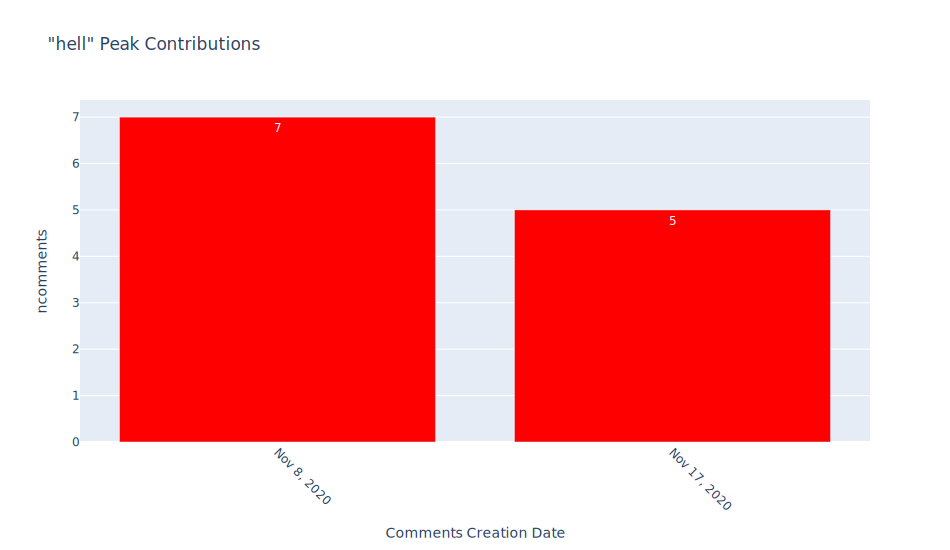

In [253]:
helpers.text_peaks(df_threat, 'hell', n=2, threshold=0, mode='contain')

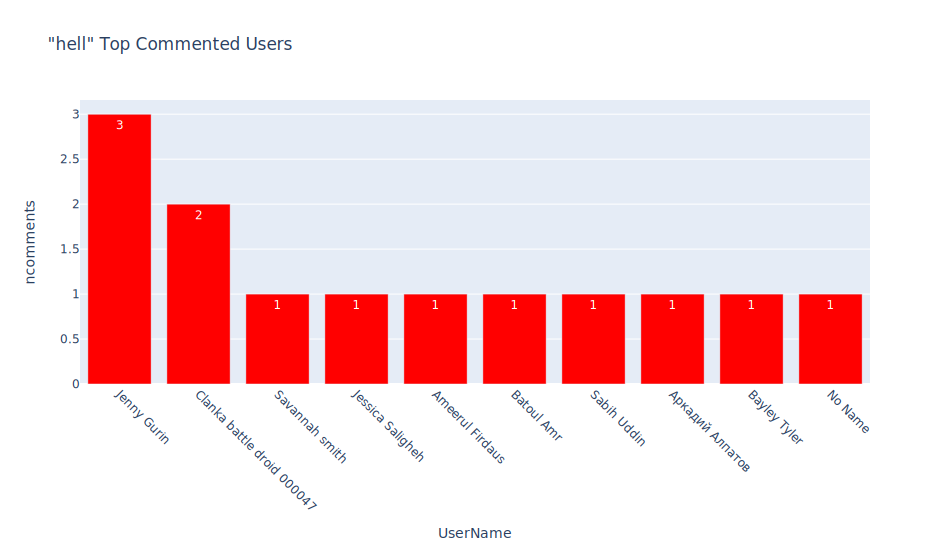

In [254]:
helpers.users_peaks(df_threat, 'hell', n=10, threshold=0,  mode='contain')

<a id='primarly'></a>
> ## Primarly Text Investigations
> <ul>
 <li><a href="#threat_comments">Threat Comments</a></li>
 <li><a href="#hate_speech">Hate-Speech Comments</a></li>
 <li><a href="#same">Same Text Same Date</a></li>
 <li><a href="#same_youtube">Same YouTube UserNames</a></li>
 <li><a href="#primarly"><b>Primarly Text Investigations</b></a></li>
 </ul>

## NOTE: "These areas are extracted from the text to help in extracting the keywords to be used in the analysis"

In [255]:
df_amber = df_comments[df_comments.comment.str.contains('amber')]

In [256]:
# # KYS is an internet acronym standing for “kill yourself
# threat_text = {' death', ' death ', 'burn', 'burninhell', 'burn in hell', 'kys', ' go kys', ' raped', 'get raped', 
#                'go die', 'diecunt', 'go to hell', 'gotohell', 'beaten', 'beaten up', 'deserves it', 'kill amber',
#                'kill her', 'deathtoamber', 'death to amber', 'to death amber', 'she’s trying to kill him',
#                'kill yourself', ' deserves', 'ambich'}

In [257]:
# threat_text = {' go die', 'die cunt', 'kill heard', 'kill her', 'kill amber', 'kys fuck you amber', 'deathto', 
#                'death to fascists', 'death to a turd', 'death to mera', 'death to all narcissistic', ' hell',
#                'death to anybody not supporting johnny', 'death to femnazis', 'kiss of death', 'burn', 
#                'deserve', 'death amber', 'go kill yourselves', 'kill all the people who disliked'}

In [258]:
# all_threat = death_kill | burn_hell | crime_jail

# Death, Die, Kill & Murder

In [259]:
death_kill = {'death to', 'die amber', 'catch covid and die', 'she dies', 'and to die', 
              'die amber', 'will murder', 'amber can die', 'kill yourself', 'kill herself', 'kill amber',
              'be killed', 'killher'}

In [260]:
df_comments[df_comments.comment.str.contains('deathto')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [261]:
df_comments[df_comments.comment.str.contains('death to')].comment.value_counts().head(60)

in this house we hate abusers! death to her career, she deserves to be in jail!!                                                                         1
amber heard is not telling the truth! she cut his finger off and antagonized him shortly after his mother’s  death to get money and fame for herself.    1
Name: comment, dtype: int64

In [262]:
df_amber[df_amber.comment.str.contains('she dies')].comment.value_counts().head(60)

i hate amber heard , does can that woman ruin every mans lives, i hope she dies quickly and goes to hell , to hell with you , amber heard !!!!!!!!!    1
i love dc comics and want to watch this movie, but not with amber heard as queen of atlantis. maybe if she dies at the very beginning.                 1
Name: comment, dtype: int64

In [263]:
df_amber[df_amber.comment.str.contains('and to die')].comment.value_counts().head(60)

because amber heard is a bitch who deserves to have her career ruined and to die and burn in hell    1
Name: comment, dtype: int64

In [264]:
df_amber[df_amber.comment.str.contains('amber can die')].comment.value_counts().head(60)

johnny depp deserves an apology and his job back from warner bros. amber can die for all we care.    1
Name: comment, dtype: int64

In [265]:
df_amber[df_amber.comment.str.contains('die amber')].comment.value_counts().head(60)

eat shit and die amber :)))                                                        1
no one should be paying this abusive cunt anything. hope you die amber heard ✌    1
Name: comment, dtype: int64

In [266]:
df_amber[df_amber.comment.str.contains('die')].comment.value_counts().head(60)

the fact that amber filed for divorce the next business day after johnny's mom died shows how callous she is. then asking for $50k/mo & when she didn't get it, then she files a restraining order a week after the alleged incident, asking for $ again?! that's not what ro is for! not to mention moving bruises! then she claims police are lying in 2 different police departments in 2 different states for 2 different incidents? amber is the one arrested for domestic violence! please sign & share!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [267]:
# df_amber[df_amber.comment.str.contains('death')].comment.value_counts().head(60)

- amber heard is a bitch and needs to catch covid and die.
- i love dc comics and want to watch this movie, but not with amber heard as queen of atlantis. maybe if she dies at the very beginning.
- because amber heard is a bitch who deserves to have her career ruined and to die and burn in hell 
- amber heard is a heartless lying manipulative bitch and i would rather die than watch her on screen
- eat shit and die amber :)))
- no one should be paying this abusive cunt anything. hope you die amber heard
- johnny depp deserves an apology and his job back from warner bros. amber can die for all we care.
- because he’s just about the best actor out there and it was literally proven he did nothing wrong and it was all amber i’ll be the in the crew of captain jack till the day i die 
- i hate amber heard , does can that woman ruin every mans lives, i hope she dies quickly and goes to hell , to hell with you , amber heard !!!!!!!!! 

In [268]:
df_amber[df_amber.comment.str.contains('die')].comment.value_counts().head(60)

the fact that amber filed for divorce the next business day after johnny's mom died shows how callous she is. then asking for $50k/mo & when she didn't get it, then she files a restraining order a week after the alleged incident, asking for $ again?! that's not what ro is for! not to mention moving bruises! then she claims police are lying in 2 different police departments in 2 different states for 2 different incidents? amber is the one arrested for domestic violence! please sign & share!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# Kill

- 'kill yourself'
- 'kill herself'
- 'kill amber'
- 'be killed'
- 'killher'

- amber heard is an asshole go kill yourself amber!!!
- amber heard and io are abusers! amber almost killed johnny depp and needs to be put away for life!
- amber heard can kill kill herself
- if this doesnt work i'm hiring an assasin to kill amber
- i don't want my money supporting a psychopath like amber heard so i will never watch aquaman 2. i also will not support a studio that chooses a serial killer in training over millions of fans.
- amber heard should be killed
- amber heard has committed the crime of abuse causing great bodily harm. she has also lied in court to frame an innocent man. she abused her wife her assistant, her sister and her parents. it’s suspected she has abused cara and elon. she needs to be stopped as much as a serial killer can’t stop and needs to be stopped.
- because amber heard is a cancer to everything that she touches she's a virus and wants to kill everything that she puts her hand to no good comes out of knowing this woman
- killher

In [269]:
df_amber[df_amber.comment.str.contains('kill')].comment.value_counts().head(60)

i'm signing because i am sick of this! why won't she just leave him alone??? the bitch had her time and say! she's been proven to be a liar and guilty of everything she's accused him of doing not just to him but to a lot of people! i hope amber heard is fucking proud of herself. johnny deserve better than this and he deserves as much love and support and if he loses this then i hope she loses her whole career too!  i can't believe she's so hellbent on killing his career just to get attention while real victims like johnny are penalized or ignored                           1
i’m from the uk where we had a presenter named caroline flack slaughtered by the press and dropped by her tv bosses, because of something she did in her personal life. as a result, she killed herself. even if amber heard did hit johnny depp, that’s their own personal business and doesn’t have anything to do with anyone else. certainly not her job. jesus, convicts still have jobs and she hasn’t even been found guilty

In [270]:
df_comments[df_comments.comment.str.contains('kys')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [271]:
df_comments[df_comments.comment.str.contains('killher')].comment.value_counts().head(60)

killher    1
Name: comment, dtype: int64

In [272]:
df_comments[df_comments.comment.str.contains('kill her')].comment.value_counts().head(60)

amber heard can kill kill herself    1
Name: comment, dtype: int64

In [273]:
df_comments[df_comments.comment.str.contains('kill amber')].comment.value_counts().head(60)

if this doesnt work i'm hiring an assasin to kill amber    1
Name: comment, dtype: int64

In [274]:
# df_comments[df_comments.comment.str.contains('serial killer')].comment.value_counts().head(60)

# Murder

- amber is a lying bitch and i swear if she fucking wins i will murder something. 

In [275]:
df_amber[df_amber.comment.str.contains('murder')].comment.value_counts().head(60)

i am a real domestic abuse survivor and my best friend was murdered by her abuser. amber heard has no clue. she's making a mockery of real victims.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                1
dame judi dench chose him for all 3 of her choices if she could have dinner with anybody.  obviously he impressed her.  i think she appears a good deal smarter than the judge in this case.  javier bardem also speaks to what a kind, gentle soul he is.  i remember many years ago when darryl hannah accused jackson browne of 

In [276]:
df_amber[df_amber.comment.str.contains('will murder')].comment.value_counts().head(60)

amber is a lying bitch and i swear if she fucking wins i will murder something.    1
Name: comment, dtype: int64

<br>

# Burn & Hell

In [277]:
burn_hell = {'burn the witch', 'she burns', 'blacklisted and burned', 'in hell', 'burn in hell', 'burns in hell', 
             'to hell', 'go to hell', 'burnt pig', 'burn down', 'to hell', 'tohell', 'of hell', 
             'rot in b movie hell', 'demon from hell', 'deserves hell'}

- burn the witch
- remove her!!! burn the witch
- i'm signing this because we'll first lord forgive me but i hope she burns in hell
- amber needs to be stopped if depp gets his roles stripped bc of her lying than she needs her job stripped, blacklisted and burned
- because amber heard is a bitch who deserves to have her career ruined and to die and burn in hell                 
- i'm signing this petition because fuck amber!! she has ruined johnny depps life and has somehow paid off everyone he has ever worked for to say "the evidence is irrelevant." the evidence is irrelevant?? are you fucking kidding me amber? you fucking burned johnny and abused him and you are the one trying to play the victim?? screw you!! i will stand with johnny all the way!! justice for johnny depp!!                                                           
- all johnny depp wanted to do was make the world laugh, children smile, yet you took away his role as jack sparrow, he did no wrong, i wish that disney burned in hell, you don't deserve a capital "d" from me, because i can see your true colors, taking something away from someone innocent, who made kids smile, laugh, he did it with kindness, suprised them unexpectedly. amber heard can go to hell you, you also don't  deserve a capital "a" from me.   
- a criminal doesnt deserve to have a spotlight boycott amber heard frfom hollywood now! she abused johnny depp burn his face with cigarrette, smash his finger and he lost it, hited her own sister, cheating with multiple partners, have a history of being arrested for domestic violence by asssaulting her ex wife, she abused kate james her ex assistan, and stole her rape story as kate is a rape survivor and amber heard exploited it for attention.   
- amber heard has gotten away with so much bullshit that i just want to watch her career crash and burn.           
- im signing bc amber heard is a stupid bitch who will burn in hell for her horrible acting as the victim when shes the abuser justice for johnny depp                                                                                 
- what the hell amber heard deserves being treated like a burnt pig shame                                           
- fuck amber, lets watch her corpse burn!   
- fuck amber i hope she burns
- because bitch needs to burn down  
- i'm singing because this psychopath needs to not be in any positions of power lest we all fall and burn. 
- justice will be served. may this man have his career+life back and intact and may that damed woman burn in hell. 
- burn!
- amber heard deserves to burn in hell                                                                             
- if johnny was truly the evil they claim, his abusive behaviours would have revealed themselves as a young adult and ruined every relationship he had throughout his adult life, but they didn't. he didn't exhibit any concerning behaviours until he began his relationship with amber heard, when his addiction issues resurfaced as a coping mechanism and he retaliated to the abuse he endured at the hands of his wife. he doesn't deserve this witch hunt, she should be the one burning at the stake. 


In [278]:
df_comments[df_comments.comment.str.contains('burn')].comment.value_counts().head(60)

burn the witch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [279]:
df_comments[df_comments.comment.str.contains('burn')].comment.value_counts()[60:].head(60)

Series([], Name: comment, dtype: int64)

In [280]:
df_amber[df_amber.comment.str.contains('burn')].comment.value_counts().head(60)

when the news of amber heard's domestic violence came out, i, like many people, was utterly devasted to see such a talented actress facing this. but today, i feel angry, infuriated and betrayed. what kind of example is heard setting for teenagers like me? why does she want to portray with this fiasco? i feel so incredibly sorry for me. depp. he lost so much. such an incredible talent. oh, what could have been. as a society, we've set our double standards so high. time to break the walls. time to fight back. if we can't face the heat, we'll burn sooner or later. we talk of equality. time to do as we speak.                                                                                                                                                                                                                                                                                                                                                                                                    

In [281]:
df_comments[df_comments.comment.str.contains('burn in hell')].comment.value_counts().head(60)

justice will be served. may this man have his career+life back and intact and may that damed woman burn in hell.                                        1
amber heard deserves to burn in hell                                                                                                                    1
im signing bc amber heard is a stupid bitch who will burn in hell for her horrible acting as the victim when shes the abuser justice for johnny depp    1
justice above gender ! i wish all those funded campaigns making woman rebel against straight men, religion, society, decency may burn in hell !         1
because amber heard is a bitch who deserves to have her career ruined and to die and burn in hell                                                       1
amber heard should burn in hell                                                                                                                         1
Name: comment, dtype: int64

- amber heard is the endpoint of hell
- go to hell
- she needs to go down to the pits of hell where she belongs.
- rot in hell
- gotohellamberheard 
- she’s manipulative as all hell
- burn in hell
- amber the witch of hell
- amber heard should burn in hell 
- amber heard is going to hell
- screw you amber, i hope you rot in b movie hell
- i hope she dies quickly and goes to hell
- im signing bc amber heard is a stupid bitch who will burn in hell
- amber heard is a fucking bitch who lied and has a spot next to hitler and dahmer waiting for her in hell
<br>
<br>
- she's a man abuser and a demon from hell
- ihope that bitch is fucking routing in hell
- she is an abuser no way in hell she can be in that movie again
- amber heard deserves hell for what she did to him, he did nothing

In [282]:
df_comments[df_comments.comment.str.contains('hell')].comment.value_counts().head(60)

amber heard is the embodiment of hell                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [283]:
df_amber[df_amber.comment.str.contains('hell')].comment.value_counts().head(60)

anyways, i'm signing this petition not just because we want johnny depp back as captain jack sparrow, but... i cant stand what the hell is going on with his ex-wife case wat so ever. its literally disgusting after i heard those uncensored audios that amber had hit him etc. i guess, that amber is a freaking cunt. she had to throw johnny out of the bus just to clear her own name like wtf- depp really needs justice here, man.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [284]:
df_comments[df_comments.comment.str.contains('inhell')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [285]:
df_comments[df_comments.comment.str.contains('in hell')].comment.value_counts().head(60)

this woman does not deserve to be a spokesperson for anything! she is an abuser. plus i've been a johnny depp fan for 27 years and there is no way in hell i ever believed that he would cause harm to anyone. get rid of her!!    1
im signing bc amber heard is a stupid bitch who will burn in hell for her horrible acting as the victim when shes the abuser justice for johnny depp                                                                               1
i'm signing this because we'll first lord forgive me but i hope she burns in hell                                                                                                                                                  1
because amber heard is a bitch who deserves to have her career ruined and to die and burn in hell                                                                                                                                  1
ihope that bitch is fucking routing in hell. johnny depp deserve better!!!          

In [286]:
df_comments[df_comments.comment.str.contains('tohell')].comment.value_counts().head(60)

she doesn’t deserve to have a platform. she’s a lying manipulative little bitch. #freemyboyjohnny #johnnyaintdinothin #gotohellamberheard    1
Name: comment, dtype: int64

In [287]:
df_comments[df_comments.comment.str.contains('to hell')].comment.value_counts().head(60)

i don’t like narcissistic monsters and refuse to have her represent women ever again. go to hell you she-devil                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1
rus\nактёр, что ведёт себя, как последняя тварь не может играть в этом фильме и эту роль. к чёрту её и её лживую морду.\neng\n(an actor who behaves like the last creature can't play this role in this movie. to hell with her and her lying face.)                            

In [288]:
df_comments[df_comments.comment.str.contains('ofhell')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [289]:
df_comments[df_comments.comment.str.contains('of hell')].comment.value_counts().head(60)

amber heard is the embodiment of hell                                                                                                                                                                                                                                                                                                        2
i am a survivor of domestic violence. i can't do anything to help johnnydepp, but i can help amber destroy her career. she doesn't deserve to any positive recognition. she needs to go down to the pits of hell where she belongs. she is a true, plotting and scheming sociopath. she discredits all victims of abuse, male and female.    1
i’m all in the #metoo movement but just because men abuse majority of the times does not mean they cannot be victims as well. johnny deserves justice amber the witch of hell needs to be held accountable and to lose all her movie deals and contracts!!                                                                                

In [290]:
df_comments[df_comments.comment.str.contains('fromhell')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [291]:
# df_comments[df_comments.comment.str.contains('from hell')].comment.value_counts().head(60)

In [292]:
df_comments[df_comments.comment.str.contains('demon from hell')].comment.value_counts().head(60)

she’s a man abuser and is a demon from hell    1
Name: comment, dtype: int64

In [293]:
df_comments[df_comments.comment.str.contains('deserves hell')].comment.value_counts().head(60)

amber heard deserves hell for what she did to him, he did nothing    1
Name: comment, dtype: int64

# Punish, Crime, Jail & Prison

In [294]:
crime_jail = {'her crime', 'her own crime', 'is criminal', 'is a criminal', 'unforgivable crimes', 
              'unforgivable crimes', 'commits crimes', 'punish', 'punish her', 'punish amber', 'deserves punish', 
              'should be punished', 'needs to be punished', 'place is jail', 'prison now', 'prison time', 
              'deserves prison', 'imprisoned for', 'in prison', 'to prison', 'prisonforamber', 'prisontimetoamber', 
              'imprison amber', 'deserves a prison cell', 'deserves fucking prison', 'in fucking prison', 
              'should be imprisoned', 'should be jailed', 'jail time', 'in jail', 'to jail', 'jail for', 
              'in a jail', 'into jail', 'she deserves it'}

- 'pay for her crime'
- 'is criminal'
- 'rot for her crimes'
- violent abuser who must be convicted of her crimes.
- johnny has suffered long enough and needs to get back in the spotlight, while amber must be blacklisted from hollywood and imprisoned for her heinous and unforgivable crimes. justice for johnny and karma for amber!!
- amber heard is a criminal liar. she lies to the court, the tv, her family and friends, the press and everyone else. the evidence against her are abundantly clear and can prove her lies. whether or not they call themselves a judge,  anyone who ignores the evidence and witnesses and does not purposely punish they will let her get away with her crime. she needs to be punished it's so obvious.
- amber heard is an abuser and a liar, who commits crimes without a care.
- stop the unfair treatment meted out to johnny depp. amber heard needs to be punished for the crimes she has committed.
- amber heard not only is an abuser, she blamed her victim for her own crime. johnny lost work, she should lose work. 
- amber heard is a criminal...supporting criminals is a crime itself . she beat her husband, bullied him for money, faked herself as the victim to get huge amount of cash...her rightful place is jail .  
- amber heard is an abuser and must be held responsible for her crimes and face repercussions 
- amber heard is a terrible actress and has ruined everything shes ever appeared in and to top it all of shes an abusive piece of shit who should be not only blacklisted but arrested for her crimes 
- i will not support any movement associated with her until she is publicly and lawfully held accountable for her crimes and for her lies
- amber heard is an abuser and if she won’t be punished by the criminal system, we will punish her by not using products she endorses and not watching movies she is in. damage her career. she will pay for her crimes one way or another
- the right thing to do is to make the guilty stand in punishment for their crimes. amber heard is horrifically psychotic. she has a history of violence against others. make her pay for her crimes.  

In [295]:
df_amber[df_amber.comment.str.contains('should be punished')].comment.value_counts().head(60)

amber is the most abusive, lied and have past of abusive as well as johnnydepp's ex's defended johnny saying he's not the one to be abusive and amber's ex-girlfriend defended johnny that amber is the one who is abusive.\n\namber you're a disgrace and should be punished!\n\n#justiceforjohnnydepp\n#boycottamberheardforever\n#blacklistamberheardfromallmovies                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [296]:
df_amber[df_amber.comment.str.contains('needs to be punished')].comment.value_counts().head(60)

amber heard is the abuser and needs to be punished                                                                                                                                                                                                                                                                                                                                                                                                                                                                  1
johnny depp is an absolute legend and an incredible person. amber heard and this garbage judge needs to be punished                                                                                                                                                                                                                                                                                                                                                                                              

In [297]:
df_amber[df_amber.comment.str.contains('deserves punish')].comment.value_counts().head(60)

amber needs to be held accountable for domestic violence . women/ feminist we can not let this slide. we want to be equals with men. not above or below ,, if roles were reversed johnny would have been in prison . she deserves punishment .    1
i believe johnny depp should have his role back and be free from all these charges. it’s clear that amber heard is a rotten rat corpse and deserves punishment.                                                                                   1
Name: comment, dtype: int64

In [298]:
df_amber[df_amber.comment.str.contains('punish amber')].comment.value_counts().head(60)

this is wrong to not punish amber the same way and redeem johnny depp when he was found not guilty.                                                                                                                                                                                                                   1
punish amber heard!                                                                                                                                                                                                                                                                                                   1
anyone can be a victim of domestic violence. anyone can be an abuser. women who abuse their male partners should be held accountable. amber heard abused johnny depp and made up lies, causing damage not only to his career, but to him as a person. punish amber heard. justice for johnny depp. bring him back.    1
Name: comment, dtype: int64

In [299]:
# df_amber[df_amber.comment.str.contains('karma for amber')].comment.value_counts().head(60)

In [300]:
# df_amber[df_amber.comment.str.contains('iscriminal')].comment.value_counts().head(60)

In [301]:
df_amber[df_amber.comment.str.contains('is criminal')].comment.value_counts().head(60)

i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shenanigans. what she's done is criminal! there needs to be swift & severe punishment in order to be made an example of. #justiceforjohnnydepp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  6
i am neither russian nor a bot. amber heard has accosted dv victims the entire world over with her "crying wolf" shen

In [302]:
df_amber[df_amber.comment.str.contains('crime')].comment.value_counts().head(60)

amber heard has a history of being abusive emotionally  and physically to not only johnny depp but other partners and employees. she was even arrested for domestic violence by an officer who witness the assault. heard should not be rewarded for accusing someone else of the very crimes she herself has perpetrated onto others. johnny depp who did not have this history in his former relationships is the victim of abuse and at some point victims do fight back as a result of the abuse. he should not be punished for being a victim.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [303]:
df_amber[df_amber.comment.str.contains('pay for her crime')].comment.value_counts().head(60)

amber heard is an abuser and if she won’t be punished by the criminal system, we will punish her by not using products she endorses and not watching movies she is in. damage her career. she will pay for her crimes one way or another.    1
the right thing to do is to make the guilty stand in punishment for their crimes. amber heard is horrifically psychotic. she has a history of violence against others. make her pay for her crimes.                                          1
Name: comment, dtype: int64

In [304]:
df_amber[df_amber.comment.str.contains('commits crimes')].comment.value_counts().head(60)

amber heard is an abuser and a liar, who commits crimes without a care.    1
Name: comment, dtype: int64

In [305]:
df_amber[df_amber.comment.str.contains('her crime')].comment.value_counts().head(60)

amberturd  is an ugly, lying, violent abuser who must be convicted of her crimes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

<br>

# Prison

- wtf prison now  
- she deserves prison time.
- she deserves prison.
- 'imprisoned for'
<br>
<br>
- amber heard belongs in prison.
- heard should be in prison.
- she needs to be in prison!!!
- because she should be in prison. 
- amber heard deserves to be put in prison
- this b*tch deserves to be in prison for life.
- amber heard is a filthy liar and domestic abuser and deserves to be in prison.
- give heard atleast 10 years in prison and if not the death penalty!
- amber heard is a monster. like any domestic abuser. put her in prison.
- because men can be victims too and amber heard deserves to be in prison now.
- heard should be in prison, i am glad that more and more people are getting to know the truth about her.
<br>
<br>
- amber heard needs to go to prison. 
- sent to prison
- prisonforamberheard.
- prisontimetoamberheard
- she doesn’t deserve fame. she deserves a prison cell for domestic violence!!
<br>
<br>
- there is obvious evidence to the naked eye and ear that proves she’s a manipulative abuser. celebrity status should stand in the way of real justice. imprison amber heard is my stance. 
- i’m signing this because she fabricated abuse allegations which is a slap in the face to all women who really are and have been abused. she should not only be removed, she should be imprisoned for perjury and falsifying photos and information against johnny depp. 
- this woman should be imprisoned. and she even pretends to be a feminist lololol. go to hell amber heard.
- i'm signing because i have never doubted him! i never thought he was the type to hurt someone he loved! she is a monster! \nif it was the other way around he would be in prison but it's ok for her to bash him! i think not!
<br>
<br>
- i’m signing bc he deserves justice and amber deserves fucking prison
- fuck you amber heard rot in fucking prison you disgusting bitch.❤️


In [306]:
df_comments[df_comments.comment.str.contains('prison')].comment.value_counts().head(60)

amber tried to extort $ from johnny by demanding he pay $50,000/mo +$100,000 lawyer fees + use of condo and car, within 5 days, or scamber would claim abuse and file a restraining order. johnny was innocent, so he refused her extortion attempt. then she filed the restraining order, and the hearing was set. scamber knew johnny had 23 witnesses on his behalf, and she was afraid of going to prison for lying about abuse, so she settled for $7 million. then she broke the non-disclosure agreement, so the $ went to charity and she ended with $0-karma!                                                                                                                                                                                                                                                                                                                                                             1
im signing because ambee heard need to go to prison and johnny depp should keep all his roles      

In [307]:
df_comments[df_comments.comment.str.contains('in prison')].comment.value_counts().head(60)

johnny depp is an asshole that shoud be thrown in prison, not cast in a blockbuster film.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1
amber should be serving life in prison                                                                                 

In [308]:
df_comments[df_comments.comment.str.contains('to prison')].comment.value_counts().head(60)

amber tried to extort $ from johnny by demanding he pay $50,000/mo +$100,000 lawyer fees + use of condo and car, within 5 days, or scamber would claim abuse and file a restraining order. johnny was innocent, so he refused her extortion attempt. then she filed the restraining order, and the hearing was set. scamber knew johnny had 23 witnesses on his behalf, and she was afraid of going to prison for lying about abuse, so she settled for $7 million. then she broke the non-disclosure agreement, so the $ went to charity and she ended with $0-karma!                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [309]:
df_comments[df_comments.comment.str.contains('deserves prison')].comment.value_counts().head(60)

she deserves prison for this, she totaly had me fooled.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         1
it is shameful that l'oreal decides to have as a testimonial a violent, narcissistic woman, who has ruined a man's life and career and has put in a bad light the women victims of abuse who have the courage to speak up. amber heard deserves prison, not a well-paid job, nor being a model of "beauty". she is an abuser. l'oreal paris supports and covers domestic abuse.                                                                       

In [310]:
df_comments[df_comments.comment.str.contains('deserves a prison')].comment.value_counts().head(60)

she doesn’t deserve fame. she deserves a prison cell for domestic violence!!    1
Name: comment, dtype: int64

In [311]:
df_comments[df_comments.comment.str.contains('imprisoned for')].comment.value_counts().head(60)

no man should ever be accused of something he hasn’t done she should be at least imprisoned for lying and then dropped by every film director universally so her career is finished 郎                                                                                                                                                                                     1
i’m signing this because she fabricated abuse allegations which is a slap in the face to all women who really are and have been abused. she should not only be removed, she should be imprisoned for perjury and falsifying photos and information against johnny depp.                                                                                                   1
its ridiculous they are just pounding on and on while he did not do anything. amber should be imprisoned for what she has done! but yet there she is, walking freely and all smiles while the man walks with his head down, ashamed, tired and beat. its completely insane. they

# Jail 

- amber turd should be jailed
- amber needs jail time
- amber heard deserves nothing but jail time
- amber heard and her cohorts need to rot in a jail. cell.
- i’m signing because johnny depp needs justice and amber should be put into jail.
- amber deserves to be in a jail cell
- jail for the liar
- amber is abusive and needs to be punished since she wont be jailed
- rot in jail
- sent to jail

In [312]:
df_amber[df_amber.comment.str.contains('jail')].comment.value_counts().head(60)

amber heard should be in jail                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [313]:
df_comments[df_comments.comment.str.contains('in jail')].comment.value_counts().head(60)

heard is a fucking lair... put her in jail, and give mr. sparrow his role back.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [314]:
df_comments[df_comments.comment.str.contains('to jail')].comment.value_counts().head(60)

fire her, send her to jail                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [315]:
df_comments[df_comments.comment.str.contains('deserves jail')].comment.value_counts().head(60)

she deserves jail                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  3
she's a b**ch and deserves jail.                   

In [316]:
df_amber[df_amber.comment.str.contains('jailfor')].comment.value_counts().head(60)

amber heard mentalky & physically abused him! she then accused johnny of being a wife beater! all so she wouldn't lose the 3 penthouses she & her free loading "co-conspirators wouldn't have to be thrown out! also she didnt want to give up the mustang & other vehicles! johnny is a kind soul (i❤u)& she never deserved him! period\nshe needs to pay for what she did to him #jailforamber\n#johnnyisinnocent    1
Name: comment, dtype: int64

In [317]:
df_amber[df_amber.comment.str.contains('jail for')].comment.value_counts().head(60)

amber heard was arrested and spend a night in jail for domestic violence against her girlfriend. she also admitted on court papers that she abused johnny. she dropped the case and now uses the metoo movement and people actually believe her. she's a hypocrite and an abuser. that's messed up!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

# Deserve

- she deserves it
- deserves jail
- deserves to be fired

In [318]:
df_comments[df_comments.comment.str.contains('deserve')].comment.value_counts().head(60)

he deserves justice                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    30
johnny depp deserves justice                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [319]:
df_amber[df_amber.comment.str.contains('trial')].comment.value_counts().head(60)

it would be unjust and wrong to penalise a good man who was trialed by the media with made-up evidences and lies, by a greedy and vindictive woman. i have read the evidences submitted by both parties and followed the story closely. i am convinced of his innocence. amber heard should not be allowed to win this horrible "game" that she started, out of malice and depp should not have to hide away with his head down and "abuser" hurled his way whenever his name is mentioned. he is a humanitarian and should continue to be one proudly.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [320]:
df_comments[df_comments.comment.str.contains('heard kidnap')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [321]:
# df_comments[df_comments.comment.str.contains('heardkidnap')].comment.value_counts().head(60)

In [322]:
# df_comments[df_comments.comment.str.contains('kidnapamber')].comment.value_counts().head(60)

In [323]:
# df_comments[df_comments.comment.str.contains('kidnap amber')].comment.value_counts().head(60)

In [324]:
# df_amber[df_amber.comment.str.contains('kidnap')].comment.value_counts().head(60)

In [325]:
# df_comments[df_comments.comment.str.contains('kidnap')].comment.value_counts().head(60)

In [326]:
df_comments[df_comments.comment.str.contains('bruises')].comment.value_counts().head(60)

to: whom it may concern,\nthis woman is in the middle of one of the worst and most vile public smear\n campaigns i have ever witnessed. today she will not be available for a deposition because of an engagement party in nj & costume fitting in london. the fitting could have been changed. she has demanded justice for herself as well as her friends, speaking non stop to the press since may 27th to any and every tabloid that would buy her story and so called evidence not examined by the lapd she has accused of being liars and bought off. she won't let the a court appointed expert examine it or a any doctor her so called bruises from may 21st.  her claims are outrageous and her demands may be blackmail. having her in this film or any film right now till this is all settled is a statement saying anyone can threaten black mail to someone for money and assets and get away with this. carry on with their lives as if they have not committed a crime. please re-cast this role so that the public wil

In [327]:
df_comments[df_comments.comment.str.contains('digger')].comment.value_counts().head(60)

most despicable actress ever  - now and in hollywood history.\nwhat time of person videos their spouse as part of their plot to conduct a smear campaign in the media to get his assets?\nsomeone who was really abused would get resolution via the courts.\n\nand the fact that she got upset when johnny directly made donations to the charities she specified revealed that she only said that for damage control. \nvery smart of johnny to make the donations directly without the money passing through her grubby gold digger hands, because then those charities would have never saw any of the money.\nserves her right that she ended up having to pay her legal fees out of her own pocket.\ni will never ever see any movie she is cast in. \nshe got this mera role by via the casting couch of the producer and momoa. \n                                                                                                                                                                                              

In [328]:
df_comments[df_comments.comment.str.contains('ambich')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [329]:
df_comments[df_comments.comment.str.contains('bullies')].comment.value_counts().head(60)

nobody is perfect and makes mistakes and i dont support bullies online who think it's ok.  if she did work it's up to the justice system . people say she is evil etc who online are has bad.    1
she is leveraging all from the lies /bullies/using people to reach her success..  she is a domestic abuser,  fake, ugly , and terrible actor and does not deserve for l'oreal spokesperson .     1
i dont believe admitted bullies should be rewarded                                                                                                                                               1
sick of cowards and bullies - justice for johnny depp.                                                                                                                                           1
im signing because this film is important.  mgm are nothing but bullies!!                                                                                                                        1
amber heard? go away! we 

In [330]:
df_comments[df_comments.comment.str.contains('psycho')].comment.value_counts().head(60)

amber heard is dangerous and everyone i know intend to boycott movies and products promoting this psycho. she has set back women's empowerment immeasurably with her theatrics. men have rights too.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [331]:
df_comments[df_comments.comment.str.contains('bitch')].comment.value_counts().head(60)

fuck that bitch                                                                                                                                                                                                                                                                                                                                                                                                                       28
fuck this bitch                                                                                                                                                                                                                                                                                                                                                                                                                       21
she’s a bitch                                                                                                                                         

In [332]:
df_comments[df_comments.comment.str.contains('beaten up')].comment.value_counts().head(60)

Series([], Name: comment, dtype: int64)

In [333]:
df_comments[df_comments.comment.str.contains('beaten')].comment.value_counts().head(60)

it was all over and done, and people were speculating on who amber and johnny were dating.  everything was going on, no  mention of the abuse.  oh, and what about that extra 7 million amber was demanding johnny send to the charities because he would get a deduction and supposedly would only have paid half the settlement??  johnny signed the checks in the name of amber heard anyway, so that went away pretty fast. thank goodness.  now?  harry potter, a boy beaten by his aunt and uncle and messed around by voldemort more than once...is used as an example of hypocracy by blind faith in the words of someone who lies about abuse just to get back at johnny for not  being the "fantasy" she had as a teenager...and his money didn't hurt!  but people need to let this shit go, and stop boycotting all johnny's hard work, while calling him a  "has been" or whatnot when his movies 'fail" because of these ridiculous boycotts.                                                                             

In [334]:
df_comments[df_comments.comment.str.contains('get raped')].comment.value_counts().head(60)

she should not get away with abusing depp because she's a woman. as a woman myself, this is a disgusting behavior that needs to be addressed in society. men and women should be treated as equals in all aspects of society. men can get raped just as easily as women can. men can be abused just as easily as women can. men you are strong. your voices are heard. johnny depp needs justice.    1
Name: comment, dtype: int64

In [335]:
# df_amber[df_amber.comment.str.contains(' raped')].comment.value_counts().head(60)

In [336]:
df_comments[df_comments.comment.str.contains('scums')].comment.value_counts().head(60)

johnny depp has soooo much hard evidence, nicol ignored it.\nthat is not justice.  scum needed a win and johnny was set up.\nnicol in scums pocket. corrupt all the way. shame really that the british justice system appears to be so inept.    1
i hate amber heard like she is the scum of all f-ing scums! like johnny didn’t deserve this!                                                                                                                                                     1
Name: comment, dtype: int64

<a id = 'conclusions'></a>
## Conclusions
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions"><b>Conclusions</b></a></li>
</ul>

<a id = 'end'><a/>
# END OF NOTEBOOK

<br>